# Init

In [13]:
from transformers import BertTokenizer, BertTokenizerFast, BertModel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, accuracy_score
from scipy.special import expit as sigmoid

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import os
from itertools import repeat
from collections import defaultdict
from random import random
from knockknock import telegram_sender

CHAT_ID = 471484501
BOT_TOKEN = "787061842:AAEoH5D5zzPZBpfMDFLvN2gq6YsoI-qMCGg"

import torch

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

N_EPOCH = 100
N_INTENT = 7
N_SLOT = 72
seed = 0

In [14]:
class IntentDataset(Dataset):
    def __init__(self, data):
        self.data = data[['text', 'intent', 'slot']]
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return row['text'], row['intent'], row['slot']

# def collate_fn(batch):
#     print(type(batch))
#     print(len(batch))
#     print(batch[0])
    
class DatasetManager:
    def __init__(self, data_path, batch_size=16, device='cpu'):
        self.device = device
        self.tok = BertTokenizerFast.from_pretrained("bert-base-uncased")
        self.model = BertModel.from_pretrained("bert-base-uncased").to(device)
        
        for p in self.model.parameters():
            p.requires_grad = False
            
        train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
        test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))
        
        intent_enc = OrdinalEncoder(dtype=np.int64)
        train_df['intent'] = intent_enc.fit_transform(train_df[['intent']])
        test_df['intent'] = intent_enc.transform(test_df[['intent']])
        
        self.slot_enc = None
        train_df = self.__encode_slot(train_df)
        test_df = self.__encode_slot(test_df)
        
        train_dataset = IntentDataset(train_df)
        test_dataset = IntentDataset(test_df)
        
        self.train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=self.collate_fn)
        self.test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=self.collate_fn)
        
    def encode(self, text):
        x = self.tok(list(text), add_special_tokens=False, padding=True, return_tensors='pt')
        x = self.model(**x.to(self.device))
        
        return x.last_hidden_state.detach().to(self.device)
    
    def pad_slot(self, slot):
#         slot = map(lambda x: torch.Tensor([int(i) for i in x.split()]), slot)
        slot = nn.utils.rnn.pad_sequence(slot, batch_first=True, padding_value=-1)
        return slot.to(self.device).long()
    
    def collate_fn(self, batch):        
        text = [i[0] for i in batch]
        intent = [i[1] for i in batch]
        slot = [i[2] for i in batch]
        
        
        X = self.encode(text)        
        intent = torch.Tensor(intent).long().to(self.device)
        slot = self.pad_slot(slot)
        
        return X, intent, slot
    
    def __encode_slot(self, df):
        if self.slot_enc is None:
            slots = set(df['slot'].apply(lambda x: list(set(x.split()))).sum())
            self.slot_enc = {j:i for i,j in enumerate(slots - {'O'}, 1)}
            self.slot_enc['O'] = 0
            self.num_slots = len(slots)
        
        df = df.copy()  
        df['slot'] = df['slot'].apply(
            lambda x: [self.slot_enc.get(i, 0) for i in x.split()]
        )
        df['token_len'] = df['text'].apply(
            lambda x: self.tok(x.split(), add_special_tokens=False, return_length=True)['length']
        )
        df['slot'] = df.apply(
            lambda row: sum([list(repeat(i, j)) for i,j in zip(row['slot'], row['token_len'])], list()), 
            axis=1
        )
        df.drop(columns=['token_len'], inplace=True)
        df['slot'] = df['slot'].apply(torch.Tensor)
#         df['slot'] = df['slot'].apply(lambda x: ' '.join([str(i) for i in x]))
        
        return df

In [15]:
class BaseStep:
    def __init__(self, net, criterion, optimizer):
        self.net = net
        self.criterion = criterion
        self.optimizer = optimizer
        
    def eval(self):
        self.net.eval()
    
    def train(self):
        self.net.train()
    
    def forward(self, X, slot, intent):
        raise NotImplementedError
        
    def step(self, X, slot, intent):
        self.optimizer.zero_grad()
        
        loss, acc, f1 = self.forward(X, slot, intent)
        loss.backward()
        
        self.optimizer.step()
        
        return loss, acc, f1

In [16]:
def eval_net(stepperers):
    for s in stepperers.values():
        s.eval()
        
    with torch.no_grad():
        test_loss = defaultdict(float)
        acc, f1 = defaultdict(int), defaultdict(int)
        for inputs in d.test:            
            X, intent, slot = inputs
            
            for step_name, step in stepperers.items():
                loss, _acc, _f1 = step.forward(X, slot, intent)
                
                if isinstance(loss, dict):
                    for t in loss.keys():
                        test_loss[f'{step_name}_{t}'] += loss[t].item()
                        acc[f'{step_name}_{t}'] += _acc[t]
                        f1[f'{step_name}_{t}'] += _f1[t]
                else:
                    test_loss[step_name] += loss.item()
                    acc[step_name] += _acc
                    f1[step_name] += _f1
    
    for s in stepperers.values():
        s.train()
    
    for step_name in test_loss.keys():
        test_loss[step_name] = test_loss[step_name] / len(d.test)
        acc[step_name] = acc[step_name] / len(d.test)
        f1[step_name] = f1[step_name] / len(d.test)
    
    return test_loss, acc, f1

In [17]:
# @telegram_sender(token=BOT_TOKEN, chat_id=CHAT_ID)
def train(steppers, n_epoch):
    for i in steppers.values():
        i.train()

    history = defaultdict(list)
    for i in trange(n_epoch):
        train_loss = defaultdict(float)
        acc, f1 = defaultdict(int), defaultdict(int)
        for inputs in tqdm(d.train):
            X, intent, slot = inputs

            for step_name, step in steppers.items():
                loss, _acc, _f1 = step.step(X, slot, intent)
                if isinstance(loss, dict):
                    for t in loss.keys():
                        train_loss[f'{step_name}_{t}'] += loss[t].item()
                        acc[f'{step_name}_{t}'] += _acc[t]
                        f1[f'{step_name}_{t}'] += _f1[t]
                else:
                    train_loss[step_name] += loss.item()
                    acc[step_name] += _acc
                    f1[step_name] += _f1
                    
        print(f'Epoch {i + 1} / {n_epoch}')
        
        test_loss, test_acc, test_f1 = eval_net(steppers)
        
        for step_name in train_loss.keys():
            print('------------------')
            print(step_name)
            print(f'Train loss: {train_loss[step_name] / len(d.train):.4f}')
            print(f'Train acc: {acc[step_name] / len(d.train):.4f}')
            print(f'Train f1: {f1[step_name] / len(d.train):.4f}')
            print(f'Test loss: {test_loss[step_name]:.4f}')
            print(f'Test acc: {test_acc[step_name]:.4f}')
            print(f'Test f1: {test_f1[step_name]:.4f}')

        for step_name in train_loss.keys():
            history['epoch'].append(i + 1)
            history['model'].append(step_name)
            history['train_loss'].append(train_loss[step_name] / len(d.train))
            history['train_acc'].append(acc[step_name] / len(d.train))
            history['train_f1'].append(f1[step_name] / len(d.train))
            history['test_loss'].append(test_loss[step_name])
            history['test_acc'].append(test_acc[step_name])
            history['test_f1'].append(test_f1[step_name])
    
    return pd.DataFrame(history)

In [18]:
def accuracy(y_true, y_pred):
    num = ((y_pred == y_true) & (y_true != -1)).sum().item()
    denom = (y_true != -1).sum().item()
    return num / denom

# Simple model

In [81]:
d = DatasetManager('./data/atis_snips/snips/', batch_size=256, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
class Net(nn.Module):
    def __init__(self, input_size, num_intent, hidden_size=200, lstm_layers=4):
        super(Net, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers        
        )
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * lstm_layers * 4, 100),
            nn.ReLU(),
            
            nn.BatchNorm1d(100),
            nn.Dropout(0.4),
            nn.Linear(100, num_intent),
#             nn.ReLU(),
            
#             nn.BatchNorm1d(200),
#             nn.Dropout(0.4),
#             nn.Linear(200, num_intent)
        )
    
    def forward(self, X):
        X_lstm = self.__lstm(X)
        return self.__fc(torch.cat(X_lstm[1]).transpose(0, 1).reshape(X.shape[0], -1))

In [5]:
def eval_net(net):
    net.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct, total = 0, 0
        for inputs in d.test:
            text, intent, slot = inputs
            X = d.encode(text)
            slot = d.pad_slot(slot)

            y_intent = net(X)

            loss = criterion(y_intent, intent.to(device))

            test_loss += loss.item()

            correct += (y_intent.argmax(axis=1).cpu() == intent).sum().item()
            total += intent.shape[0]

        print(f'Test loss: {test_loss / len(d.test):.4f}')
        print(f'Test acc: {correct / total:.4f}')
    net.train()
    return test_loss / len(d.test), correct / total

In [6]:
torch.manual_seed(seed)
net = Net(768, N_INTENT, 50, 2).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)

In [7]:
net.train()
history = defaultdict(list)
for i in trange(N_EPOCH):
    train_loss = 0.0
    correct, total = 0, 0
    for inputs in tqdm(d.train):
        text, intent, slot = inputs
        X = d.encode(text)
        slot = d.pad_slot(slot)
        
        y_intent = net(X)
        
        optimizer.zero_grad()
        
        loss = criterion(y_intent, intent.to(device))

        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        correct += (y_intent.argmax(axis=1).cpu() == intent).sum().item()
        total += intent.shape[0]
    
    print(f'Epoch {i + 1} / {N_EPOCH}')
    print(f'Train loss: {train_loss / len(d.train):.4f}')
    print(f'Train acc: {correct / total:.4f}')
    test_loss, test_acc = eval_net(net)
    
    history['epoch'].append(i + 1)
    history['train_loss'].append(train_loss / len(d.train))
    history['train_acc'].append(correct / total)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1 / 30
Train loss: 0.9684
Train acc: 0.7086
Test loss: 0.5740
Test acc: 0.8614


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2 / 30
Train loss: 0.5083
Train acc: 0.8662
Test loss: 0.4254
Test acc: 0.8871


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3 / 30
Train loss: 0.3942
Train acc: 0.9009
Test loss: 0.3591
Test acc: 0.9029


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4 / 30
Train loss: 0.3310
Train acc: 0.9175
Test loss: 0.3310
Test acc: 0.9071


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5 / 30
Train loss: 0.2936
Train acc: 0.9270
Test loss: 0.2850
Test acc: 0.9143


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6 / 30
Train loss: 0.2636
Train acc: 0.9350
Test loss: 0.2965
Test acc: 0.9171


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7 / 30
Train loss: 0.2418
Train acc: 0.9386
Test loss: 0.2674
Test acc: 0.9214


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8 / 30
Train loss: 0.2273
Train acc: 0.9426
Test loss: 0.2508
Test acc: 0.9243


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9 / 30
Train loss: 0.2149
Train acc: 0.9468
Test loss: 0.2464
Test acc: 0.9200


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10 / 30
Train loss: 0.2003
Train acc: 0.9500
Test loss: 0.2354
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11 / 30
Train loss: 0.1906
Train acc: 0.9528
Test loss: 0.2281
Test acc: 0.9243


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12 / 30
Train loss: 0.1810
Train acc: 0.9558
Test loss: 0.2163
Test acc: 0.9214


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13 / 30
Train loss: 0.1729
Train acc: 0.9566
Test loss: 0.2229
Test acc: 0.9229


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14 / 30
Train loss: 0.1681
Train acc: 0.9581
Test loss: 0.2112
Test acc: 0.9271


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15 / 30
Train loss: 0.1581
Train acc: 0.9594
Test loss: 0.2093
Test acc: 0.9257


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16 / 30
Train loss: 0.1511
Train acc: 0.9642
Test loss: 0.2152
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17 / 30
Train loss: 0.1472
Train acc: 0.9645
Test loss: 0.2207
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18 / 30
Train loss: 0.1421
Train acc: 0.9655
Test loss: 0.2036
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19 / 30
Train loss: 0.1384
Train acc: 0.9641
Test loss: 0.1964
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20 / 30
Train loss: 0.1317
Train acc: 0.9662
Test loss: 0.1964
Test acc: 0.9314


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21 / 30
Train loss: 0.1318
Train acc: 0.9666
Test loss: 0.1920
Test acc: 0.9300


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22 / 30
Train loss: 0.1247
Train acc: 0.9715
Test loss: 0.1935
Test acc: 0.9329


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23 / 30
Train loss: 0.1230
Train acc: 0.9695
Test loss: 0.1851
Test acc: 0.9329


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24 / 30
Train loss: 0.1173
Train acc: 0.9718
Test loss: 0.1996
Test acc: 0.9314


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25 / 30
Train loss: 0.1162
Train acc: 0.9710
Test loss: 0.1809
Test acc: 0.9357


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26 / 30
Train loss: 0.1144
Train acc: 0.9717
Test loss: 0.1869
Test acc: 0.9329


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27 / 30
Train loss: 0.1090
Train acc: 0.9751
Test loss: 0.1795
Test acc: 0.9357


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28 / 30
Train loss: 0.1069
Train acc: 0.9743
Test loss: 0.1823
Test acc: 0.9314


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29 / 30
Train loss: 0.1054
Train acc: 0.9752
Test loss: 0.1849
Test acc: 0.9329


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30 / 30
Train loss: 0.1014
Train acc: 0.9755
Test loss: 0.1815
Test acc: 0.9386


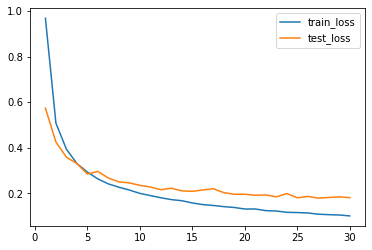

In [8]:
plt.plot(history['epoch'], history['train_loss'], label='train_loss')
plt.plot(history['epoch'], history['test_loss'], label='test_loss')
plt.legend()

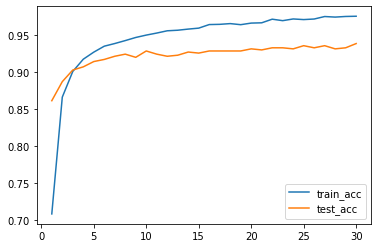

In [9]:
plt.plot(history['epoch'], history['train_acc'], label='train_acc')
plt.plot(history['epoch'], history['test_acc'], label='test_acc')
plt.legend()

* w/o bidir and w/o overfit control: 0.9860, 0.9514
* with bidir and w/o overfit control: 0.9822, 0.9171
* w/o bidir and with overfit control: 0.9785, 0.9100
* with bidir and with overfit control: 0.9820, 0.9457

# Отбрасываем слоты в обучающем датасете

In [57]:
for i in ['train', 'test', 'dev']:
    df = pd.read_csv(f'data/atis_snips/snips/{i}.csv')

    df['text'] = df.apply(lambda x: ' '.join([i for i,j in zip(x['text'].split(), x['slot'].split()) if j == 'O']), axis=1)

    df.to_csv(f'data/processed/drop_slots/{i}.csv', index=False)

In [25]:
names = ['drop_slots', 'origin']
datasets = [
    DatasetManager('data/processed/drop_slots/', batch_size=256, device=device),
    DatasetManager('data/atis_snips/snips/', batch_size=256, device=device)
]

for i, d_train in zip(names, datasets):
    for j, d_test in zip(names, datasets):
        print(f'Train: {i}, test: {j}')
        
        net = Net(768, N_INTENT, 50).to(device)

        criterion = nn.CrossEntropyLoss(ignore_index=-1)
        optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-2)
        
        net.train()
        for _ in trange(N_EPOCH):
            train_loss = 0.0
            correct, total = 0, 0
            for inputs in d_train.train:
                text, intent, slot = inputs
                X = d.encode(text)
                slot = d.pad_slot(slot)

                y_intent = net(X)

                optimizer.zero_grad()

                loss = criterion(y_intent, intent.to(device))

                loss.backward()

                optimizer.step()

                train_loss += loss.item()
                correct += (y_intent.argmax(axis=1).cpu() == intent).sum().item()
                total += intent.shape[0]

        print(f'Train loss: {train_loss / len(d.train):.4f}')
        print(f'Train Acc: {correct / total:.4f}')

        net.eval()
        with torch.no_grad():
            test_loss = 0.0
            correct, total = 0, 0
            for inputs in d_test.test:
                text, intent, slot = inputs
                X = d.encode(text)
                slot = d.pad_slot(slot)

                y_intent = net(X)

                loss = criterion(y_intent, intent.to(device))

                test_loss += loss.item()

                correct += (y_intent.argmax(axis=1).cpu() == intent).sum().item()
                total += intent.shape[0]
            
            
            print(f'Test loss: {test_loss / len(d.test):.4f}')
            print(f'Test Acc: {correct / total:.4f}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predic

Train: drop_slots, test: drop_slots


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.1905
Train Acc: 0.9378
Test loss: 0.2525
Test Acc: 0.9086
Train: drop_slots, test: origin


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.1756
Train Acc: 0.9405
Test loss: 0.8430
Test Acc: 0.7014
Train: origin, test: drop_slots


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.1362
Train Acc: 0.9585
Test loss: 0.8548
Test Acc: 0.7457
Train: origin, test: origin


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.1324
Train Acc: 0.9612
Test loss: 0.1762
Test Acc: 0.9443


# Intent + Slot

In [7]:
d = DatasetManager('./data/atis_snips/snips/', batch_size=256, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
class Net(nn.Module):
    def __init__(self, input_size, num_intent, num_slots, hidden_size=200, lstm_layers=2):
        super(Net, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers 
            
        )
        self.__fc_intent = nn.Sequential(
#             nn.BatchNorm1d(hidden_size * 4 * lstm_layers),
#             nn.Dropout(0.4),
            nn.Linear(hidden_size * 4 * lstm_layers, num_intent),
        )
        
        self.__fc_slot = nn.Sequential(
            nn.Linear(hidden_size * 2, num_slots)
        )
    
    def forward(self, X):
        X_lstm = self.__lstm(X)
        
        y_intent = self.__fc_intent(torch.cat(X_lstm[1]).transpose(0, 1).reshape(X.shape[0], -1))
        y_slot = self.__fc_slot(X_lstm[0])
        
        return y_intent, y_slot

In [12]:
class SlotAndIntentStep(BaseStep):
    def __init__(self, net, criterion, optimizer, alpha):
        super(SlotAndIntentStep, self).__init__(net, criterion, optimizer)
        self.alpha = alpha
        
    def forward(self, X, slot, intent):
        y_intent, y_slot = self.net(X)
        
        loss = {
            'intent': self.criterion(y_intent, intent.to(device)),
            'slot': self.criterion(y_slot.transpose(1, 2), slot.to(device))
        }
        
        y_intent = y_intent.argmax(axis=-1)
        y_slot = y_slot.argmax(axis=-1)
        
        acc = {
            'intent': accuracy(intent, y_intent),
            'slot': accuracy(slot, y_slot)
        }
        
        f1 = {
            'intent': f1_score(intent.cpu(), y_intent.cpu(), average='macro', zero_division=1),
            'slot': f1_score(
                y_true=slot.cpu().flatten(),
                y_pred=y_slot.cpu().flatten(), 
                labels=range(N_SLOT), average='macro',
                zero_division=1
            )
        }
        
        return loss, acc, f1
    
    def step(self, X, slot, intent):
        self.optimizer.zero_grad()
        
        loss, acc, f1 = self.forward(X, slot, intent)
        
        total_loss = (1 - self.alpha) * loss['intent'] + self.alpha * loss['slot']
        
        total_loss.backward()
        
        self.optimizer.step()
        
        return loss, acc, f1

class ProbSlotAndIntentStep(SlotAndIntentStep):    
    def step(self, X, slot, intent):
        self.optimizer.zero_grad()
        
        loss, acc, f1 = self.forward(X, slot, intent)
        
        if random() < alpha:
            total_loss = loss['slot']
        else:
            total_loss = loss['intent']
        
        total_loss.backward()
        
        self.optimizer.step()
        
        return loss, acc, f1

In [13]:
steppers = dict()
a = np.linspace(-3, 3, 9)
alpha_list = [round(i, 2) for i in sigmoid(a)]

for alpha in alpha_list:
    torch.manual_seed(seed)
    net = Net(768, N_INTENT, len(d.slot_enc), 200, 2).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

    steppers[f'alpha={alpha:.2f}'] = SlotAndIntentStep(net, criterion, optimizer, alpha)

In [14]:
history = train(steppers, N_EPOCH)
history.to_csv('history/intent_and_slot_snips.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 / 100
------------------
alpha=0.05_intent
Train loss: 1.1720
Train acc: 0.7317
Train f1: 0.7113
Test loss: 0.2886
Test acc: 0.9113
Test f1: 0.9099
------------------
alpha=0.05_slot
Train loss: 3.1140
Train acc: 0.3663
Train f1: 0.0810
Test loss: 2.3644
Test acc: 0.4475
Test f1: 0.0830
------------------
alpha=0.10_intent
Train loss: 1.0337
Train acc: 0.7681
Train f1: 0.7492
Test loss: 0.2797
Test acc: 0.8990
Test f1: 0.8987
------------------
alpha=0.10_slot
Train loss: 2.7390
Train acc: 0.4084
Train f1: 0.0860
Test loss: 1.8803
Test acc: 0.5059
Test f1: 0.1199
------------------
alpha=0.18_intent
Train loss: 1.0536
Train acc: 0.7576
Train f1: 0.7388
Test loss: 0.2622
Test acc: 0.9161
Test f1: 0.9153
------------------
alpha=0.18_slot
Train loss: 2.6152
Train acc: 0.4307
Train f1: 0.0910
Test loss: 1.6945
Test acc: 0.5309
Test f1: 0.1327
------------------
alpha=0.32_intent
Train loss: 1.2666
Train acc: 0.7236
Train f1: 0.7010
Test loss: 0.3091
Test acc: 0.9051
Test f1: 0.903

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 / 100
------------------
alpha=0.05_intent
Train loss: 0.1688
Train acc: 0.9460
Train f1: 0.9447
Test loss: 0.2049
Test acc: 0.9286
Test f1: 0.9295
------------------
alpha=0.05_slot
Train loss: 2.1130
Train acc: 0.4546
Train f1: 0.0923
Test loss: 1.8571
Test acc: 0.5079
Test f1: 0.1158
------------------
alpha=0.10_intent
Train loss: 0.1784
Train acc: 0.9418
Train f1: 0.9407
Test loss: 0.1829
Test acc: 0.9347
Test f1: 0.9355
------------------
alpha=0.10_slot
Train loss: 1.5978
Train acc: 0.5568
Train f1: 0.1612
Test loss: 1.2670
Test acc: 0.6310
Test f1: 0.2281
------------------
alpha=0.18_intent
Train loss: 0.1726
Train acc: 0.9424
Train f1: 0.9411
Test loss: 0.1718
Test acc: 0.9387
Test f1: 0.9394
------------------
alpha=0.18_slot
Train loss: 1.3761
Train acc: 0.6091
Train f1: 0.2057
Test loss: 1.0534
Test acc: 0.6937
Test f1: 0.3008
------------------
alpha=0.32_intent
Train loss: 0.1837
Train acc: 0.9395
Train f1: 0.9379
Test loss: 0.2163
Test acc: 0.9225
Test f1: 0.923

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 / 100
------------------
alpha=0.05_intent
Train loss: 0.1180
Train acc: 0.9595
Train f1: 0.9586
Test loss: 0.1868
Test acc: 0.9393
Test f1: 0.9391
------------------
alpha=0.05_slot
Train loss: 1.6765
Train acc: 0.5295
Train f1: 0.1291
Test loss: 1.4488
Test acc: 0.5881
Test f1: 0.1631
------------------
alpha=0.10_intent
Train loss: 0.1149
Train acc: 0.9618
Train f1: 0.9612
Test loss: 0.1628
Test acc: 0.9388
Test f1: 0.9386
------------------
alpha=0.10_slot
Train loss: 1.1677
Train acc: 0.6587
Train f1: 0.2601
Test loss: 0.9908
Test acc: 0.7089
Test f1: 0.3131
------------------
alpha=0.18_intent
Train loss: 0.1061
Train acc: 0.9647
Train f1: 0.9640
Test loss: 0.1607
Test acc: 0.9375
Test f1: 0.9394
------------------
alpha=0.18_slot
Train loss: 0.9327
Train acc: 0.7200
Train f1: 0.3295
Test loss: 0.7611
Test acc: 0.7707
Test f1: 0.4120
------------------
alpha=0.32_intent
Train loss: 0.1114
Train acc: 0.9621
Train f1: 0.9614
Test loss: 0.1686
Test acc: 0.9446
Test f1: 0.946

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 / 100
------------------
alpha=0.05_intent
Train loss: 0.0815
Train acc: 0.9738
Train f1: 0.9733
Test loss: 0.2110
Test acc: 0.9264
Test f1: 0.9292
------------------
alpha=0.05_slot
Train loss: 1.3607
Train acc: 0.6040
Train f1: 0.1897
Test loss: 1.1610
Test acc: 0.6633
Test f1: 0.2602
------------------
alpha=0.10_intent
Train loss: 0.0789
Train acc: 0.9745
Train f1: 0.9741
Test loss: 0.1684
Test acc: 0.9426
Test f1: 0.9446
------------------
alpha=0.10_slot
Train loss: 0.9255
Train acc: 0.7200
Train f1: 0.3466
Test loss: 0.7957
Test acc: 0.7621
Test f1: 0.4133
------------------
alpha=0.18_intent
Train loss: 0.0793
Train acc: 0.9739
Train f1: 0.9737
Test loss: 0.1392
Test acc: 0.9386
Test f1: 0.9421
------------------
alpha=0.18_slot
Train loss: 0.7220
Train acc: 0.7767
Train f1: 0.4151
Test loss: 0.6098
Test acc: 0.8137
Test f1: 0.4870
------------------
alpha=0.32_intent
Train loss: 0.0753
Train acc: 0.9762
Train f1: 0.9758
Test loss: 0.1947
Test acc: 0.9452
Test f1: 0.947

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 / 100
------------------
alpha=0.05_intent
Train loss: 0.0613
Train acc: 0.9789
Train f1: 0.9783
Test loss: 0.2077
Test acc: 0.9368
Test f1: 0.9356
------------------
alpha=0.05_slot
Train loss: 1.1222
Train acc: 0.6657
Train f1: 0.2533
Test loss: 0.9859
Test acc: 0.7099
Test f1: 0.3070
------------------
alpha=0.10_intent
Train loss: 0.0554
Train acc: 0.9812
Train f1: 0.9810
Test loss: 0.2075
Test acc: 0.9391
Test f1: 0.9391
------------------
alpha=0.10_slot
Train loss: 0.7508
Train acc: 0.7673
Train f1: 0.4147
Test loss: 0.7366
Test acc: 0.7801
Test f1: 0.4499
------------------
alpha=0.18_intent
Train loss: 0.0545
Train acc: 0.9817
Train f1: 0.9814
Test loss: 0.1970
Test acc: 0.9360
Test f1: 0.9362
------------------
alpha=0.18_slot
Train loss: 0.5798
Train acc: 0.8181
Train f1: 0.4757
Test loss: 0.5045
Test acc: 0.8414
Test f1: 0.5261
------------------
alpha=0.32_intent
Train loss: 0.0497
Train acc: 0.9833
Train f1: 0.9832
Test loss: 0.2121
Test acc: 0.9268
Test f1: 0.927

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 / 100
------------------
alpha=0.05_intent
Train loss: 0.0536
Train acc: 0.9831
Train f1: 0.9827
Test loss: 0.2069
Test acc: 0.9380
Test f1: 0.9380
------------------
alpha=0.05_slot
Train loss: 1.0120
Train acc: 0.6943
Train f1: 0.3007
Test loss: 0.9480
Test acc: 0.7210
Test f1: 0.3251
------------------
alpha=0.10_intent
Train loss: 0.0498
Train acc: 0.9826
Train f1: 0.9823
Test loss: 0.2154
Test acc: 0.9380
Test f1: 0.9372
------------------
alpha=0.10_slot
Train loss: 0.6673
Train acc: 0.7930
Train f1: 0.4580
Test loss: 0.6257
Test acc: 0.8124
Test f1: 0.4833
------------------
alpha=0.18_intent
Train loss: 0.0505
Train acc: 0.9823
Train f1: 0.9821
Test loss: 0.1597
Test acc: 0.9484
Test f1: 0.9484
------------------
alpha=0.18_slot
Train loss: 0.5096
Train acc: 0.8410
Train f1: 0.5092
Test loss: 0.4741
Test acc: 0.8543
Test f1: 0.5491
------------------
alpha=0.32_intent
Train loss: 0.0443
Train acc: 0.9846
Train f1: 0.9841
Test loss: 0.1964
Test acc: 0.9410
Test f1: 0.940

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 / 100
------------------
alpha=0.05_intent
Train loss: 0.0572
Train acc: 0.9796
Train f1: 0.9794
Test loss: 0.1933
Test acc: 0.9318
Test f1: 0.9317
------------------
alpha=0.05_slot
Train loss: 0.9353
Train acc: 0.7160
Train f1: 0.3371
Test loss: 0.8575
Test acc: 0.7385
Test f1: 0.3641
------------------
alpha=0.10_intent
Train loss: 0.0426
Train acc: 0.9853
Train f1: 0.9850
Test loss: 0.1852
Test acc: 0.9528
Test f1: 0.9527
------------------
alpha=0.10_slot
Train loss: 0.5866
Train acc: 0.8166
Train f1: 0.4945
Test loss: 0.5501
Test acc: 0.8344
Test f1: 0.4991
------------------
alpha=0.18_intent
Train loss: 0.0325
Train acc: 0.9883
Train f1: 0.9879
Test loss: 0.1438
Test acc: 0.9510
Test f1: 0.9517
------------------
alpha=0.18_slot
Train loss: 0.4394
Train acc: 0.8614
Train f1: 0.5456
Test loss: 0.4106
Test acc: 0.8712
Test f1: 0.5658
------------------
alpha=0.32_intent
Train loss: 0.0454
Train acc: 0.9848
Train f1: 0.9845
Test loss: 0.1611
Test acc: 0.9476
Test f1: 0.947

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 / 100
------------------
alpha=0.05_intent
Train loss: 0.0476
Train acc: 0.9835
Train f1: 0.9833
Test loss: 0.2122
Test acc: 0.9384
Test f1: 0.9385
------------------
alpha=0.05_slot
Train loss: 0.8418
Train acc: 0.7404
Train f1: 0.3734
Test loss: 0.7536
Test acc: 0.7697
Test f1: 0.4252
------------------
alpha=0.10_intent
Train loss: 0.0292
Train acc: 0.9899
Train f1: 0.9898
Test loss: 0.2165
Test acc: 0.9432
Test f1: 0.9406
------------------
alpha=0.10_slot
Train loss: 0.5205
Train acc: 0.8355
Train f1: 0.5225
Test loss: 0.5353
Test acc: 0.8332
Test f1: 0.5308
------------------
alpha=0.18_intent
Train loss: 0.0235
Train acc: 0.9924
Train f1: 0.9923
Test loss: 0.1858
Test acc: 0.9580
Test f1: 0.9581
------------------
alpha=0.18_slot
Train loss: 0.3794
Train acc: 0.8794
Train f1: 0.5769
Test loss: 0.3809
Test acc: 0.8805
Test f1: 0.6200
------------------
alpha=0.32_intent
Train loss: 0.0248
Train acc: 0.9923
Train f1: 0.9919
Test loss: 0.2125
Test acc: 0.9440
Test f1: 0.945

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 / 100
------------------
alpha=0.05_intent
Train loss: 0.0362
Train acc: 0.9879
Train f1: 0.9877
Test loss: 0.2280
Test acc: 0.9358
Test f1: 0.9373
------------------
alpha=0.05_slot
Train loss: 0.7881
Train acc: 0.7559
Train f1: 0.4064
Test loss: 0.7149
Test acc: 0.7806
Test f1: 0.4422
------------------
alpha=0.10_intent
Train loss: 0.0289
Train acc: 0.9898
Train f1: 0.9890
Test loss: 0.2085
Test acc: 0.9529
Test f1: 0.9535
------------------
alpha=0.10_slot
Train loss: 0.4838
Train acc: 0.8474
Train f1: 0.5518
Test loss: 0.4767
Test acc: 0.8546
Test f1: 0.5917
------------------
alpha=0.18_intent
Train loss: 0.0116
Train acc: 0.9969
Train f1: 0.9969
Test loss: 0.2116
Test acc: 0.9547
Test f1: 0.9555
------------------
alpha=0.18_slot
Train loss: 0.3232
Train acc: 0.8951
Train f1: 0.6078
Test loss: 0.3734
Test acc: 0.8849
Test f1: 0.6142
------------------
alpha=0.32_intent
Train loss: 0.0249
Train acc: 0.9927
Train f1: 0.9926
Test loss: 0.1903
Test acc: 0.9576
Test f1: 0.959

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 / 100
------------------
alpha=0.05_intent
Train loss: 0.0173
Train acc: 0.9944
Train f1: 0.9943
Test loss: 0.2208
Test acc: 0.9563
Test f1: 0.9565
------------------
alpha=0.05_slot
Train loss: 0.7041
Train acc: 0.7789
Train f1: 0.4320
Test loss: 0.6222
Test acc: 0.8038
Test f1: 0.4965
------------------
alpha=0.10_intent
Train loss: 0.0264
Train acc: 0.9919
Train f1: 0.9918
Test loss: 0.1724
Test acc: 0.9550
Test f1: 0.9546
------------------
alpha=0.10_slot
Train loss: 0.4697
Train acc: 0.8530
Train f1: 0.5878
Test loss: 0.4470
Test acc: 0.8608
Test f1: 0.6114
------------------
alpha=0.18_intent
Train loss: 0.0140
Train acc: 0.9955
Train f1: 0.9955
Test loss: 0.2264
Test acc: 0.9507
Test f1: 0.9500
------------------
alpha=0.18_slot
Train loss: 0.3101
Train acc: 0.9006
Train f1: 0.6098
Test loss: 0.3406
Test acc: 0.8939
Test f1: 0.6809
------------------
alpha=0.32_intent
Train loss: 0.0144
Train acc: 0.9953
Train f1: 0.9952
Test loss: 0.1903
Test acc: 0.9449
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 / 100
------------------
alpha=0.05_intent
Train loss: 0.0120
Train acc: 0.9961
Train f1: 0.9958
Test loss: 0.3682
Test acc: 0.9270
Test f1: 0.9277
------------------
alpha=0.05_slot
Train loss: 0.6211
Train acc: 0.8030
Train f1: 0.4660
Test loss: 0.7060
Test acc: 0.7906
Test f1: 0.4767
------------------
alpha=0.10_intent
Train loss: 0.0186
Train acc: 0.9939
Train f1: 0.9938
Test loss: 0.1959
Test acc: 0.9554
Test f1: 0.9571
------------------
alpha=0.10_slot
Train loss: 0.4079
Train acc: 0.8697
Train f1: 0.5971
Test loss: 0.3913
Test acc: 0.8762
Test f1: 0.6058
------------------
alpha=0.18_intent
Train loss: 0.0281
Train acc: 0.9908
Train f1: 0.9908
Test loss: 0.2328
Test acc: 0.9406
Test f1: 0.9416
------------------
alpha=0.18_slot
Train loss: 0.3084
Train acc: 0.9008
Train f1: 0.6166
Test loss: 0.3372
Test acc: 0.8928
Test f1: 0.6383
------------------
alpha=0.32_intent
Train loss: 0.0153
Train acc: 0.9945
Train f1: 0.9946
Test loss: 0.2061
Test acc: 0.9481
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 / 100
------------------
alpha=0.05_intent
Train loss: 0.0553
Train acc: 0.9799
Train f1: 0.9793
Test loss: 0.3048
Test acc: 0.9287
Test f1: 0.9312
------------------
alpha=0.05_slot
Train loss: 0.8118
Train acc: 0.7513
Train f1: 0.4076
Test loss: 0.6780
Test acc: 0.7845
Test f1: 0.4554
------------------
alpha=0.10_intent
Train loss: 0.0168
Train acc: 0.9950
Train f1: 0.9948
Test loss: 0.1747
Test acc: 0.9510
Test f1: 0.9521
------------------
alpha=0.10_slot
Train loss: 0.3808
Train acc: 0.8787
Train f1: 0.5983
Test loss: 0.4036
Test acc: 0.8776
Test f1: 0.6275
------------------
alpha=0.18_intent
Train loss: 0.0211
Train acc: 0.9931
Train f1: 0.9931
Test loss: 0.2517
Test acc: 0.9483
Test f1: 0.9490
------------------
alpha=0.18_slot
Train loss: 0.3057
Train acc: 0.9014
Train f1: 0.6190
Test loss: 0.3398
Test acc: 0.8950
Test f1: 0.6180
------------------
alpha=0.32_intent
Train loss: 0.0102
Train acc: 0.9965
Train f1: 0.9960
Test loss: 0.2105
Test acc: 0.9458
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 / 100
------------------
alpha=0.05_intent
Train loss: 0.0552
Train acc: 0.9802
Train f1: 0.9801
Test loss: 0.1946
Test acc: 0.9453
Test f1: 0.9456
------------------
alpha=0.05_slot
Train loss: 0.7204
Train acc: 0.7775
Train f1: 0.4474
Test loss: 0.5922
Test acc: 0.8115
Test f1: 0.4971
------------------
alpha=0.10_intent
Train loss: 0.0227
Train acc: 0.9920
Train f1: 0.9920
Test loss: 0.2755
Test acc: 0.9363
Test f1: 0.9368
------------------
alpha=0.10_slot
Train loss: 0.3804
Train acc: 0.8781
Train f1: 0.6151
Test loss: 0.4654
Test acc: 0.8616
Test f1: 0.6023
------------------
alpha=0.18_intent
Train loss: 0.0272
Train acc: 0.9923
Train f1: 0.9922
Test loss: 0.2306
Test acc: 0.9490
Test f1: 0.9515
------------------
alpha=0.18_slot
Train loss: 0.2964
Train acc: 0.9054
Train f1: 0.6203
Test loss: 0.3332
Test acc: 0.8985
Test f1: 0.6680
------------------
alpha=0.32_intent
Train loss: 0.0229
Train acc: 0.9920
Train f1: 0.9918
Test loss: 0.2477
Test acc: 0.9432
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 / 100
------------------
alpha=0.05_intent
Train loss: 0.0212
Train acc: 0.9924
Train f1: 0.9922
Test loss: 0.2495
Test acc: 0.9494
Test f1: 0.9505
------------------
alpha=0.05_slot
Train loss: 0.6007
Train acc: 0.8101
Train f1: 0.4808
Test loss: 0.5649
Test acc: 0.8233
Test f1: 0.5219
------------------
alpha=0.10_intent
Train loss: 0.0245
Train acc: 0.9913
Train f1: 0.9911
Test loss: 0.2016
Test acc: 0.9414
Test f1: 0.9429
------------------
alpha=0.10_slot
Train loss: 0.3860
Train acc: 0.8777
Train f1: 0.6142
Test loss: 0.4018
Test acc: 0.8757
Test f1: 0.6732
------------------
alpha=0.18_intent
Train loss: 0.0206
Train acc: 0.9939
Train f1: 0.9938
Test loss: 0.2380
Test acc: 0.9432
Test f1: 0.9439
------------------
alpha=0.18_slot
Train loss: 0.2641
Train acc: 0.9147
Train f1: 0.6525
Test loss: 0.3240
Test acc: 0.9030
Test f1: 0.6495
------------------
alpha=0.32_intent
Train loss: 0.0270
Train acc: 0.9914
Train f1: 0.9913
Test loss: 0.2415
Test acc: 0.9476
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 / 100
------------------
alpha=0.05_intent
Train loss: 0.0273
Train acc: 0.9905
Train f1: 0.9902
Test loss: 0.3655
Test acc: 0.9301
Test f1: 0.9338
------------------
alpha=0.05_slot
Train loss: 0.6189
Train acc: 0.8059
Train f1: 0.4664
Test loss: 0.5786
Test acc: 0.8184
Test f1: 0.5040
------------------
alpha=0.10_intent
Train loss: 0.0106
Train acc: 0.9971
Train f1: 0.9969
Test loss: 0.2050
Test acc: 0.9497
Test f1: 0.9500
------------------
alpha=0.10_slot
Train loss: 0.3226
Train acc: 0.8976
Train f1: 0.6441
Test loss: 0.3456
Test acc: 0.8919
Test f1: 0.6680
------------------
alpha=0.18_intent
Train loss: 0.0271
Train acc: 0.9913
Train f1: 0.9910
Test loss: 0.2694
Test acc: 0.9444
Test f1: 0.9457
------------------
alpha=0.18_slot
Train loss: 0.2773
Train acc: 0.9116
Train f1: 0.6329
Test loss: 0.3334
Test acc: 0.8988
Test f1: 0.6177
------------------
alpha=0.32_intent
Train loss: 0.0297
Train acc: 0.9902
Train f1: 0.9901
Test loss: 0.2908
Test acc: 0.9405
Test f1: 0.93

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 / 100
------------------
alpha=0.05_intent
Train loss: 0.0190
Train acc: 0.9934
Train f1: 0.9933
Test loss: 0.2330
Test acc: 0.9547
Test f1: 0.9541
------------------
alpha=0.05_slot
Train loss: 0.5983
Train acc: 0.8116
Train f1: 0.4937
Test loss: 0.5257
Test acc: 0.8330
Test f1: 0.5360
------------------
alpha=0.10_intent
Train loss: 0.0055
Train acc: 0.9988
Train f1: 0.9987
Test loss: 0.2083
Test acc: 0.9503
Test f1: 0.9518
------------------
alpha=0.10_slot
Train loss: 0.2796
Train acc: 0.9090
Train f1: 0.6394
Test loss: 0.3412
Test acc: 0.8951
Test f1: 0.6604
------------------
alpha=0.18_intent
Train loss: 0.0269
Train acc: 0.9913
Train f1: 0.9911
Test loss: 0.2496
Test acc: 0.9498
Test f1: 0.9509
------------------
alpha=0.18_slot
Train loss: 0.2739
Train acc: 0.9118
Train f1: 0.6182
Test loss: 0.3155
Test acc: 0.9074
Test f1: 0.6264
------------------
alpha=0.32_intent
Train loss: 0.0183
Train acc: 0.9932
Train f1: 0.9931
Test loss: 0.2121
Test acc: 0.9498
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 / 100
------------------
alpha=0.05_intent
Train loss: 0.0109
Train acc: 0.9965
Train f1: 0.9965
Test loss: 0.2357
Test acc: 0.9536
Test f1: 0.9539
------------------
alpha=0.05_slot
Train loss: 0.5244
Train acc: 0.8323
Train f1: 0.5180
Test loss: 0.4834
Test acc: 0.8492
Test f1: 0.5646
------------------
alpha=0.10_intent
Train loss: 0.0020
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.2127
Test acc: 0.9465
Test f1: 0.9470
------------------
alpha=0.10_slot
Train loss: 0.2527
Train acc: 0.9180
Train f1: 0.6557
Test loss: 0.3283
Test acc: 0.9019
Test f1: 0.6507
------------------
alpha=0.18_intent
Train loss: 0.0432
Train acc: 0.9851
Train f1: 0.9849
Test loss: 0.2601
Test acc: 0.9453
Test f1: 0.9467
------------------
alpha=0.18_slot
Train loss: 0.3245
Train acc: 0.8978
Train f1: 0.5874
Test loss: 0.3363
Test acc: 0.9022
Test f1: 0.6320
------------------
alpha=0.32_intent
Train loss: 0.0128
Train acc: 0.9959
Train f1: 0.9958
Test loss: 0.2519
Test acc: 0.9549
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 / 100
------------------
alpha=0.05_intent
Train loss: 0.0032
Train acc: 0.9991
Train f1: 0.9991
Test loss: 0.2909
Test acc: 0.9483
Test f1: 0.9489
------------------
alpha=0.05_slot
Train loss: 0.4659
Train acc: 0.8490
Train f1: 0.5342
Test loss: 0.4527
Test acc: 0.8599
Test f1: 0.5521
------------------
alpha=0.10_intent
Train loss: 0.0012
Train acc: 0.9998
Train f1: 0.9999
Test loss: 0.1801
Test acc: 0.9580
Test f1: 0.9585
------------------
alpha=0.10_slot
Train loss: 0.2295
Train acc: 0.9257
Train f1: 0.6562
Test loss: 0.3179
Test acc: 0.9030
Test f1: 0.6589
------------------
alpha=0.18_intent
Train loss: 0.0180
Train acc: 0.9942
Train f1: 0.9940
Test loss: 0.2549
Test acc: 0.9463
Test f1: 0.9471
------------------
alpha=0.18_slot
Train loss: 0.2655
Train acc: 0.9144
Train f1: 0.6425
Test loss: 0.3065
Test acc: 0.9065
Test f1: 0.6525
------------------
alpha=0.32_intent
Train loss: 0.0092
Train acc: 0.9968
Train f1: 0.9967
Test loss: 0.1824
Test acc: 0.9559
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19 / 100
------------------
alpha=0.05_intent
Train loss: 0.0024
Train acc: 0.9994
Train f1: 0.9994
Test loss: 0.2370
Test acc: 0.9545
Test f1: 0.9547
------------------
alpha=0.05_slot
Train loss: 0.4245
Train acc: 0.8616
Train f1: 0.5476
Test loss: 0.4324
Test acc: 0.8642
Test f1: 0.5918
------------------
alpha=0.10_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2071
Test acc: 0.9530
Test f1: 0.9530
------------------
alpha=0.10_slot
Train loss: 0.2021
Train acc: 0.9348
Train f1: 0.6662
Test loss: 0.2974
Test acc: 0.9051
Test f1: 0.6646
------------------
alpha=0.18_intent
Train loss: 0.0067
Train acc: 0.9978
Train f1: 0.9978
Test loss: 0.2059
Test acc: 0.9535
Test f1: 0.9539
------------------
alpha=0.18_slot
Train loss: 0.2145
Train acc: 0.9299
Train f1: 0.6677
Test loss: 0.2843
Test acc: 0.9170
Test f1: 0.6992
------------------
alpha=0.32_intent
Train loss: 0.0133
Train acc: 0.9961
Train f1: 0.9961
Test loss: 0.1959
Test acc: 0.9494
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 / 100
------------------
alpha=0.05_intent
Train loss: 0.0008
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2620
Test acc: 0.9634
Test f1: 0.9649
------------------
alpha=0.05_slot
Train loss: 0.3863
Train acc: 0.8740
Train f1: 0.5698
Test loss: 0.4065
Test acc: 0.8714
Test f1: 0.5819
------------------
alpha=0.10_intent
Train loss: 0.0018
Train acc: 0.9994
Train f1: 0.9994
Test loss: 0.1604
Test acc: 0.9568
Test f1: 0.9576
------------------
alpha=0.10_slot
Train loss: 0.1976
Train acc: 0.9357
Train f1: 0.6729
Test loss: 0.3044
Test acc: 0.9097
Test f1: 0.6962
------------------
alpha=0.18_intent
Train loss: 0.0049
Train acc: 0.9985
Train f1: 0.9984
Test loss: 0.2578
Test acc: 0.9495
Test f1: 0.9503
------------------
alpha=0.18_slot
Train loss: 0.1931
Train acc: 0.9367
Train f1: 0.6776
Test loss: 0.2750
Test acc: 0.9127
Test f1: 0.6577
------------------
alpha=0.32_intent
Train loss: 0.0117
Train acc: 0.9960
Train f1: 0.9960
Test loss: 0.2667
Test acc: 0.9503
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 / 100
------------------
alpha=0.05_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2572
Test acc: 0.9576
Test f1: 0.9579
------------------
alpha=0.05_slot
Train loss: 0.3584
Train acc: 0.8831
Train f1: 0.5732
Test loss: 0.4062
Test acc: 0.8735
Test f1: 0.5979
------------------
alpha=0.10_intent
Train loss: 0.0146
Train acc: 0.9944
Train f1: 0.9942
Test loss: 0.2637
Test acc: 0.9388
Test f1: 0.9398
------------------
alpha=0.10_slot
Train loss: 0.2639
Train acc: 0.9130
Train f1: 0.6709
Test loss: 0.3474
Test acc: 0.8953
Test f1: 0.6648
------------------
alpha=0.18_intent
Train loss: 0.0029
Train acc: 0.9989
Train f1: 0.9990
Test loss: 0.2349
Test acc: 0.9562
Test f1: 0.9568
------------------
alpha=0.18_slot
Train loss: 0.1730
Train acc: 0.9434
Train f1: 0.6793
Test loss: 0.2491
Test acc: 0.9229
Test f1: 0.7022
------------------
alpha=0.32_intent
Train loss: 0.0087
Train acc: 0.9970
Train f1: 0.9970
Test loss: 0.2850
Test acc: 0.9533
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 / 100
------------------
alpha=0.05_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2851
Test acc: 0.9601
Test f1: 0.9618
------------------
alpha=0.05_slot
Train loss: 0.3307
Train acc: 0.8929
Train f1: 0.5885
Test loss: 0.3796
Test acc: 0.8839
Test f1: 0.6042
------------------
alpha=0.10_intent
Train loss: 0.0126
Train acc: 0.9956
Train f1: 0.9955
Test loss: 0.1972
Test acc: 0.9508
Test f1: 0.9528
------------------
alpha=0.10_slot
Train loss: 0.2515
Train acc: 0.9180
Train f1: 0.6521
Test loss: 0.3273
Test acc: 0.9007
Test f1: 0.6639
------------------
alpha=0.18_intent
Train loss: 0.0016
Train acc: 0.9996
Train f1: 0.9996
Test loss: 0.2464
Test acc: 0.9558
Test f1: 0.9574
------------------
alpha=0.18_slot
Train loss: 0.1497
Train acc: 0.9503
Train f1: 0.6880
Test loss: 0.2551
Test acc: 0.9210
Test f1: 0.7032
------------------
alpha=0.32_intent
Train loss: 0.0054
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.2505
Test acc: 0.9501
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2701
Test acc: 0.9566
Test f1: 0.9575
------------------
alpha=0.05_slot
Train loss: 0.3114
Train acc: 0.8981
Train f1: 0.5975
Test loss: 0.3794
Test acc: 0.8819
Test f1: 0.5828
------------------
alpha=0.10_intent
Train loss: 0.0204
Train acc: 0.9938
Train f1: 0.9936
Test loss: 0.3065
Test acc: 0.9389
Test f1: 0.9381
------------------
alpha=0.10_slot
Train loss: 0.2742
Train acc: 0.9113
Train f1: 0.6351
Test loss: 0.3527
Test acc: 0.8943
Test f1: 0.6054
------------------
alpha=0.18_intent
Train loss: 0.0017
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.2524
Test acc: 0.9555
Test f1: 0.9562
------------------
alpha=0.18_slot
Train loss: 0.1499
Train acc: 0.9505
Train f1: 0.6936
Test loss: 0.2506
Test acc: 0.9264
Test f1: 0.6767
------------------
alpha=0.32_intent
Train loss: 0.0070
Train acc: 0.9977
Train f1: 0.9977
Test loss: 0.2312
Test acc: 0.9554
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2775
Test acc: 0.9594
Test f1: 0.9597
------------------
alpha=0.05_slot
Train loss: 0.2947
Train acc: 0.9039
Train f1: 0.6015
Test loss: 0.3657
Test acc: 0.8900
Test f1: 0.6122
------------------
alpha=0.10_intent
Train loss: 0.0591
Train acc: 0.9816
Train f1: 0.9808
Test loss: 0.2612
Test acc: 0.9283
Test f1: 0.9308
------------------
alpha=0.10_slot
Train loss: 0.3759
Train acc: 0.8813
Train f1: 0.6225
Test loss: 0.4274
Test acc: 0.8722
Test f1: 0.6433
------------------
alpha=0.18_intent
Train loss: 0.0057
Train acc: 0.9978
Train f1: 0.9978
Test loss: 0.2432
Test acc: 0.9511
Test f1: 0.9519
------------------
alpha=0.18_slot
Train loss: 0.1611
Train acc: 0.9466
Train f1: 0.6675
Test loss: 0.2658
Test acc: 0.9205
Test f1: 0.6719
------------------
alpha=0.32_intent
Train loss: 0.0073
Train acc: 0.9976
Train f1: 0.9975
Test loss: 0.2494
Test acc: 0.9620
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2914
Test acc: 0.9611
Test f1: 0.9613
------------------
alpha=0.05_slot
Train loss: 0.2765
Train acc: 0.9096
Train f1: 0.6109
Test loss: 0.3529
Test acc: 0.8924
Test f1: 0.6207
------------------
alpha=0.10_intent
Train loss: 0.0489
Train acc: 0.9854
Train f1: 0.9849
Test loss: 0.2559
Test acc: 0.9488
Test f1: 0.9498
------------------
alpha=0.10_slot
Train loss: 0.4071
Train acc: 0.8712
Train f1: 0.5975
Test loss: 0.3929
Test acc: 0.8774
Test f1: 0.6293
------------------
alpha=0.18_intent
Train loss: 0.0052
Train acc: 0.9986
Train f1: 0.9985
Test loss: 0.2600
Test acc: 0.9520
Test f1: 0.9534
------------------
alpha=0.18_slot
Train loss: 0.1592
Train acc: 0.9474
Train f1: 0.6758
Test loss: 0.2911
Test acc: 0.9181
Test f1: 0.6805
------------------
alpha=0.32_intent
Train loss: 0.0028
Train acc: 0.9992
Train f1: 0.9992
Test loss: 0.3027
Test acc: 0.9619
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2947
Test acc: 0.9589
Test f1: 0.9588
------------------
alpha=0.05_slot
Train loss: 0.2648
Train acc: 0.9140
Train f1: 0.6211
Test loss: 0.3474
Test acc: 0.8970
Test f1: 0.6198
------------------
alpha=0.10_intent
Train loss: 0.0284
Train acc: 0.9906
Train f1: 0.9906
Test loss: 0.2316
Test acc: 0.9481
Test f1: 0.9486
------------------
alpha=0.10_slot
Train loss: 0.3449
Train acc: 0.8895
Train f1: 0.6394
Test loss: 0.3480
Test acc: 0.8924
Test f1: 0.6789
------------------
alpha=0.18_intent
Train loss: 0.0170
Train acc: 0.9941
Train f1: 0.9940
Test loss: 0.2707
Test acc: 0.9427
Test f1: 0.9439
------------------
alpha=0.18_slot
Train loss: 0.1945
Train acc: 0.9358
Train f1: 0.6909
Test loss: 0.3028
Test acc: 0.9100
Test f1: 0.6773
------------------
alpha=0.32_intent
Train loss: 0.0020
Train acc: 0.9995
Train f1: 0.9994
Test loss: 0.2233
Test acc: 0.9572
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2959
Test acc: 0.9523
Test f1: 0.9522
------------------
alpha=0.05_slot
Train loss: 0.2423
Train acc: 0.9205
Train f1: 0.6222
Test loss: 0.3563
Test acc: 0.8940
Test f1: 0.6156
------------------
alpha=0.10_intent
Train loss: 0.0319
Train acc: 0.9889
Train f1: 0.9887
Test loss: 0.2843
Test acc: 0.9397
Test f1: 0.9411
------------------
alpha=0.10_slot
Train loss: 0.3463
Train acc: 0.8901
Train f1: 0.6432
Test loss: 0.3602
Test acc: 0.8882
Test f1: 0.6512
------------------
alpha=0.18_intent
Train loss: 0.0240
Train acc: 0.9923
Train f1: 0.9921
Test loss: 0.2050
Test acc: 0.9485
Test f1: 0.9491
------------------
alpha=0.18_slot
Train loss: 0.2120
Train acc: 0.9309
Train f1: 0.6797
Test loss: 0.3048
Test acc: 0.9100
Test f1: 0.6834
------------------
alpha=0.32_intent
Train loss: 0.0016
Train acc: 0.9996
Train f1: 0.9996
Test loss: 0.2785
Test acc: 0.9550
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3333
Test acc: 0.9536
Test f1: 0.9541
------------------
alpha=0.05_slot
Train loss: 0.2319
Train acc: 0.9231
Train f1: 0.6233
Test loss: 0.3343
Test acc: 0.9011
Test f1: 0.6128
------------------
alpha=0.10_intent
Train loss: 0.0232
Train acc: 0.9927
Train f1: 0.9927
Test loss: 0.2695
Test acc: 0.9418
Test f1: 0.9417
------------------
alpha=0.10_slot
Train loss: 0.3228
Train acc: 0.8978
Train f1: 0.6463
Test loss: 0.3535
Test acc: 0.8949
Test f1: 0.6610
------------------
alpha=0.18_intent
Train loss: 0.0391
Train acc: 0.9876
Train f1: 0.9875
Test loss: 0.3585
Test acc: 0.9335
Test f1: 0.9353
------------------
alpha=0.18_slot
Train loss: 0.2533
Train acc: 0.9178
Train f1: 0.6588
Test loss: 0.3487
Test acc: 0.8962
Test f1: 0.6612
------------------
alpha=0.32_intent
Train loss: 0.0005
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2874
Test acc: 0.9580
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3201
Test acc: 0.9572
Test f1: 0.9575
------------------
alpha=0.05_slot
Train loss: 0.2208
Train acc: 0.9274
Train f1: 0.6244
Test loss: 0.3397
Test acc: 0.9043
Test f1: 0.6004
------------------
alpha=0.10_intent
Train loss: 0.0096
Train acc: 0.9969
Train f1: 0.9969
Test loss: 0.2668
Test acc: 0.9501
Test f1: 0.9507
------------------
alpha=0.10_slot
Train loss: 0.2718
Train acc: 0.9127
Train f1: 0.6492
Test loss: 0.3244
Test acc: 0.9027
Test f1: 0.6863
------------------
alpha=0.18_intent
Train loss: 0.0444
Train acc: 0.9860
Train f1: 0.9860
Test loss: 0.2466
Test acc: 0.9410
Test f1: 0.9430
------------------
alpha=0.18_slot
Train loss: 0.2788
Train acc: 0.9107
Train f1: 0.6536
Test loss: 0.3045
Test acc: 0.9088
Test f1: 0.6842
------------------
alpha=0.32_intent
Train loss: 0.0038
Train acc: 0.9987
Train f1: 0.9987
Test loss: 0.2635
Test acc: 0.9572
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3299
Test acc: 0.9559
Test f1: 0.9566
------------------
alpha=0.05_slot
Train loss: 0.2063
Train acc: 0.9316
Train f1: 0.6308
Test loss: 0.3331
Test acc: 0.9024
Test f1: 0.6189
------------------
alpha=0.10_intent
Train loss: 0.0093
Train acc: 0.9966
Train f1: 0.9966
Test loss: 0.2123
Test acc: 0.9509
Test f1: 0.9516
------------------
alpha=0.10_slot
Train loss: 0.2457
Train acc: 0.9199
Train f1: 0.6720
Test loss: 0.3123
Test acc: 0.9081
Test f1: 0.7006
------------------
alpha=0.18_intent
Train loss: 0.0184
Train acc: 0.9940
Train f1: 0.9940
Test loss: 0.2245
Test acc: 0.9509
Test f1: 0.9524
------------------
alpha=0.18_slot
Train loss: 0.2172
Train acc: 0.9294
Train f1: 0.6773
Test loss: 0.2951
Test acc: 0.9126
Test f1: 0.7165
------------------
alpha=0.32_intent
Train loss: 0.0007
Train acc: 0.9998
Train f1: 0.9999
Test loss: 0.2481
Test acc: 0.9615
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3052
Test acc: 0.9608
Test f1: 0.9614
------------------
alpha=0.05_slot
Train loss: 0.1985
Train acc: 0.9339
Train f1: 0.6376
Test loss: 0.3247
Test acc: 0.9031
Test f1: 0.6385
------------------
alpha=0.10_intent
Train loss: 0.0160
Train acc: 0.9955
Train f1: 0.9954
Test loss: 0.2197
Test acc: 0.9533
Test f1: 0.9516
------------------
alpha=0.10_slot
Train loss: 0.2472
Train acc: 0.9190
Train f1: 0.6647
Test loss: 0.3122
Test acc: 0.9054
Test f1: 0.6650
------------------
alpha=0.18_intent
Train loss: 0.0129
Train acc: 0.9953
Train f1: 0.9951
Test loss: 0.1799
Test acc: 0.9555
Test f1: 0.9551
------------------
alpha=0.18_slot
Train loss: 0.1901
Train acc: 0.9376
Train f1: 0.7200
Test loss: 0.2743
Test acc: 0.9141
Test f1: 0.7102
------------------
alpha=0.32_intent
Train loss: 0.0012
Train acc: 0.9995
Train f1: 0.9996
Test loss: 0.2450
Test acc: 0.9634
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3306
Test acc: 0.9593
Test f1: 0.9590
------------------
alpha=0.05_slot
Train loss: 0.1894
Train acc: 0.9374
Train f1: 0.6391
Test loss: 0.3295
Test acc: 0.9050
Test f1: 0.6341
------------------
alpha=0.10_intent
Train loss: 0.0177
Train acc: 0.9946
Train f1: 0.9946
Test loss: 0.2261
Test acc: 0.9483
Test f1: 0.9477
------------------
alpha=0.10_slot
Train loss: 0.2647
Train acc: 0.9142
Train f1: 0.6748
Test loss: 0.3125
Test acc: 0.9008
Test f1: 0.6878
------------------
alpha=0.18_intent
Train loss: 0.0110
Train acc: 0.9967
Train f1: 0.9967
Test loss: 0.2195
Test acc: 0.9606
Test f1: 0.9608
------------------
alpha=0.18_slot
Train loss: 0.1821
Train acc: 0.9398
Train f1: 0.7092
Test loss: 0.2495
Test acc: 0.9251
Test f1: 0.7126
------------------
alpha=0.32_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2536
Test acc: 0.9594
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3025
Test acc: 0.9594
Test f1: 0.9598
------------------
alpha=0.05_slot
Train loss: 0.1830
Train acc: 0.9399
Train f1: 0.6519
Test loss: 0.3246
Test acc: 0.9086
Test f1: 0.6438
------------------
alpha=0.10_intent
Train loss: 0.0166
Train acc: 0.9949
Train f1: 0.9949
Test loss: 0.2193
Test acc: 0.9468
Test f1: 0.9474
------------------
alpha=0.10_slot
Train loss: 0.2908
Train acc: 0.9061
Train f1: 0.6665
Test loss: 0.3119
Test acc: 0.9038
Test f1: 0.7014
------------------
alpha=0.18_intent
Train loss: 0.0104
Train acc: 0.9961
Train f1: 0.9961
Test loss: 0.2031
Test acc: 0.9555
Test f1: 0.9563
------------------
alpha=0.18_slot
Train loss: 0.1821
Train acc: 0.9395
Train f1: 0.6986
Test loss: 0.2653
Test acc: 0.9241
Test f1: 0.7057
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2542
Test acc: 0.9576
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3084
Test acc: 0.9564
Test f1: 0.9579
------------------
alpha=0.05_slot
Train loss: 0.1753
Train acc: 0.9420
Train f1: 0.6565
Test loss: 0.3156
Test acc: 0.9129
Test f1: 0.6425
------------------
alpha=0.10_intent
Train loss: 0.0133
Train acc: 0.9962
Train f1: 0.9963
Test loss: 0.1761
Test acc: 0.9573
Test f1: 0.9584
------------------
alpha=0.10_slot
Train loss: 0.2719
Train acc: 0.9125
Train f1: 0.6762
Test loss: 0.2820
Test acc: 0.9123
Test f1: 0.7169
------------------
alpha=0.18_intent
Train loss: 0.0085
Train acc: 0.9968
Train f1: 0.9968
Test loss: 0.2349
Test acc: 0.9647
Test f1: 0.9653
------------------
alpha=0.18_slot
Train loss: 0.1707
Train acc: 0.9436
Train f1: 0.6855
Test loss: 0.2583
Test acc: 0.9258
Test f1: 0.6913
------------------
alpha=0.32_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.4625
Test acc: 0.9521
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3378
Test acc: 0.9527
Test f1: 0.9526
------------------
alpha=0.05_slot
Train loss: 0.1698
Train acc: 0.9445
Train f1: 0.6545
Test loss: 0.3327
Test acc: 0.9090
Test f1: 0.6070
------------------
alpha=0.10_intent
Train loss: 0.0106
Train acc: 0.9965
Train f1: 0.9964
Test loss: 0.1905
Test acc: 0.9463
Test f1: 0.9458
------------------
alpha=0.10_slot
Train loss: 0.2392
Train acc: 0.9221
Train f1: 0.6967
Test loss: 0.3159
Test acc: 0.9014
Test f1: 0.6896
------------------
alpha=0.18_intent
Train loss: 0.0042
Train acc: 0.9986
Train f1: 0.9985
Test loss: 0.2179
Test acc: 0.9598
Test f1: 0.9605
------------------
alpha=0.18_slot
Train loss: 0.1543
Train acc: 0.9488
Train f1: 0.6963
Test loss: 0.2522
Test acc: 0.9278
Test f1: 0.7055
------------------
alpha=0.32_intent
Train loss: 0.0251
Train acc: 0.9930
Train f1: 0.9929
Test loss: 0.3313
Test acc: 0.9406
Test f1: 0.93

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3356
Test acc: 0.9598
Test f1: 0.9596
------------------
alpha=0.05_slot
Train loss: 0.1568
Train acc: 0.9479
Train f1: 0.6521
Test loss: 0.3140
Test acc: 0.9100
Test f1: 0.6426
------------------
alpha=0.10_intent
Train loss: 0.0113
Train acc: 0.9962
Train f1: 0.9961
Test loss: 0.2013
Test acc: 0.9549
Test f1: 0.9552
------------------
alpha=0.10_slot
Train loss: 0.2517
Train acc: 0.9188
Train f1: 0.7155
Test loss: 0.3132
Test acc: 0.9038
Test f1: 0.7304
------------------
alpha=0.18_intent
Train loss: 0.0046
Train acc: 0.9982
Train f1: 0.9982
Test loss: 0.2505
Test acc: 0.9567
Test f1: 0.9563
------------------
alpha=0.18_slot
Train loss: 0.1426
Train acc: 0.9522
Train f1: 0.7183
Test loss: 0.2520
Test acc: 0.9246
Test f1: 0.7124
------------------
alpha=0.32_intent
Train loss: 0.0611
Train acc: 0.9816
Train f1: 0.9814
Test loss: 0.2607
Test acc: 0.9420
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3494
Test acc: 0.9560
Test f1: 0.9553
------------------
alpha=0.05_slot
Train loss: 0.1487
Train acc: 0.9512
Train f1: 0.6573
Test loss: 0.3322
Test acc: 0.9091
Test f1: 0.5951
------------------
alpha=0.10_intent
Train loss: 0.0058
Train acc: 0.9982
Train f1: 0.9982
Test loss: 0.1823
Test acc: 0.9547
Test f1: 0.9526
------------------
alpha=0.10_slot
Train loss: 0.2161
Train acc: 0.9298
Train f1: 0.7369
Test loss: 0.2827
Test acc: 0.9130
Test f1: 0.7477
------------------
alpha=0.18_intent
Train loss: 0.0028
Train acc: 0.9989
Train f1: 0.9988
Test loss: 0.3172
Test acc: 0.9586
Test f1: 0.9580
------------------
alpha=0.18_slot
Train loss: 0.1299
Train acc: 0.9562
Train f1: 0.7271
Test loss: 0.2621
Test acc: 0.9238
Test f1: 0.6995
------------------
alpha=0.32_intent
Train loss: 0.0433
Train acc: 0.9858
Train f1: 0.9856
Test loss: 0.2138
Test acc: 0.9550
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 38 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3218
Test acc: 0.9541
Test f1: 0.9522
------------------
alpha=0.05_slot
Train loss: 0.1553
Train acc: 0.9489
Train f1: 0.6627
Test loss: 0.3156
Test acc: 0.9145
Test f1: 0.6392
------------------
alpha=0.10_intent
Train loss: 0.0056
Train acc: 0.9982
Train f1: 0.9982
Test loss: 0.2341
Test acc: 0.9502
Test f1: 0.9496
------------------
alpha=0.10_slot
Train loss: 0.1931
Train acc: 0.9368
Train f1: 0.7466
Test loss: 0.3036
Test acc: 0.9127
Test f1: 0.7541
------------------
alpha=0.18_intent
Train loss: 0.0010
Train acc: 0.9996
Train f1: 0.9996
Test loss: 0.2350
Test acc: 0.9620
Test f1: 0.9611
------------------
alpha=0.18_slot
Train loss: 0.1189
Train acc: 0.9591
Train f1: 0.6984
Test loss: 0.2567
Test acc: 0.9270
Test f1: 0.6896
------------------
alpha=0.32_intent
Train loss: 0.0245
Train acc: 0.9920
Train f1: 0.9919
Test loss: 0.1773
Test acc: 0.9559
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3388
Test acc: 0.9593
Test f1: 0.9601
------------------
alpha=0.05_slot
Train loss: 0.1424
Train acc: 0.9530
Train f1: 0.6711
Test loss: 0.3335
Test acc: 0.9145
Test f1: 0.6344
------------------
alpha=0.10_intent
Train loss: 0.0095
Train acc: 0.9971
Train f1: 0.9970
Test loss: 0.1699
Test acc: 0.9628
Test f1: 0.9633
------------------
alpha=0.10_slot
Train loss: 0.2180
Train acc: 0.9292
Train f1: 0.7275
Test loss: 0.3006
Test acc: 0.9067
Test f1: 0.7229
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2707
Test acc: 0.9580
Test f1: 0.9579
------------------
alpha=0.18_slot
Train loss: 0.1014
Train acc: 0.9658
Train f1: 0.7173
Test loss: 0.2647
Test acc: 0.9302
Test f1: 0.7005
------------------
alpha=0.32_intent
Train loss: 0.0181
Train acc: 0.9940
Train f1: 0.9939
Test loss: 0.1847
Test acc: 0.9533
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 / 100
------------------
alpha=0.05_intent
Train loss: 0.0516
Train acc: 0.9838
Train f1: 0.9840
Test loss: 0.5122
Test acc: 0.8951
Test f1: 0.8936
------------------
alpha=0.05_slot
Train loss: 0.3762
Train acc: 0.8824
Train f1: 0.5959
Test loss: 0.8989
Test acc: 0.7368
Test f1: 0.4484
------------------
alpha=0.10_intent
Train loss: 0.0082
Train acc: 0.9979
Train f1: 0.9979
Test loss: 0.2285
Test acc: 0.9549
Test f1: 0.9560
------------------
alpha=0.10_slot
Train loss: 0.2045
Train acc: 0.9331
Train f1: 0.7246
Test loss: 0.2936
Test acc: 0.9105
Test f1: 0.7331
------------------
alpha=0.18_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2880
Test acc: 0.9585
Test f1: 0.9590
------------------
alpha=0.18_slot
Train loss: 0.0880
Train acc: 0.9705
Train f1: 0.7256
Test loss: 0.2654
Test acc: 0.9324
Test f1: 0.6955
------------------
alpha=0.32_intent
Train loss: 0.0223
Train acc: 0.9917
Train f1: 0.9916
Test loss: 0.2612
Test acc: 0.9488
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41 / 100
------------------
alpha=0.05_intent
Train loss: 0.1809
Train acc: 0.9487
Train f1: 0.9472
Test loss: 0.2651
Test acc: 0.9310
Test f1: 0.9330
------------------
alpha=0.05_slot
Train loss: 0.8731
Train acc: 0.7419
Train f1: 0.4455
Test loss: 0.6754
Test acc: 0.7985
Test f1: 0.5387
------------------
alpha=0.10_intent
Train loss: 0.0027
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.1900
Test acc: 0.9563
Test f1: 0.9565
------------------
alpha=0.10_slot
Train loss: 0.1782
Train acc: 0.9414
Train f1: 0.7338
Test loss: 0.2648
Test acc: 0.9209
Test f1: 0.7369
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2462
Test acc: 0.9612
Test f1: 0.9611
------------------
alpha=0.18_slot
Train loss: 0.0755
Train acc: 0.9745
Train f1: 0.7267
Test loss: 0.2624
Test acc: 0.9342
Test f1: 0.7189
------------------
alpha=0.32_intent
Train loss: 0.0093
Train acc: 0.9966
Train f1: 0.9966
Test loss: 0.2273
Test acc: 0.9534
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42 / 100
------------------
alpha=0.05_intent
Train loss: 0.1005
Train acc: 0.9682
Train f1: 0.9676
Test loss: 0.2357
Test acc: 0.9367
Test f1: 0.9373
------------------
alpha=0.05_slot
Train loss: 0.7023
Train acc: 0.7864
Train f1: 0.4970
Test loss: 0.5747
Test acc: 0.8264
Test f1: 0.5644
------------------
alpha=0.10_intent
Train loss: 0.0032
Train acc: 0.9985
Train f1: 0.9982
Test loss: 0.2510
Test acc: 0.9547
Test f1: 0.9544
------------------
alpha=0.10_slot
Train loss: 0.1639
Train acc: 0.9453
Train f1: 0.7347
Test loss: 0.2848
Test acc: 0.9204
Test f1: 0.7393
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2596
Test acc: 0.9594
Test f1: 0.9600
------------------
alpha=0.18_slot
Train loss: 0.0701
Train acc: 0.9764
Train f1: 0.7248
Test loss: 0.2658
Test acc: 0.9306
Test f1: 0.6936
------------------
alpha=0.32_intent
Train loss: 0.0072
Train acc: 0.9976
Train f1: 0.9975
Test loss: 0.2853
Test acc: 0.9468
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43 / 100
------------------
alpha=0.05_intent
Train loss: 0.0527
Train acc: 0.9809
Train f1: 0.9807
Test loss: 0.2542
Test acc: 0.9424
Test f1: 0.9440
------------------
alpha=0.05_slot
Train loss: 0.5806
Train acc: 0.8196
Train f1: 0.5345
Test loss: 0.4824
Test acc: 0.8529
Test f1: 0.6054
------------------
alpha=0.10_intent
Train loss: 0.0155
Train acc: 0.9953
Train f1: 0.9952
Test loss: 0.2302
Test acc: 0.9547
Test f1: 0.9551
------------------
alpha=0.10_slot
Train loss: 0.2371
Train acc: 0.9230
Train f1: 0.7151
Test loss: 0.3073
Test acc: 0.9085
Test f1: 0.7212
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2790
Test acc: 0.9598
Test f1: 0.9605
------------------
alpha=0.18_slot
Train loss: 0.0660
Train acc: 0.9780
Train f1: 0.7245
Test loss: 0.2574
Test acc: 0.9341
Test f1: 0.7019
------------------
alpha=0.32_intent
Train loss: 0.0139
Train acc: 0.9961
Train f1: 0.9960
Test loss: 0.3040
Test acc: 0.9497
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44 / 100
------------------
alpha=0.05_intent
Train loss: 0.0341
Train acc: 0.9879
Train f1: 0.9878
Test loss: 0.1895
Test acc: 0.9536
Test f1: 0.9537
------------------
alpha=0.05_slot
Train loss: 0.4979
Train acc: 0.8437
Train f1: 0.5611
Test loss: 0.4515
Test acc: 0.8657
Test f1: 0.6321
------------------
alpha=0.10_intent
Train loss: 0.0070
Train acc: 0.9978
Train f1: 0.9977
Test loss: 0.3256
Test acc: 0.9519
Test f1: 0.9533
------------------
alpha=0.10_slot
Train loss: 0.1939
Train acc: 0.9368
Train f1: 0.7240
Test loss: 0.2812
Test acc: 0.9185
Test f1: 0.7230
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2650
Test acc: 0.9620
Test f1: 0.9631
------------------
alpha=0.18_slot
Train loss: 0.0629
Train acc: 0.9795
Train f1: 0.7283
Test loss: 0.2625
Test acc: 0.9339
Test f1: 0.6859
------------------
alpha=0.32_intent
Train loss: 0.0108
Train acc: 0.9967
Train f1: 0.9966
Test loss: 0.2298
Test acc: 0.9450
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45 / 100
------------------
alpha=0.05_intent
Train loss: 0.0234
Train acc: 0.9924
Train f1: 0.9924
Test loss: 0.2297
Test acc: 0.9374
Test f1: 0.9398
------------------
alpha=0.05_slot
Train loss: 0.4503
Train acc: 0.8565
Train f1: 0.5889
Test loss: 0.4297
Test acc: 0.8671
Test f1: 0.6116
------------------
alpha=0.10_intent
Train loss: 0.0102
Train acc: 0.9959
Train f1: 0.9959
Test loss: 0.2431
Test acc: 0.9562
Test f1: 0.9577
------------------
alpha=0.10_slot
Train loss: 0.2000
Train acc: 0.9343
Train f1: 0.7075
Test loss: 0.2907
Test acc: 0.9101
Test f1: 0.6987
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2593
Test acc: 0.9602
Test f1: 0.9608
------------------
alpha=0.18_slot
Train loss: 0.0596
Train acc: 0.9799
Train f1: 0.7120
Test loss: 0.2641
Test acc: 0.9349
Test f1: 0.7016
------------------
alpha=0.32_intent
Train loss: 0.0104
Train acc: 0.9968
Train f1: 0.9968
Test loss: 0.2714
Test acc: 0.9475
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46 / 100
------------------
alpha=0.05_intent
Train loss: 0.0127
Train acc: 0.9957
Train f1: 0.9958
Test loss: 0.1692
Test acc: 0.9523
Test f1: 0.9528
------------------
alpha=0.05_slot
Train loss: 0.4051
Train acc: 0.8699
Train f1: 0.6146
Test loss: 0.3971
Test acc: 0.8728
Test f1: 0.6188
------------------
alpha=0.10_intent
Train loss: 0.0220
Train acc: 0.9933
Train f1: 0.9933
Test loss: 0.2379
Test acc: 0.9515
Test f1: 0.9510
------------------
alpha=0.10_slot
Train loss: 0.2165
Train acc: 0.9299
Train f1: 0.7019
Test loss: 0.3094
Test acc: 0.9064
Test f1: 0.7123
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2574
Test acc: 0.9576
Test f1: 0.9583
------------------
alpha=0.18_slot
Train loss: 0.0556
Train acc: 0.9810
Train f1: 0.7115
Test loss: 0.2703
Test acc: 0.9336
Test f1: 0.6765
------------------
alpha=0.32_intent
Train loss: 0.0032
Train acc: 0.9991
Train f1: 0.9991
Test loss: 0.2287
Test acc: 0.9615
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47 / 100
------------------
alpha=0.05_intent
Train loss: 0.0074
Train acc: 0.9971
Train f1: 0.9971
Test loss: 0.2132
Test acc: 0.9580
Test f1: 0.9581
------------------
alpha=0.05_slot
Train loss: 0.3649
Train acc: 0.8828
Train f1: 0.6095
Test loss: 0.3765
Test acc: 0.8846
Test f1: 0.6131
------------------
alpha=0.10_intent
Train loss: 0.0350
Train acc: 0.9897
Train f1: 0.9896
Test loss: 0.4453
Test acc: 0.9334
Test f1: 0.9324
------------------
alpha=0.10_slot
Train loss: 0.3080
Train acc: 0.9016
Train f1: 0.6447
Test loss: 0.3630
Test acc: 0.8962
Test f1: 0.6601
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2805
Test acc: 0.9566
Test f1: 0.9560
------------------
alpha=0.18_slot
Train loss: 0.0551
Train acc: 0.9813
Train f1: 0.7106
Test loss: 0.2700
Test acc: 0.9362
Test f1: 0.6904
------------------
alpha=0.32_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2430
Test acc: 0.9597
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 48 / 100
------------------
alpha=0.05_intent
Train loss: 0.0084
Train acc: 0.9974
Train f1: 0.9973
Test loss: 0.2328
Test acc: 0.9426
Test f1: 0.9446
------------------
alpha=0.05_slot
Train loss: 0.3584
Train acc: 0.8844
Train f1: 0.6026
Test loss: 0.3815
Test acc: 0.8841
Test f1: 0.6172
------------------
alpha=0.10_intent
Train loss: 0.0642
Train acc: 0.9846
Train f1: 0.9842
Test loss: 0.3470
Test acc: 0.9432
Test f1: 0.9444
------------------
alpha=0.10_slot
Train loss: 0.3616
Train acc: 0.8851
Train f1: 0.6407
Test loss: 0.3775
Test acc: 0.8919
Test f1: 0.7092
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2800
Test acc: 0.9611
Test f1: 0.9614
------------------
alpha=0.18_slot
Train loss: 0.0539
Train acc: 0.9819
Train f1: 0.7177
Test loss: 0.2793
Test acc: 0.9336
Test f1: 0.6929
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2579
Test acc: 0.9579
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49 / 100
------------------
alpha=0.05_intent
Train loss: 0.0040
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.2400
Test acc: 0.9437
Test f1: 0.9450
------------------
alpha=0.05_slot
Train loss: 0.3206
Train acc: 0.8965
Train f1: 0.6280
Test loss: 0.3893
Test acc: 0.8856
Test f1: 0.6265
------------------
alpha=0.10_intent
Train loss: 0.0889
Train acc: 0.9787
Train f1: 0.9783
Test loss: 0.3410
Test acc: 0.9362
Test f1: 0.9367
------------------
alpha=0.10_slot
Train loss: 0.4542
Train acc: 0.8564
Train f1: 0.6191
Test loss: 0.4375
Test acc: 0.8648
Test f1: 0.6523
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2424
Test acc: 0.9625
Test f1: 0.9639
------------------
alpha=0.18_slot
Train loss: 0.0531
Train acc: 0.9818
Train f1: 0.7150
Test loss: 0.2780
Test acc: 0.9346
Test f1: 0.6814
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2460
Test acc: 0.9562
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50 / 100
------------------
alpha=0.05_intent
Train loss: 0.0030
Train acc: 0.9992
Train f1: 0.9992
Test loss: 0.2113
Test acc: 0.9519
Test f1: 0.9528
------------------
alpha=0.05_slot
Train loss: 0.3216
Train acc: 0.8968
Train f1: 0.6461
Test loss: 0.3516
Test acc: 0.8922
Test f1: 0.6742
------------------
alpha=0.10_intent
Train loss: 0.0699
Train acc: 0.9825
Train f1: 0.9824
Test loss: 0.3601
Test acc: 0.9366
Test f1: 0.9371
------------------
alpha=0.10_slot
Train loss: 0.4647
Train acc: 0.8536
Train f1: 0.6204
Test loss: 0.3988
Test acc: 0.8794
Test f1: 0.6718
------------------
alpha=0.18_intent
Train loss: 0.0013
Train acc: 0.9997
Train f1: 0.9997
Test loss: 0.2855
Test acc: 0.9585
Test f1: 0.9604
------------------
alpha=0.18_slot
Train loss: 0.0577
Train acc: 0.9805
Train f1: 0.7180
Test loss: 0.3180
Test acc: 0.9265
Test f1: 0.6995
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2557
Test acc: 0.9650
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 51 / 100
------------------
alpha=0.05_intent
Train loss: 0.0031
Train acc: 0.9992
Train f1: 0.9992
Test loss: 0.2975
Test acc: 0.9471
Test f1: 0.9485
------------------
alpha=0.05_slot
Train loss: 0.2931
Train acc: 0.9045
Train f1: 0.6580
Test loss: 0.3639
Test acc: 0.8970
Test f1: 0.6660
------------------
alpha=0.10_intent
Train loss: 0.0404
Train acc: 0.9891
Train f1: 0.9888
Test loss: 0.3102
Test acc: 0.9343
Test f1: 0.9355
------------------
alpha=0.10_slot
Train loss: 0.4176
Train acc: 0.8677
Train f1: 0.6383
Test loss: 0.3941
Test acc: 0.8816
Test f1: 0.6825
------------------
alpha=0.18_intent
Train loss: 0.0106
Train acc: 0.9971
Train f1: 0.9971
Test loss: 0.3890
Test acc: 0.9449
Test f1: 0.9449
------------------
alpha=0.18_slot
Train loss: 0.0853
Train acc: 0.9710
Train f1: 0.7153
Test loss: 0.3722
Test acc: 0.9093
Test f1: 0.6033
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2625
Test acc: 0.9638
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 52 / 100
------------------
alpha=0.05_intent
Train loss: 0.0130
Train acc: 0.9962
Train f1: 0.9962
Test loss: 0.2909
Test acc: 0.9348
Test f1: 0.9363
------------------
alpha=0.05_slot
Train loss: 0.3306
Train acc: 0.8943
Train f1: 0.6504
Test loss: 0.3906
Test acc: 0.8798
Test f1: 0.6560
------------------
alpha=0.10_intent
Train loss: 0.0266
Train acc: 0.9918
Train f1: 0.9916
Test loss: 0.4087
Test acc: 0.9355
Test f1: 0.9327
------------------
alpha=0.10_slot
Train loss: 0.3873
Train acc: 0.8768
Train f1: 0.6419
Test loss: 0.3978
Test acc: 0.8823
Test f1: 0.6864
------------------
alpha=0.18_intent
Train loss: 0.1156
Train acc: 0.9691
Train f1: 0.9685
Test loss: 0.3756
Test acc: 0.9330
Test f1: 0.9318
------------------
alpha=0.18_slot
Train loss: 0.4520
Train acc: 0.8623
Train f1: 0.5862
Test loss: 0.4646
Test acc: 0.8624
Test f1: 0.6643
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2750
Test acc: 0.9574
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 53 / 100
------------------
alpha=0.05_intent
Train loss: 0.0062
Train acc: 0.9981
Train f1: 0.9981
Test loss: 0.1778
Test acc: 0.9554
Test f1: 0.9569
------------------
alpha=0.05_slot
Train loss: 0.3447
Train acc: 0.8895
Train f1: 0.6219
Test loss: 0.3488
Test acc: 0.8949
Test f1: 0.6696
------------------
alpha=0.10_intent
Train loss: 0.0146
Train acc: 0.9953
Train f1: 0.9953
Test loss: 0.2977
Test acc: 0.9492
Test f1: 0.9480
------------------
alpha=0.10_slot
Train loss: 0.3382
Train acc: 0.8919
Train f1: 0.6729
Test loss: 0.3418
Test acc: 0.8992
Test f1: 0.6982
------------------
alpha=0.18_intent
Train loss: 0.1104
Train acc: 0.9694
Train f1: 0.9691
Test loss: 0.1526
Test acc: 0.9491
Test f1: 0.9492
------------------
alpha=0.18_slot
Train loss: 0.4438
Train acc: 0.8641
Train f1: 0.6043
Test loss: 0.3708
Test acc: 0.8876
Test f1: 0.6941
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2857
Test acc: 0.9627
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 54 / 100
------------------
alpha=0.05_intent
Train loss: 0.0052
Train acc: 0.9985
Train f1: 0.9984
Test loss: 0.2485
Test acc: 0.9465
Test f1: 0.9477
------------------
alpha=0.05_slot
Train loss: 0.3056
Train acc: 0.9007
Train f1: 0.6550
Test loss: 0.3295
Test acc: 0.9003
Test f1: 0.6749
------------------
alpha=0.10_intent
Train loss: 0.0158
Train acc: 0.9953
Train f1: 0.9952
Test loss: 0.3216
Test acc: 0.9264
Test f1: 0.9259
------------------
alpha=0.10_slot
Train loss: 0.3101
Train acc: 0.9005
Train f1: 0.6763
Test loss: 0.3783
Test acc: 0.8896
Test f1: 0.7070
------------------
alpha=0.18_intent
Train loss: 0.0470
Train acc: 0.9853
Train f1: 0.9851
Test loss: 0.2275
Test acc: 0.9562
Test f1: 0.9574
------------------
alpha=0.18_slot
Train loss: 0.3456
Train acc: 0.8909
Train f1: 0.6603
Test loss: 0.3314
Test acc: 0.9044
Test f1: 0.7063
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2293
Test acc: 0.9584
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 55 / 100
------------------
alpha=0.05_intent
Train loss: 0.0038
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.2302
Test acc: 0.9479
Test f1: 0.9492
------------------
alpha=0.05_slot
Train loss: 0.2703
Train acc: 0.9119
Train f1: 0.6728
Test loss: 0.3233
Test acc: 0.9033
Test f1: 0.6722
------------------
alpha=0.10_intent
Train loss: 0.0108
Train acc: 0.9968
Train f1: 0.9968
Test loss: 0.2574
Test acc: 0.9555
Test f1: 0.9565
------------------
alpha=0.10_slot
Train loss: 0.2974
Train acc: 0.9042
Train f1: 0.6878
Test loss: 0.3256
Test acc: 0.9041
Test f1: 0.7101
------------------
alpha=0.18_intent
Train loss: 0.0501
Train acc: 0.9851
Train f1: 0.9849
Test loss: 0.2642
Test acc: 0.9554
Test f1: 0.9560
------------------
alpha=0.18_slot
Train loss: 0.3300
Train acc: 0.8965
Train f1: 0.6750
Test loss: 0.3286
Test acc: 0.9032
Test f1: 0.7062
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2405
Test acc: 0.9643
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 56 / 100
------------------
alpha=0.05_intent
Train loss: 0.0070
Train acc: 0.9978
Train f1: 0.9978
Test loss: 0.2488
Test acc: 0.9444
Test f1: 0.9439
------------------
alpha=0.05_slot
Train loss: 0.2788
Train acc: 0.9088
Train f1: 0.6689
Test loss: 0.3637
Test acc: 0.8899
Test f1: 0.6653
------------------
alpha=0.10_intent
Train loss: 0.0021
Train acc: 0.9993
Train f1: 0.9993
Test loss: 0.2247
Test acc: 0.9567
Test f1: 0.9559
------------------
alpha=0.10_slot
Train loss: 0.2446
Train acc: 0.9200
Train f1: 0.7168
Test loss: 0.2994
Test acc: 0.9101
Test f1: 0.7154
------------------
alpha=0.18_intent
Train loss: 0.0475
Train acc: 0.9850
Train f1: 0.9847
Test loss: 0.1323
Test acc: 0.9685
Test f1: 0.9687
------------------
alpha=0.18_slot
Train loss: 0.3311
Train acc: 0.8955
Train f1: 0.6553
Test loss: 0.2917
Test acc: 0.9106
Test f1: 0.7126
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2427
Test acc: 0.9681
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 57 / 100
------------------
alpha=0.05_intent
Train loss: 0.0195
Train acc: 0.9933
Train f1: 0.9933
Test loss: 0.3848
Test acc: 0.9365
Test f1: 0.9376
------------------
alpha=0.05_slot
Train loss: 0.3558
Train acc: 0.8857
Train f1: 0.6380
Test loss: 0.4069
Test acc: 0.8785
Test f1: 0.6362
------------------
alpha=0.10_intent
Train loss: 0.0026
Train acc: 0.9996
Train f1: 0.9996
Test loss: 0.2462
Test acc: 0.9602
Test f1: 0.9607
------------------
alpha=0.10_slot
Train loss: 0.2228
Train acc: 0.9275
Train f1: 0.7315
Test loss: 0.2883
Test acc: 0.9121
Test f1: 0.7292
------------------
alpha=0.18_intent
Train loss: 0.0292
Train acc: 0.9904
Train f1: 0.9903
Test loss: 0.2597
Test acc: 0.9497
Test f1: 0.9498
------------------
alpha=0.18_slot
Train loss: 0.3005
Train acc: 0.9039
Train f1: 0.6620
Test loss: 0.3155
Test acc: 0.9115
Test f1: 0.6925
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2302
Test acc: 0.9668
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 58 / 100
------------------
alpha=0.05_intent
Train loss: 0.0309
Train acc: 0.9899
Train f1: 0.9894
Test loss: 0.3778
Test acc: 0.9301
Test f1: 0.9303
------------------
alpha=0.05_slot
Train loss: 0.4284
Train acc: 0.8623
Train f1: 0.5920
Test loss: 0.4142
Test acc: 0.8735
Test f1: 0.6158
------------------
alpha=0.10_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2480
Test acc: 0.9598
Test f1: 0.9604
------------------
alpha=0.10_slot
Train loss: 0.1976
Train acc: 0.9347
Train f1: 0.7416
Test loss: 0.2881
Test acc: 0.9126
Test f1: 0.7326
------------------
alpha=0.18_intent
Train loss: 0.0188
Train acc: 0.9943
Train f1: 0.9942
Test loss: 0.2714
Test acc: 0.9484
Test f1: 0.9483
------------------
alpha=0.18_slot
Train loss: 0.2659
Train acc: 0.9144
Train f1: 0.6702
Test loss: 0.2834
Test acc: 0.9204
Test f1: 0.7009
------------------
alpha=0.32_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2582
Test acc: 0.9645
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 59 / 100
------------------
alpha=0.05_intent
Train loss: 0.0610
Train acc: 0.9819
Train f1: 0.9817
Test loss: 0.2807
Test acc: 0.9392
Test f1: 0.9398
------------------
alpha=0.05_slot
Train loss: 0.4965
Train acc: 0.8450
Train f1: 0.5629
Test loss: 0.4601
Test acc: 0.8584
Test f1: 0.6424
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2328
Test acc: 0.9615
Test f1: 0.9624
------------------
alpha=0.10_slot
Train loss: 0.1754
Train acc: 0.9421
Train f1: 0.7440
Test loss: 0.2704
Test acc: 0.9170
Test f1: 0.7299
------------------
alpha=0.18_intent
Train loss: 0.0116
Train acc: 0.9958
Train f1: 0.9957
Test loss: 0.1899
Test acc: 0.9664
Test f1: 0.9675
------------------
alpha=0.18_slot
Train loss: 0.2138
Train acc: 0.9300
Train f1: 0.6775
Test loss: 0.2852
Test acc: 0.9211
Test f1: 0.7293
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2525
Test acc: 0.9585
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 60 / 100
------------------
alpha=0.05_intent
Train loss: 0.0406
Train acc: 0.9880
Train f1: 0.9879
Test loss: 0.3243
Test acc: 0.9398
Test f1: 0.9408
------------------
alpha=0.05_slot
Train loss: 0.5244
Train acc: 0.8349
Train f1: 0.5786
Test loss: 0.4603
Test acc: 0.8569
Test f1: 0.6174
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2483
Test acc: 0.9606
Test f1: 0.9610
------------------
alpha=0.10_slot
Train loss: 0.1676
Train acc: 0.9435
Train f1: 0.7479
Test loss: 0.2760
Test acc: 0.9189
Test f1: 0.7222
------------------
alpha=0.18_intent
Train loss: 0.0033
Train acc: 0.9989
Train f1: 0.9989
Test loss: 0.2163
Test acc: 0.9642
Test f1: 0.9635
------------------
alpha=0.18_slot
Train loss: 0.1883
Train acc: 0.9384
Train f1: 0.7303
Test loss: 0.2684
Test acc: 0.9212
Test f1: 0.7279
------------------
alpha=0.32_intent
Train loss: 0.0004
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2454
Test acc: 0.9646
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 61 / 100
------------------
alpha=0.05_intent
Train loss: 0.0208
Train acc: 0.9933
Train f1: 0.9932
Test loss: 0.3140
Test acc: 0.9494
Test f1: 0.9511
------------------
alpha=0.05_slot
Train loss: 0.4416
Train acc: 0.8589
Train f1: 0.6192
Test loss: 0.4050
Test acc: 0.8762
Test f1: 0.6233
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2525
Test acc: 0.9585
Test f1: 0.9595
------------------
alpha=0.10_slot
Train loss: 0.1524
Train acc: 0.9493
Train f1: 0.7528
Test loss: 0.2759
Test acc: 0.9214
Test f1: 0.7150
------------------
alpha=0.18_intent
Train loss: 0.0027
Train acc: 0.9992
Train f1: 0.9992
Test loss: 0.2145
Test acc: 0.9669
Test f1: 0.9680
------------------
alpha=0.18_slot
Train loss: 0.1643
Train acc: 0.9457
Train f1: 0.7387
Test loss: 0.2585
Test acc: 0.9251
Test f1: 0.6913
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2421
Test acc: 0.9633
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 62 / 100
------------------
alpha=0.05_intent
Train loss: 0.0105
Train acc: 0.9963
Train f1: 0.9961
Test loss: 0.2870
Test acc: 0.9488
Test f1: 0.9506
------------------
alpha=0.05_slot
Train loss: 0.3839
Train acc: 0.8775
Train f1: 0.6285
Test loss: 0.3693
Test acc: 0.8869
Test f1: 0.6392
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2689
Test acc: 0.9566
Test f1: 0.9586
------------------
alpha=0.10_slot
Train loss: 0.1434
Train acc: 0.9527
Train f1: 0.7576
Test loss: 0.2812
Test acc: 0.9179
Test f1: 0.7126
------------------
alpha=0.18_intent
Train loss: 0.0049
Train acc: 0.9987
Train f1: 0.9986
Test loss: 0.2544
Test acc: 0.9584
Test f1: 0.9589
------------------
alpha=0.18_slot
Train loss: 0.1567
Train acc: 0.9474
Train f1: 0.7040
Test loss: 0.2640
Test acc: 0.9233
Test f1: 0.6901
------------------
alpha=0.32_intent
Train loss: 0.0020
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.3874
Test acc: 0.9491
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 63 / 100
------------------
alpha=0.05_intent
Train loss: 0.0151
Train acc: 0.9944
Train f1: 0.9945
Test loss: 0.3119
Test acc: 0.9428
Test f1: 0.9420
------------------
alpha=0.05_slot
Train loss: 0.3520
Train acc: 0.8860
Train f1: 0.6326
Test loss: 0.3849
Test acc: 0.8815
Test f1: 0.6265
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2262
Test acc: 0.9646
Test f1: 0.9654
------------------
alpha=0.10_slot
Train loss: 0.1326
Train acc: 0.9564
Train f1: 0.7524
Test loss: 0.2727
Test acc: 0.9218
Test f1: 0.7133
------------------
alpha=0.18_intent
Train loss: 0.0017
Train acc: 0.9994
Train f1: 0.9994
Test loss: 0.2517
Test acc: 0.9651
Test f1: 0.9641
------------------
alpha=0.18_slot
Train loss: 0.1399
Train acc: 0.9538
Train f1: 0.7155
Test loss: 0.2454
Test acc: 0.9287
Test f1: 0.7171
------------------
alpha=0.32_intent
Train loss: 0.0093
Train acc: 0.9966
Train f1: 0.9970
Test loss: 0.3247
Test acc: 0.9476
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 64 / 100
------------------
alpha=0.05_intent
Train loss: 0.0230
Train acc: 0.9917
Train f1: 0.9916
Test loss: 0.3550
Test acc: 0.9432
Test f1: 0.9458
------------------
alpha=0.05_slot
Train loss: 0.4004
Train acc: 0.8719
Train f1: 0.6078
Test loss: 0.3989
Test acc: 0.8819
Test f1: 0.6458
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2429
Test acc: 0.9625
Test f1: 0.9639
------------------
alpha=0.10_slot
Train loss: 0.1223
Train acc: 0.9590
Train f1: 0.7462
Test loss: 0.2785
Test acc: 0.9233
Test f1: 0.7066
------------------
alpha=0.18_intent
Train loss: 0.0006
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2494
Test acc: 0.9607
Test f1: 0.9609
------------------
alpha=0.18_slot
Train loss: 0.1262
Train acc: 0.9569
Train f1: 0.7275
Test loss: 0.2593
Test acc: 0.9292
Test f1: 0.6954
------------------
alpha=0.32_intent
Train loss: 0.2030
Train acc: 0.9524
Train f1: 0.9522
Test loss: 0.2501
Test acc: 0.9453
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 65 / 100
------------------
alpha=0.05_intent
Train loss: 0.0143
Train acc: 0.9953
Train f1: 0.9952
Test loss: 0.3146
Test acc: 0.9482
Test f1: 0.9493
------------------
alpha=0.05_slot
Train loss: 0.3726
Train acc: 0.8810
Train f1: 0.6289
Test loss: 0.3581
Test acc: 0.8897
Test f1: 0.6556
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2208
Test acc: 0.9643
Test f1: 0.9648
------------------
alpha=0.10_slot
Train loss: 0.1184
Train acc: 0.9601
Train f1: 0.7553
Test loss: 0.2758
Test acc: 0.9218
Test f1: 0.7043
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2351
Test acc: 0.9643
Test f1: 0.9632
------------------
alpha=0.18_slot
Train loss: 0.1134
Train acc: 0.9619
Train f1: 0.7292
Test loss: 0.2495
Test acc: 0.9333
Test f1: 0.7040
------------------
alpha=0.32_intent
Train loss: 0.0689
Train acc: 0.9793
Train f1: 0.9791
Test loss: 0.2251
Test acc: 0.9534
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 66 / 100
------------------
alpha=0.05_intent
Train loss: 0.0126
Train acc: 0.9956
Train f1: 0.9957
Test loss: 0.3889
Test acc: 0.9424
Test f1: 0.9450
------------------
alpha=0.05_slot
Train loss: 0.3420
Train acc: 0.8899
Train f1: 0.6401
Test loss: 0.3693
Test acc: 0.8852
Test f1: 0.6453
------------------
alpha=0.10_intent
Train loss: 0.0004
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2919
Test acc: 0.9606
Test f1: 0.9613
------------------
alpha=0.10_slot
Train loss: 0.1158
Train acc: 0.9607
Train f1: 0.7508
Test loss: 0.2812
Test acc: 0.9264
Test f1: 0.7090
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2756
Test acc: 0.9611
Test f1: 0.9617
------------------
alpha=0.18_slot
Train loss: 0.1019
Train acc: 0.9656
Train f1: 0.7312
Test loss: 0.2517
Test acc: 0.9329
Test f1: 0.7056
------------------
alpha=0.32_intent
Train loss: 0.0449
Train acc: 0.9850
Train f1: 0.9851
Test loss: 0.2080
Test acc: 0.9523
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 67 / 100
------------------
alpha=0.05_intent
Train loss: 0.0179
Train acc: 0.9953
Train f1: 0.9952
Test loss: 0.3272
Test acc: 0.9401
Test f1: 0.9376
------------------
alpha=0.05_slot
Train loss: 0.5204
Train acc: 0.8420
Train f1: 0.5719
Test loss: 0.4155
Test acc: 0.8825
Test f1: 0.6230
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2396
Test acc: 0.9656
Test f1: 0.9652
------------------
alpha=0.10_slot
Train loss: 0.1141
Train acc: 0.9610
Train f1: 0.7402
Test loss: 0.2718
Test acc: 0.9257
Test f1: 0.7156
------------------
alpha=0.18_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2544
Test acc: 0.9625
Test f1: 0.9618
------------------
alpha=0.18_slot
Train loss: 0.0962
Train acc: 0.9678
Train f1: 0.7377
Test loss: 0.2580
Test acc: 0.9322
Test f1: 0.7189
------------------
alpha=0.32_intent
Train loss: 0.0305
Train acc: 0.9916
Train f1: 0.9916
Test loss: 0.1684
Test acc: 0.9651
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 68 / 100
------------------
alpha=0.05_intent
Train loss: 0.0131
Train acc: 0.9960
Train f1: 0.9959
Test loss: 0.2878
Test acc: 0.9440
Test f1: 0.9433
------------------
alpha=0.05_slot
Train loss: 0.3875
Train acc: 0.8776
Train f1: 0.6106
Test loss: 0.4436
Test acc: 0.8665
Test f1: 0.6243
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2717
Test acc: 0.9602
Test f1: 0.9596
------------------
alpha=0.10_slot
Train loss: 0.1073
Train acc: 0.9638
Train f1: 0.7595
Test loss: 0.2758
Test acc: 0.9272
Test f1: 0.7341
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2610
Test acc: 0.9615
Test f1: 0.9600
------------------
alpha=0.18_slot
Train loss: 0.0892
Train acc: 0.9696
Train f1: 0.7334
Test loss: 0.2522
Test acc: 0.9310
Test f1: 0.7147
------------------
alpha=0.32_intent
Train loss: 0.0327
Train acc: 0.9902
Train f1: 0.9902
Test loss: 0.1716
Test acc: 0.9607
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 69 / 100
------------------
alpha=0.05_intent
Train loss: 0.0294
Train acc: 0.9917
Train f1: 0.9916
Test loss: 0.1966
Test acc: 0.9476
Test f1: 0.9487
------------------
alpha=0.05_slot
Train loss: 0.4309
Train acc: 0.8655
Train f1: 0.5898
Test loss: 0.4089
Test acc: 0.8792
Test f1: 0.6264
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2516
Test acc: 0.9646
Test f1: 0.9639
------------------
alpha=0.10_slot
Train loss: 0.1010
Train acc: 0.9662
Train f1: 0.7576
Test loss: 0.2686
Test acc: 0.9243
Test f1: 0.7210
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2463
Test acc: 0.9642
Test f1: 0.9638
------------------
alpha=0.18_slot
Train loss: 0.0810
Train acc: 0.9726
Train f1: 0.7462
Test loss: 0.2541
Test acc: 0.9323
Test f1: 0.7034
------------------
alpha=0.32_intent
Train loss: 0.0133
Train acc: 0.9962
Train f1: 0.9960
Test loss: 0.1643
Test acc: 0.9602
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 70 / 100
------------------
alpha=0.05_intent
Train loss: 0.0201
Train acc: 0.9939
Train f1: 0.9938
Test loss: 0.3072
Test acc: 0.9532
Test f1: 0.9547
------------------
alpha=0.05_slot
Train loss: 0.4107
Train acc: 0.8703
Train f1: 0.6141
Test loss: 0.4054
Test acc: 0.8805
Test f1: 0.6408
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2646
Test acc: 0.9619
Test f1: 0.9618
------------------
alpha=0.10_slot
Train loss: 0.0906
Train acc: 0.9699
Train f1: 0.7592
Test loss: 0.2773
Test acc: 0.9260
Test f1: 0.7191
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2806
Test acc: 0.9619
Test f1: 0.9625
------------------
alpha=0.18_slot
Train loss: 0.0777
Train acc: 0.9737
Train f1: 0.7352
Test loss: 0.2658
Test acc: 0.9281
Test f1: 0.6845
------------------
alpha=0.32_intent
Train loss: 0.0050
Train acc: 0.9983
Train f1: 0.9984
Test loss: 0.1817
Test acc: 0.9649
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 71 / 100
------------------
alpha=0.05_intent
Train loss: 0.0191
Train acc: 0.9941
Train f1: 0.9943
Test loss: 0.2504
Test acc: 0.9505
Test f1: 0.9509
------------------
alpha=0.05_slot
Train loss: 0.4075
Train acc: 0.8706
Train f1: 0.6175
Test loss: 0.3914
Test acc: 0.8779
Test f1: 0.6327
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2532
Test acc: 0.9646
Test f1: 0.9646
------------------
alpha=0.10_slot
Train loss: 0.0864
Train acc: 0.9708
Train f1: 0.7509
Test loss: 0.2678
Test acc: 0.9319
Test f1: 0.7036
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2967
Test acc: 0.9620
Test f1: 0.9617
------------------
alpha=0.18_slot
Train loss: 0.0729
Train acc: 0.9749
Train f1: 0.7335
Test loss: 0.2697
Test acc: 0.9340
Test f1: 0.6918
------------------
alpha=0.32_intent
Train loss: 0.0043
Train acc: 0.9987
Train f1: 0.9987
Test loss: 0.1999
Test acc: 0.9585
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 72 / 100
------------------
alpha=0.05_intent
Train loss: 0.0254
Train acc: 0.9930
Train f1: 0.9927
Test loss: 0.3624
Test acc: 0.9471
Test f1: 0.9467
------------------
alpha=0.05_slot
Train loss: 0.4352
Train acc: 0.8619
Train f1: 0.6046
Test loss: 0.4254
Test acc: 0.8736
Test f1: 0.6197
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2594
Test acc: 0.9677
Test f1: 0.9666
------------------
alpha=0.10_slot
Train loss: 0.0875
Train acc: 0.9703
Train f1: 0.7556
Test loss: 0.2793
Test acc: 0.9272
Test f1: 0.7037
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2807
Test acc: 0.9598
Test f1: 0.9583
------------------
alpha=0.18_slot
Train loss: 0.0700
Train acc: 0.9759
Train f1: 0.7355
Test loss: 0.2774
Test acc: 0.9314
Test f1: 0.6913
------------------
alpha=0.32_intent
Train loss: 0.0162
Train acc: 0.9956
Train f1: 0.9956
Test loss: 0.2494
Test acc: 0.9589
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 73 / 100
------------------
alpha=0.05_intent
Train loss: 0.0169
Train acc: 0.9935
Train f1: 0.9934
Test loss: 0.2592
Test acc: 0.9472
Test f1: 0.9473
------------------
alpha=0.05_slot
Train loss: 0.4108
Train acc: 0.8691
Train f1: 0.6182
Test loss: 0.3734
Test acc: 0.8839
Test f1: 0.6581
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2594
Test acc: 0.9643
Test f1: 0.9643
------------------
alpha=0.10_slot
Train loss: 0.0911
Train acc: 0.9689
Train f1: 0.7477
Test loss: 0.2697
Test acc: 0.9292
Test f1: 0.7170
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2735
Test acc: 0.9656
Test f1: 0.9654
------------------
alpha=0.18_slot
Train loss: 0.0645
Train acc: 0.9779
Train f1: 0.7357
Test loss: 0.2572
Test acc: 0.9358
Test f1: 0.6986
------------------
alpha=0.32_intent
Train loss: 0.0072
Train acc: 0.9973
Train f1: 0.9972
Test loss: 0.2495
Test acc: 0.9612
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 74 / 100
------------------
alpha=0.05_intent
Train loss: 0.0144
Train acc: 0.9956
Train f1: 0.9955
Test loss: 0.2462
Test acc: 0.9598
Test f1: 0.9597
------------------
alpha=0.05_slot
Train loss: 0.3946
Train acc: 0.8749
Train f1: 0.6279
Test loss: 0.3823
Test acc: 0.8819
Test f1: 0.6471
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2682
Test acc: 0.9632
Test f1: 0.9635
------------------
alpha=0.10_slot
Train loss: 0.0818
Train acc: 0.9722
Train f1: 0.7500
Test loss: 0.2661
Test acc: 0.9297
Test f1: 0.7036
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2962
Test acc: 0.9588
Test f1: 0.9573
------------------
alpha=0.18_slot
Train loss: 0.0617
Train acc: 0.9790
Train f1: 0.7354
Test loss: 0.2653
Test acc: 0.9377
Test f1: 0.7146
------------------
alpha=0.32_intent
Train loss: 0.0097
Train acc: 0.9962
Train f1: 0.9961
Test loss: 0.2383
Test acc: 0.9642
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 75 / 100
------------------
alpha=0.05_intent
Train loss: 0.0064
Train acc: 0.9978
Train f1: 0.9978
Test loss: 0.2262
Test acc: 0.9541
Test f1: 0.9543
------------------
alpha=0.05_slot
Train loss: 0.3661
Train acc: 0.8828
Train f1: 0.6185
Test loss: 0.3416
Test acc: 0.8962
Test f1: 0.6783
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2412
Test acc: 0.9682
Test f1: 0.9685
------------------
alpha=0.10_slot
Train loss: 0.0880
Train acc: 0.9702
Train f1: 0.7403
Test loss: 0.2524
Test acc: 0.9298
Test f1: 0.7036
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2688
Test acc: 0.9617
Test f1: 0.9617
------------------
alpha=0.18_slot
Train loss: 0.0603
Train acc: 0.9794
Train f1: 0.7409
Test loss: 0.2730
Test acc: 0.9334
Test f1: 0.6959
------------------
alpha=0.32_intent
Train loss: 0.0096
Train acc: 0.9976
Train f1: 0.9976
Test loss: 0.2197
Test acc: 0.9594
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 76 / 100
------------------
alpha=0.05_intent
Train loss: 0.0047
Train acc: 0.9989
Train f1: 0.9989
Test loss: 0.2925
Test acc: 0.9536
Test f1: 0.9541
------------------
alpha=0.05_slot
Train loss: 0.3206
Train acc: 0.8963
Train f1: 0.6650
Test loss: 0.3310
Test acc: 0.9011
Test f1: 0.6826
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2761
Test acc: 0.9620
Test f1: 0.9621
------------------
alpha=0.10_slot
Train loss: 0.0784
Train acc: 0.9738
Train f1: 0.7534
Test loss: 0.2669
Test acc: 0.9329
Test f1: 0.7009
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3146
Test acc: 0.9599
Test f1: 0.9600
------------------
alpha=0.18_slot
Train loss: 0.0598
Train acc: 0.9796
Train f1: 0.7428
Test loss: 0.2773
Test acc: 0.9354
Test f1: 0.6943
------------------
alpha=0.32_intent
Train loss: 0.0100
Train acc: 0.9970
Train f1: 0.9970
Test loss: 0.2501
Test acc: 0.9576
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 77 / 100
------------------
alpha=0.05_intent
Train loss: 0.0018
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.2273
Test acc: 0.9567
Test f1: 0.9581
------------------
alpha=0.05_slot
Train loss: 0.2835
Train acc: 0.9075
Train f1: 0.6750
Test loss: 0.3196
Test acc: 0.9070
Test f1: 0.6905
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3025
Test acc: 0.9638
Test f1: 0.9643
------------------
alpha=0.10_slot
Train loss: 0.0744
Train acc: 0.9751
Train f1: 0.7327
Test loss: 0.2684
Test acc: 0.9332
Test f1: 0.7382
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2976
Test acc: 0.9608
Test f1: 0.9610
------------------
alpha=0.18_slot
Train loss: 0.0545
Train acc: 0.9819
Train f1: 0.7284
Test loss: 0.2585
Test acc: 0.9375
Test f1: 0.6990
------------------
alpha=0.32_intent
Train loss: 0.0060
Train acc: 0.9981
Train f1: 0.9980
Test loss: 0.2283
Test acc: 0.9607
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 78 / 100
------------------
alpha=0.05_intent
Train loss: 0.0007
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2666
Test acc: 0.9599
Test f1: 0.9592
------------------
alpha=0.05_slot
Train loss: 0.2610
Train acc: 0.9158
Train f1: 0.6846
Test loss: 0.3082
Test acc: 0.9063
Test f1: 0.6915
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.3202
Test acc: 0.9572
Test f1: 0.9558
------------------
alpha=0.10_slot
Train loss: 0.0748
Train acc: 0.9747
Train f1: 0.7438
Test loss: 0.2771
Test acc: 0.9256
Test f1: 0.6934
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2931
Test acc: 0.9628
Test f1: 0.9621
------------------
alpha=0.18_slot
Train loss: 0.0500
Train acc: 0.9833
Train f1: 0.7310
Test loss: 0.2766
Test acc: 0.9343
Test f1: 0.7015
------------------
alpha=0.32_intent
Train loss: 0.0019
Train acc: 0.9995
Train f1: 0.9994
Test loss: 0.2424
Test acc: 0.9624
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 79 / 100
------------------
alpha=0.05_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2845
Test acc: 0.9623
Test f1: 0.9630
------------------
alpha=0.05_slot
Train loss: 0.2360
Train acc: 0.9236
Train f1: 0.6980
Test loss: 0.2927
Test acc: 0.9099
Test f1: 0.6911
------------------
alpha=0.10_intent
Train loss: 0.0252
Train acc: 0.9941
Train f1: 0.9940
Test loss: 0.3859
Test acc: 0.9457
Test f1: 0.9483
------------------
alpha=0.10_slot
Train loss: 0.2134
Train acc: 0.9308
Train f1: 0.7022
Test loss: 0.4527
Test acc: 0.8706
Test f1: 0.6406
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3179
Test acc: 0.9593
Test f1: 0.9585
------------------
alpha=0.18_slot
Train loss: 0.0466
Train acc: 0.9842
Train f1: 0.7346
Test loss: 0.2738
Test acc: 0.9371
Test f1: 0.6956
------------------
alpha=0.32_intent
Train loss: 0.0007
Train acc: 0.9997
Train f1: 0.9997
Test loss: 0.2303
Test acc: 0.9640
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2624
Test acc: 0.9643
Test f1: 0.9637
------------------
alpha=0.05_slot
Train loss: 0.2192
Train acc: 0.9281
Train f1: 0.6974
Test loss: 0.2924
Test acc: 0.9123
Test f1: 0.6871
------------------
alpha=0.10_intent
Train loss: 0.1134
Train acc: 0.9745
Train f1: 0.9741
Test loss: 0.3842
Test acc: 0.9345
Test f1: 0.9331
------------------
alpha=0.10_slot
Train loss: 0.6106
Train acc: 0.8176
Train f1: 0.5490
Test loss: 0.5263
Test acc: 0.8431
Test f1: 0.6289
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2835
Test acc: 0.9642
Test f1: 0.9636
------------------
alpha=0.18_slot
Train loss: 0.0475
Train acc: 0.9839
Train f1: 0.7277
Test loss: 0.2670
Test acc: 0.9369
Test f1: 0.6907
------------------
alpha=0.32_intent
Train loss: 0.0015
Train acc: 0.9994
Train f1: 0.9994
Test loss: 0.2756
Test acc: 0.9563
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2684
Test acc: 0.9624
Test f1: 0.9622
------------------
alpha=0.05_slot
Train loss: 0.2012
Train acc: 0.9333
Train f1: 0.6981
Test loss: 0.2833
Test acc: 0.9150
Test f1: 0.6988
------------------
alpha=0.10_intent
Train loss: 0.1401
Train acc: 0.9705
Train f1: 0.9696
Test loss: 0.3012
Test acc: 0.9423
Test f1: 0.9426
------------------
alpha=0.10_slot
Train loss: 0.6468
Train acc: 0.8049
Train f1: 0.5436
Test loss: 0.5621
Test acc: 0.8313
Test f1: 0.5794
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2805
Test acc: 0.9633
Test f1: 0.9625
------------------
alpha=0.18_slot
Train loss: 0.0484
Train acc: 0.9837
Train f1: 0.7295
Test loss: 0.2777
Test acc: 0.9366
Test f1: 0.6980
------------------
alpha=0.32_intent
Train loss: 0.0031
Train acc: 0.9989
Train f1: 0.9990
Test loss: 0.2390
Test acc: 0.9615
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2652
Test acc: 0.9607
Test f1: 0.9626
------------------
alpha=0.05_slot
Train loss: 0.1863
Train acc: 0.9382
Train f1: 0.7009
Test loss: 0.2776
Test acc: 0.9194
Test f1: 0.6720
------------------
alpha=0.10_intent
Train loss: 0.1160
Train acc: 0.9739
Train f1: 0.9737
Test loss: 0.2538
Test acc: 0.9441
Test f1: 0.9425
------------------
alpha=0.10_slot
Train loss: 0.7164
Train acc: 0.7857
Train f1: 0.5259
Test loss: 0.5036
Test acc: 0.8443
Test f1: 0.6326
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2908
Test acc: 0.9633
Test f1: 0.9643
------------------
alpha=0.18_slot
Train loss: 0.0469
Train acc: 0.9840
Train f1: 0.7246
Test loss: 0.2795
Test acc: 0.9370
Test f1: 0.6902
------------------
alpha=0.32_intent
Train loss: 0.0018
Train acc: 0.9992
Train f1: 0.9992
Test loss: 0.2672
Test acc: 0.9589
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2768
Test acc: 0.9602
Test f1: 0.9606
------------------
alpha=0.05_slot
Train loss: 0.1749
Train acc: 0.9417
Train f1: 0.7025
Test loss: 0.2827
Test acc: 0.9182
Test f1: 0.7008
------------------
alpha=0.10_intent
Train loss: 0.0649
Train acc: 0.9847
Train f1: 0.9845
Test loss: 0.3361
Test acc: 0.9462
Test f1: 0.9464
------------------
alpha=0.10_slot
Train loss: 0.5831
Train acc: 0.8198
Train f1: 0.5753
Test loss: 0.4597
Test acc: 0.8535
Test f1: 0.6439
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3141
Test acc: 0.9624
Test f1: 0.9625
------------------
alpha=0.18_slot
Train loss: 0.0456
Train acc: 0.9848
Train f1: 0.7223
Test loss: 0.2839
Test acc: 0.9391
Test f1: 0.6865
------------------
alpha=0.32_intent
Train loss: 0.0004
Train acc: 0.9998
Train f1: 0.9999
Test loss: 0.2479
Test acc: 0.9588
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2712
Test acc: 0.9615
Test f1: 0.9612
------------------
alpha=0.05_slot
Train loss: 0.1656
Train acc: 0.9454
Train f1: 0.7005
Test loss: 0.2623
Test acc: 0.9210
Test f1: 0.7003
------------------
alpha=0.10_intent
Train loss: 0.0489
Train acc: 0.9885
Train f1: 0.9886
Test loss: 0.2700
Test acc: 0.9560
Test f1: 0.9563
------------------
alpha=0.10_slot
Train loss: 0.5319
Train acc: 0.8351
Train f1: 0.5941
Test loss: 0.4073
Test acc: 0.8727
Test f1: 0.6730
------------------
alpha=0.18_intent
Train loss: 0.0143
Train acc: 0.9957
Train f1: 0.9957
Test loss: 0.2733
Test acc: 0.9581
Test f1: 0.9575
------------------
alpha=0.18_slot
Train loss: 0.0982
Train acc: 0.9679
Train f1: 0.7344
Test loss: 0.3363
Test acc: 0.9126
Test f1: 0.7116
------------------
alpha=0.32_intent
Train loss: 0.0024
Train acc: 0.9993
Train f1: 0.9993
Test loss: 0.2960
Test acc: 0.9650
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 85 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2580
Test acc: 0.9664
Test f1: 0.9662
------------------
alpha=0.05_slot
Train loss: 0.1597
Train acc: 0.9475
Train f1: 0.7055
Test loss: 0.2657
Test acc: 0.9240
Test f1: 0.7121
------------------
alpha=0.10_intent
Train loss: 0.0399
Train acc: 0.9882
Train f1: 0.9880
Test loss: 0.4074
Test acc: 0.9405
Test f1: 0.9416
------------------
alpha=0.10_slot
Train loss: 0.4782
Train acc: 0.8503
Train f1: 0.6082
Test loss: 0.3808
Test acc: 0.8796
Test f1: 0.6836
------------------
alpha=0.18_intent
Train loss: 0.1100
Train acc: 0.9741
Train f1: 0.9728
Test loss: 0.6556
Test acc: 0.9048
Test f1: 0.9031
------------------
alpha=0.18_slot
Train loss: 0.3870
Train acc: 0.8809
Train f1: 0.6395
Test loss: 0.4670
Test acc: 0.8679
Test f1: 0.6418
------------------
alpha=0.32_intent
Train loss: 0.0041
Train acc: 0.9984
Train f1: 0.9984
Test loss: 0.3386
Test acc: 0.9559
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 86 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2640
Test acc: 0.9682
Test f1: 0.9694
------------------
alpha=0.05_slot
Train loss: 0.1457
Train acc: 0.9524
Train f1: 0.7150
Test loss: 0.2763
Test acc: 0.9249
Test f1: 0.6952
------------------
alpha=0.10_intent
Train loss: 0.0327
Train acc: 0.9905
Train f1: 0.9904
Test loss: 0.2544
Test acc: 0.9572
Test f1: 0.9581
------------------
alpha=0.10_slot
Train loss: 0.4248
Train acc: 0.8658
Train f1: 0.6334
Test loss: 0.3668
Test acc: 0.8833
Test f1: 0.7177
------------------
alpha=0.18_intent
Train loss: 0.1641
Train acc: 0.9618
Train f1: 0.9612
Test loss: 0.3182
Test acc: 0.9388
Test f1: 0.9407
------------------
alpha=0.18_slot
Train loss: 0.6577
Train acc: 0.8059
Train f1: 0.5312
Test loss: 0.4649
Test acc: 0.8673
Test f1: 0.6273
------------------
alpha=0.32_intent
Train loss: 0.0101
Train acc: 0.9971
Train f1: 0.9970
Test loss: 0.2832
Test acc: 0.9546
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 87 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2665
Test acc: 0.9669
Test f1: 0.9676
------------------
alpha=0.05_slot
Train loss: 0.1394
Train acc: 0.9547
Train f1: 0.7038
Test loss: 0.2764
Test acc: 0.9215
Test f1: 0.6742
------------------
alpha=0.10_intent
Train loss: 0.0119
Train acc: 0.9960
Train f1: 0.9960
Test loss: 0.2948
Test acc: 0.9524
Test f1: 0.9534
------------------
alpha=0.10_slot
Train loss: 0.3638
Train acc: 0.8841
Train f1: 0.6743
Test loss: 0.3383
Test acc: 0.8931
Test f1: 0.7168
------------------
alpha=0.18_intent
Train loss: 0.0710
Train acc: 0.9818
Train f1: 0.9817
Test loss: 0.2952
Test acc: 0.9411
Test f1: 0.9426
------------------
alpha=0.18_slot
Train loss: 0.4882
Train acc: 0.8491
Train f1: 0.5787
Test loss: 0.4244
Test acc: 0.8790
Test f1: 0.6282
------------------
alpha=0.32_intent
Train loss: 0.0063
Train acc: 0.9984
Train f1: 0.9984
Test loss: 0.2946
Test acc: 0.9585
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2600
Test acc: 0.9642
Test f1: 0.9649
------------------
alpha=0.05_slot
Train loss: 0.1341
Train acc: 0.9569
Train f1: 0.7042
Test loss: 0.2657
Test acc: 0.9241
Test f1: 0.6724
------------------
alpha=0.10_intent
Train loss: 0.0054
Train acc: 0.9983
Train f1: 0.9982
Test loss: 0.3721
Test acc: 0.9458
Test f1: 0.9456
------------------
alpha=0.10_slot
Train loss: 0.3228
Train acc: 0.8972
Train f1: 0.6772
Test loss: 0.3126
Test acc: 0.9010
Test f1: 0.7336
------------------
alpha=0.18_intent
Train loss: 0.0516
Train acc: 0.9847
Train f1: 0.9844
Test loss: 0.2269
Test acc: 0.9523
Test f1: 0.9517
------------------
alpha=0.18_slot
Train loss: 0.4255
Train acc: 0.8684
Train f1: 0.6206
Test loss: 0.3596
Test acc: 0.8946
Test f1: 0.6965
------------------
alpha=0.32_intent
Train loss: 0.0200
Train acc: 0.9943
Train f1: 0.9942
Test loss: 0.3944
Test acc: 0.9476
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2555
Test acc: 0.9682
Test f1: 0.9678
------------------
alpha=0.05_slot
Train loss: 0.1259
Train acc: 0.9584
Train f1: 0.7083
Test loss: 0.2628
Test acc: 0.9232
Test f1: 0.6975
------------------
alpha=0.10_intent
Train loss: 0.0030
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.2810
Test acc: 0.9515
Test f1: 0.9528
------------------
alpha=0.10_slot
Train loss: 0.2978
Train acc: 0.9046
Train f1: 0.7034
Test loss: 0.3038
Test acc: 0.9044
Test f1: 0.7208
------------------
alpha=0.18_intent
Train loss: 0.0222
Train acc: 0.9932
Train f1: 0.9930
Test loss: 0.2254
Test acc: 0.9677
Test f1: 0.9669
------------------
alpha=0.18_slot
Train loss: 0.3417
Train acc: 0.8929
Train f1: 0.6652
Test loss: 0.3354
Test acc: 0.9021
Test f1: 0.6996
------------------
alpha=0.32_intent
Train loss: 0.0450
Train acc: 0.9889
Train f1: 0.9864
Test loss: 0.2530
Test acc: 0.9537
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2815
Test acc: 0.9614
Test f1: 0.9616
------------------
alpha=0.05_slot
Train loss: 0.1227
Train acc: 0.9603
Train f1: 0.7127
Test loss: 0.2754
Test acc: 0.9226
Test f1: 0.6772
------------------
alpha=0.10_intent
Train loss: 0.0069
Train acc: 0.9977
Train f1: 0.9977
Test loss: 0.3788
Test acc: 0.9410
Test f1: 0.9410
------------------
alpha=0.10_slot
Train loss: 0.2800
Train acc: 0.9093
Train f1: 0.7007
Test loss: 0.2994
Test acc: 0.9031
Test f1: 0.7156
------------------
alpha=0.18_intent
Train loss: 0.0171
Train acc: 0.9946
Train f1: 0.9945
Test loss: 0.1825
Test acc: 0.9624
Test f1: 0.9626
------------------
alpha=0.18_slot
Train loss: 0.2975
Train acc: 0.9050
Train f1: 0.6793
Test loss: 0.3115
Test acc: 0.9073
Test f1: 0.7122
------------------
alpha=0.32_intent
Train loss: 0.0501
Train acc: 0.9869
Train f1: 0.9866
Test loss: 0.2342
Test acc: 0.9522
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2526
Test acc: 0.9647
Test f1: 0.9648
------------------
alpha=0.05_slot
Train loss: 0.1137
Train acc: 0.9622
Train f1: 0.7175
Test loss: 0.2609
Test acc: 0.9307
Test f1: 0.6511
------------------
alpha=0.10_intent
Train loss: 0.0063
Train acc: 0.9985
Train f1: 0.9985
Test loss: 0.3442
Test acc: 0.9402
Test f1: 0.9409
------------------
alpha=0.10_slot
Train loss: 0.2639
Train acc: 0.9140
Train f1: 0.7140
Test loss: 0.2959
Test acc: 0.9089
Test f1: 0.7235
------------------
alpha=0.18_intent
Train loss: 0.0122
Train acc: 0.9959
Train f1: 0.9959
Test loss: 0.2023
Test acc: 0.9608
Test f1: 0.9608
------------------
alpha=0.18_slot
Train loss: 0.2646
Train acc: 0.9141
Train f1: 0.7092
Test loss: 0.2997
Test acc: 0.9103
Test f1: 0.7085
------------------
alpha=0.32_intent
Train loss: 0.0249
Train acc: 0.9922
Train f1: 0.9923
Test loss: 0.2038
Test acc: 0.9586
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2908
Test acc: 0.9619
Test f1: 0.9624
------------------
alpha=0.05_slot
Train loss: 0.1117
Train acc: 0.9632
Train f1: 0.7099
Test loss: 0.2715
Test acc: 0.9276
Test f1: 0.6821
------------------
alpha=0.10_intent
Train loss: 0.0038
Train acc: 0.9988
Train f1: 0.9988
Test loss: 0.3591
Test acc: 0.9484
Test f1: 0.9489
------------------
alpha=0.10_slot
Train loss: 0.2498
Train acc: 0.9180
Train f1: 0.7229
Test loss: 0.2796
Test acc: 0.9116
Test f1: 0.7412
------------------
alpha=0.18_intent
Train loss: 0.0054
Train acc: 0.9982
Train f1: 0.9981
Test loss: 0.2198
Test acc: 0.9625
Test f1: 0.9623
------------------
alpha=0.18_slot
Train loss: 0.2413
Train acc: 0.9216
Train f1: 0.7056
Test loss: 0.2809
Test acc: 0.9162
Test f1: 0.7549
------------------
alpha=0.32_intent
Train loss: 0.0099
Train acc: 0.9967
Train f1: 0.9966
Test loss: 0.2643
Test acc: 0.9481
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 93 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2899
Test acc: 0.9615
Test f1: 0.9617
------------------
alpha=0.05_slot
Train loss: 0.1039
Train acc: 0.9659
Train f1: 0.7090
Test loss: 0.2614
Test acc: 0.9284
Test f1: 0.6663
------------------
alpha=0.10_intent
Train loss: 0.0027
Train acc: 0.9991
Train f1: 0.9991
Test loss: 0.3860
Test acc: 0.9441
Test f1: 0.9458
------------------
alpha=0.10_slot
Train loss: 0.2382
Train acc: 0.9227
Train f1: 0.7266
Test loss: 0.2924
Test acc: 0.9097
Test f1: 0.7092
------------------
alpha=0.18_intent
Train loss: 0.0030
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.2512
Test acc: 0.9634
Test f1: 0.9641
------------------
alpha=0.18_slot
Train loss: 0.2217
Train acc: 0.9279
Train f1: 0.7262
Test loss: 0.2636
Test acc: 0.9214
Test f1: 0.7286
------------------
alpha=0.32_intent
Train loss: 0.0092
Train acc: 0.9972
Train f1: 0.9972
Test loss: 0.2575
Test acc: 0.9568
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 94 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2890
Test acc: 0.9615
Test f1: 0.9611
------------------
alpha=0.05_slot
Train loss: 0.1077
Train acc: 0.9642
Train f1: 0.6993
Test loss: 0.2555
Test acc: 0.9271
Test f1: 0.6888
------------------
alpha=0.10_intent
Train loss: 0.0058
Train acc: 0.9982
Train f1: 0.9982
Test loss: 0.2740
Test acc: 0.9498
Test f1: 0.9498
------------------
alpha=0.10_slot
Train loss: 0.2477
Train acc: 0.9193
Train f1: 0.7069
Test loss: 0.3013
Test acc: 0.9100
Test f1: 0.7331
------------------
alpha=0.18_intent
Train loss: 0.0026
Train acc: 0.9989
Train f1: 0.9989
Test loss: 0.2533
Test acc: 0.9580
Test f1: 0.9574
------------------
alpha=0.18_slot
Train loss: 0.1948
Train acc: 0.9365
Train f1: 0.7322
Test loss: 0.2644
Test acc: 0.9215
Test f1: 0.7480
------------------
alpha=0.32_intent
Train loss: 0.0034
Train acc: 0.9985
Train f1: 0.9985
Test loss: 0.2678
Test acc: 0.9523
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 95 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2956
Test acc: 0.9593
Test f1: 0.9600
------------------
alpha=0.05_slot
Train loss: 0.1095
Train acc: 0.9636
Train f1: 0.7061
Test loss: 0.2813
Test acc: 0.9260
Test f1: 0.6965
------------------
alpha=0.10_intent
Train loss: 0.0054
Train acc: 0.9984
Train f1: 0.9984
Test loss: 0.3275
Test acc: 0.9509
Test f1: 0.9518
------------------
alpha=0.10_slot
Train loss: 0.2530
Train acc: 0.9172
Train f1: 0.7021
Test loss: 0.3055
Test acc: 0.9067
Test f1: 0.7262
------------------
alpha=0.18_intent
Train loss: 0.0035
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.2899
Test acc: 0.9593
Test f1: 0.9599
------------------
alpha=0.18_slot
Train loss: 0.1780
Train acc: 0.9415
Train f1: 0.7310
Test loss: 0.2684
Test acc: 0.9240
Test f1: 0.7295
------------------
alpha=0.32_intent
Train loss: 0.0024
Train acc: 0.9989
Train f1: 0.9989
Test loss: 0.2708
Test acc: 0.9581
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 96 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2781
Test acc: 0.9620
Test f1: 0.9623
------------------
alpha=0.05_slot
Train loss: 0.0994
Train acc: 0.9675
Train f1: 0.7030
Test loss: 0.2592
Test acc: 0.9311
Test f1: 0.6778
------------------
alpha=0.10_intent
Train loss: 0.0074
Train acc: 0.9982
Train f1: 0.9982
Test loss: 0.3250
Test acc: 0.9498
Test f1: 0.9504
------------------
alpha=0.10_slot
Train loss: 0.2466
Train acc: 0.9188
Train f1: 0.7189
Test loss: 0.2988
Test acc: 0.9082
Test f1: 0.7280
------------------
alpha=0.18_intent
Train loss: 0.0053
Train acc: 0.9984
Train f1: 0.9984
Test loss: 0.2466
Test acc: 0.9593
Test f1: 0.9598
------------------
alpha=0.18_slot
Train loss: 0.1806
Train acc: 0.9399
Train f1: 0.7412
Test loss: 0.2810
Test acc: 0.9183
Test f1: 0.7202
------------------
alpha=0.32_intent
Train loss: 0.0017
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.2686
Test acc: 0.9575
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 97 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2735
Test acc: 0.9638
Test f1: 0.9645
------------------
alpha=0.05_slot
Train loss: 0.0947
Train acc: 0.9686
Train f1: 0.6952
Test loss: 0.2595
Test acc: 0.9310
Test f1: 0.6756
------------------
alpha=0.10_intent
Train loss: 0.0112
Train acc: 0.9960
Train f1: 0.9959
Test loss: 0.4702
Test acc: 0.9533
Test f1: 0.9544
------------------
alpha=0.10_slot
Train loss: 0.2646
Train acc: 0.9139
Train f1: 0.6964
Test loss: 0.3415
Test acc: 0.8984
Test f1: 0.6841
------------------
alpha=0.18_intent
Train loss: 0.0044
Train acc: 0.9986
Train f1: 0.9985
Test loss: 0.2339
Test acc: 0.9659
Test f1: 0.9660
------------------
alpha=0.18_slot
Train loss: 0.1816
Train acc: 0.9404
Train f1: 0.7372
Test loss: 0.2658
Test acc: 0.9225
Test f1: 0.7301
------------------
alpha=0.32_intent
Train loss: 0.0064
Train acc: 0.9977
Train f1: 0.9976
Test loss: 0.3041
Test acc: 0.9562
Test f1: 0.95

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 98 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2800
Test acc: 0.9637
Test f1: 0.9631
------------------
alpha=0.05_slot
Train loss: 0.0947
Train acc: 0.9689
Train f1: 0.7105
Test loss: 0.2628
Test acc: 0.9304
Test f1: 0.6955
------------------
alpha=0.10_intent
Train loss: 0.0156
Train acc: 0.9965
Train f1: 0.9964
Test loss: 0.2907
Test acc: 0.9514
Test f1: 0.9521
------------------
alpha=0.10_slot
Train loss: 0.2851
Train acc: 0.9080
Train f1: 0.6849
Test loss: 0.3061
Test acc: 0.9081
Test f1: 0.7167
------------------
alpha=0.18_intent
Train loss: 0.0062
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.2409
Test acc: 0.9598
Test f1: 0.9593
------------------
alpha=0.18_slot
Train loss: 0.1655
Train acc: 0.9452
Train f1: 0.7457
Test loss: 0.2629
Test acc: 0.9269
Test f1: 0.7320
------------------
alpha=0.32_intent
Train loss: 0.0202
Train acc: 0.9944
Train f1: 0.9944
Test loss: 0.3918
Test acc: 0.9469
Test f1: 0.94

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 99 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2926
Test acc: 0.9632
Test f1: 0.9632
------------------
alpha=0.05_slot
Train loss: 0.0872
Train acc: 0.9716
Train f1: 0.7081
Test loss: 0.2564
Test acc: 0.9285
Test f1: 0.6627
------------------
alpha=0.10_intent
Train loss: 0.0114
Train acc: 0.9968
Train f1: 0.9967
Test loss: 0.4294
Test acc: 0.9474
Test f1: 0.9475
------------------
alpha=0.10_slot
Train loss: 0.2727
Train acc: 0.9113
Train f1: 0.7040
Test loss: 0.3068
Test acc: 0.9049
Test f1: 0.7097
------------------
alpha=0.18_intent
Train loss: 0.0021
Train acc: 0.9992
Train f1: 0.9993
Test loss: 0.2646
Test acc: 0.9637
Test f1: 0.9643
------------------
alpha=0.18_slot
Train loss: 0.1494
Train acc: 0.9507
Train f1: 0.7569
Test loss: 0.2499
Test acc: 0.9257
Test f1: 0.7558
------------------
alpha=0.32_intent
Train loss: 0.0326
Train acc: 0.9922
Train f1: 0.9923
Test loss: 0.2889
Test acc: 0.9624
Test f1: 0.96

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 100 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2765
Test acc: 0.9620
Test f1: 0.9628
------------------
alpha=0.05_slot
Train loss: 0.0844
Train acc: 0.9724
Train f1: 0.7302
Test loss: 0.2522
Test acc: 0.9322
Test f1: 0.6809
------------------
alpha=0.10_intent
Train loss: 0.0066
Train acc: 0.9980
Train f1: 0.9980
Test loss: 0.3372
Test acc: 0.9471
Test f1: 0.9477
------------------
alpha=0.10_slot
Train loss: 0.2668
Train acc: 0.9145
Train f1: 0.6988
Test loss: 0.3149
Test acc: 0.9056
Test f1: 0.7231
------------------
alpha=0.18_intent
Train loss: 0.0020
Train acc: 0.9993
Train f1: 0.9993
Test loss: 0.2970
Test acc: 0.9624
Test f1: 0.9629
------------------
alpha=0.18_slot
Train loss: 0.1444
Train acc: 0.9514
Train f1: 0.7557
Test loss: 0.2601
Test acc: 0.9267
Test f1: 0.7173
------------------
alpha=0.32_intent
Train loss: 0.0347
Train acc: 0.9893
Train f1: 0.9889
Test loss: 0.2659
Test acc: 0.9625
Test f1: 0.9

In [19]:
history = pd.read_csv('history/intent_and_slot_snips.csv')

In [28]:
tmp = history[history['epoch'] == N_EPOCH].drop(columns=['epoch']).copy()

tmp['score_type'] = tmp['model'].apply(lambda x: x.rsplit('_', 1)[-1])
tmp['alpha'] = tmp['model'].apply(lambda x: x.split('_')[0])

tmp = (
    tmp
    .drop(columns=['model'])
    .pivot(index=['alpha'], columns='score_type')
    .reset_index()
)

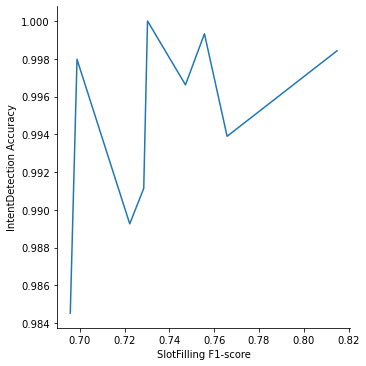

In [37]:
sns.relplot(data=tmp, x=('train_f1', 'slot'), y=('train_acc', 'intent'), kind='line')
plt.xlabel('SlotFilling F1-score')
plt.ylabel('IntentDetection Accuracy')
plt.savefig('plots/intent_and_slot_acc_snips.pdf', bbox_inches='tight')

In [31]:
tmp = history[history['epoch'] == N_EPOCH].drop(columns=['epoch']).copy()

tmp['score_type'] = tmp['model'].apply(lambda x: x.rsplit('_', 1)[-1])
tmp['alpha'] = tmp['model'].apply(lambda x: float(x.split('_')[0].split('=')[1]))

tmp = (
    tmp
    .drop(columns=['model'])
    .pivot(index=['alpha'], columns='score_type')
    .reset_index()
)

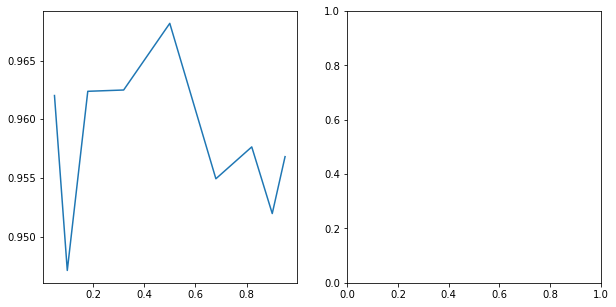

In [36]:
fix, axis = plt.subplots(ncols=2, figsize=(10, 5))
axis[0].plot(tmp['alpha'], tmp[('test_acc', 'intent')])
axis[0].

In [27]:
tmp = history.copy()

tmp['target'] = tmp['model'].apply(lambda x: x.rsplit('_', 1)[-1])
tmp['alpha'] = tmp['model'].apply(lambda x: x.split('_')[0].split('=')[1])

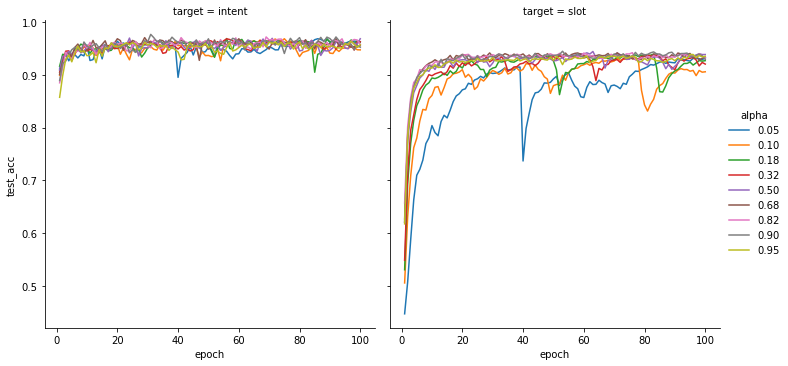

In [28]:
sns.relplot(data=tmp, x='epoch', y='test_acc', hue='alpha', col='target', kind='line')

# Token intent

In [27]:
class Net(nn.Module):
    def __init__(self, input_size, num_intent, hidden_size=50, lstm_layers=4):
        super(Net, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers 
        )
        
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * 2, num_intent),
#             nn.ReLU(),
            
#             nn.Linear(100, 200),
#             nn.ReLU(),
            
#             nn.Linear(200, num_intent)
        )
    
    def forward(self, X):
        X_lstm = self.__lstm(X)
        y = self.__fc(X_lstm[0])
        return y

In [28]:
net = Net(768, N_INTENT).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-6)

In [29]:
def eval_net(net):
    net.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct, total = 0, 0
        for inputs in d.test:
            text, intent, slot = inputs
            X, _ = d.encode(text)
            token_intent = torch.tile(intent.unsqueeze(1), [1, X.shape[1]]).to(device)
            slot = d.pad_slot(slot)

            y_intent = net(X)

            loss = criterion(y_intent.transpose(1, 2), token_intent)

            test_loss += loss.item()

            correct += (torch.mode(y_intent.argmax(axis=-1)).values.cpu() == intent).sum().item()
            total += intent.shape[0]

        print(f'Test loss: {test_loss / len(d.test):.4f}')
        print(f'Test acc: {correct / total:.4f}')
    net.train()
    return test_loss / len(d.test), correct / total

In [30]:
net.train()
history = defaultdict(list)
for i in trange(N_EPOCH):
    train_loss = 0.0
    correct, total = 0, 0
    for inputs in tqdm(d.train):
        text, intent, slot = inputs
        X, _ = d.encode(text)
        token_intent = torch.tile(intent.unsqueeze(1), [1, X.shape[1]]).to(device)
        slot = d.pad_slot(slot)
        
        y_intent = net(X)
        
        optimizer.zero_grad()
        loss = criterion(y_intent.transpose(1, 2), token_intent)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        correct += (torch.mode(y_intent.argmax(axis=-1)).values.cpu() == intent).sum().item()
        total += intent.shape[0]
    
    print(f'Epoch {i + 1} / {N_EPOCH}')
    print(f'Train loss: {train_loss / len(d.train):.4f}')
    print(f'Train acc: {correct / total:.4f}')
    
    test_loss, test_acc = eval_net(net)
    
    history['epoch'].append(i + 1)
    history['train_loss'].append(train_loss / len(d.train))
    history['train_acc'].append(correct / total)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 / 30
Train loss: 1.5526
Train acc: 0.5505
Test loss: 1.0392
Test acc: 0.6971


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 / 30
Train loss: 0.8126
Train acc: 0.8137
Test loss: 0.6449
Test acc: 0.8214


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 / 30
Train loss: 0.5659
Train acc: 0.8685
Test loss: 0.5463
Test acc: 0.8429


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 / 30
Train loss: 0.4543
Train acc: 0.8923
Test loss: 0.4250
Test acc: 0.8686


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 / 30
Train loss: 0.3875
Train acc: 0.9064
Test loss: 0.4314
Test acc: 0.8786


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 / 30
Train loss: 0.3452
Train acc: 0.9173
Test loss: 0.3384
Test acc: 0.9071


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 / 30
Train loss: 0.3090
Train acc: 0.9253
Test loss: 0.3670
Test acc: 0.8886


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 / 30
Train loss: 0.2876
Train acc: 0.9293
Test loss: 0.3179
Test acc: 0.9100


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 / 30
Train loss: 0.2732
Train acc: 0.9334
Test loss: 0.3237
Test acc: 0.9043


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 / 30
Train loss: 0.2575
Train acc: 0.9379
Test loss: 0.2981
Test acc: 0.9086


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 / 30
Train loss: 0.2453
Train acc: 0.9411
Test loss: 0.3238
Test acc: 0.9057


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 / 30
Train loss: 0.2342
Train acc: 0.9432
Test loss: 0.3095
Test acc: 0.9157


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 / 30
Train loss: 0.2264
Train acc: 0.9456
Test loss: 0.3103
Test acc: 0.9043


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 / 30
Train loss: 0.2136
Train acc: 0.9487
Test loss: 0.2840
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 / 30
Train loss: 0.2062
Train acc: 0.9513
Test loss: 0.2993
Test acc: 0.9100


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 / 30
Train loss: 0.2044
Train acc: 0.9534
Test loss: 0.2963
Test acc: 0.9157


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 / 30
Train loss: 0.1921
Train acc: 0.9539
Test loss: 0.2842
Test acc: 0.9157


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 / 30
Train loss: 0.1875
Train acc: 0.9531
Test loss: 0.2868
Test acc: 0.9214


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19 / 30
Train loss: 0.1855
Train acc: 0.9569
Test loss: 0.2848
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 / 30
Train loss: 0.1747
Train acc: 0.9567
Test loss: 0.2719
Test acc: 0.9200


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 / 30
Train loss: 0.1701
Train acc: 0.9591
Test loss: 0.2766
Test acc: 0.9243


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 / 30
Train loss: 0.1662
Train acc: 0.9590
Test loss: 0.2807
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 / 30
Train loss: 0.1607
Train acc: 0.9604
Test loss: 0.2718
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 / 30
Train loss: 0.1600
Train acc: 0.9615
Test loss: 0.2773
Test acc: 0.9171


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 / 30
Train loss: 0.1490
Train acc: 0.9637
Test loss: 0.2648
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 / 30
Train loss: 0.1521
Train acc: 0.9638
Test loss: 0.2636
Test acc: 0.9186


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 / 30
Train loss: 0.1477
Train acc: 0.9655
Test loss: 0.2740
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28 / 30
Train loss: 0.1432
Train acc: 0.9653
Test loss: 0.2780
Test acc: 0.9171


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 / 30
Train loss: 0.1405
Train acc: 0.9665
Test loss: 0.2813
Test acc: 0.9157


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 / 30
Train loss: 0.1367
Train acc: 0.9677
Test loss: 0.2710
Test acc: 0.9200


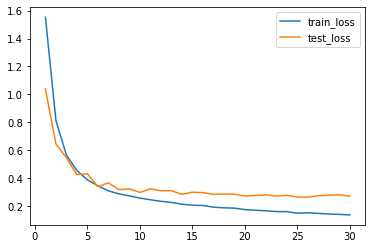

In [31]:
plt.plot(history['epoch'], history['train_loss'], label='train_loss')
plt.plot(history['epoch'], history['test_loss'], label='test_loss')
plt.legend()

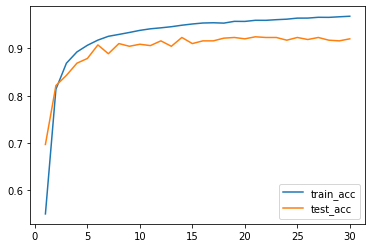

In [32]:
plt.plot(history['epoch'], history['train_acc'], label='train_acc')
plt.plot(history['epoch'], history['test_acc'], label='test_acc')
plt.legend()

In [34]:
net = Net(768, N_INTENT).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = Adam(net.parameters())

C:\Users\rusla\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [35]:
net.train()
for i in trange(N_EPOCH):
    train_loss = 0.0
    correct, total = 0, 0
    for inputs in tqdm(d.train):
        text, intent, slot = inputs
        X, _ = d.encode(text)
        slot = d.pad_slot(slot)
        token_intent = torch.tile(intent.unsqueeze(1), [1, X.shape[1]]).to(device)
        token_intent[slot > 0] = -1
        
        y_intent = net(X)
        
        optimizer.zero_grad()
        loss = criterion(y_intent.transpose(1, 2), token_intent)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        correct += (torch.mode(y_intent.argmax(axis=-1)).values.cpu() == intent).sum().item()
        total += intent.shape[0]
    
    print(f'Epoch {i + 1} / {N_EPOCH}')
    print(f'Train loss: {train_loss / len(d.train):.4f}')
    print(f'Acc: {correct / total:.4f}')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 / 50
Train loss: 1.0052
Acc: 0.6751


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 / 50
Train loss: 0.2614
Acc: 0.9356


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 / 50
Train loss: 0.1651
Acc: 0.9600


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 / 50
Train loss: 0.1161
Acc: 0.9723


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 / 50
Train loss: 0.0824
Acc: 0.9803


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 / 50
Train loss: 0.0600
Acc: 0.9875


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 / 50
Train loss: 0.0457
Acc: 0.9904


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 / 50
Train loss: 0.0357
Acc: 0.9937


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 / 50
Train loss: 0.0411
Acc: 0.9911


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 / 50
Train loss: 0.0214
Acc: 0.9965


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 / 50
Train loss: 0.0148
Acc: 0.9977


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 / 50
Train loss: 0.0099
Acc: 0.9989


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 / 50
Train loss: 0.0501
Acc: 0.9921


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 / 50
Train loss: 0.0091
Acc: 0.9991


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 / 50
Train loss: 0.0054
Acc: 0.9996


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 / 50
Train loss: 0.0038
Acc: 0.9995


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 / 50
Train loss: 0.0029
Acc: 0.9997


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 / 50
Train loss: 0.0022
Acc: 0.9998


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19 / 50
Train loss: 0.0020
Acc: 0.9999


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 / 50
Train loss: 0.0154
Acc: 0.9979


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 / 50
Train loss: 0.0024
Acc: 0.9998


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 / 50
Train loss: 0.0015
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 / 50
Train loss: 0.0019
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 / 50
Train loss: 0.0015
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 / 50
Train loss: 0.0010
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 / 50
Train loss: 0.0010
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 / 50
Train loss: 0.0008
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28 / 50
Train loss: 0.0008
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 / 50
Train loss: 0.0009
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 / 50
Train loss: 0.0007
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 / 50
Train loss: 0.0005
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 / 50
Train loss: 0.0005
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 / 50
Train loss: 0.0004
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 / 50
Train loss: 0.0005
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 / 50
Train loss: 0.0004
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 38 / 50
Train loss: 0.0004
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39 / 50
Train loss: 0.0021
Acc: 0.9999


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 / 50
Train loss: 0.0083
Acc: 0.9991


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41 / 50
Train loss: 0.0161
Acc: 0.9979


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42 / 50
Train loss: 0.0018
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43 / 50
Train loss: 0.0011
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44 / 50
Train loss: 0.0009
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46 / 50
Train loss: 0.0007
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 48 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49 / 50
Train loss: 0.0005
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50 / 50
Train loss: 0.0005
Acc: 1.0000


In [36]:
net.eval()
with torch.no_grad():
    test_loss = 0.0
    correct, total = 0, 0
    for inputs in tqdm(d.test):
        text, intent, slot = inputs
        X, _ = d.encode(text)
        token_intent = torch.tile(intent.unsqueeze(1), [1, X.shape[1]]).to(device)
        slot = d.pad_slot(slot)
        
        y_intent = net(X)
        
        loss = criterion(y_intent.transpose(1, 2), token_intent)

        test_loss += loss.item()
        
        correct += (torch.mode(y_intent.argmax(axis=-1)).values.cpu() == intent).sum().item()
        total += intent.shape[0]
    
    print(f'Test loss: {test_loss / len(d.test):.4f}')
    print(f'Acc: {correct / total:.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss: 0.4392
Acc: 0.9529


# Сравнение импакта от информации о другой задаче

In [29]:
d = DatasetManager('./data/atis_snips/snips/', batch_size=256, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
class SlotNet(nn.Module):
    def __init__(self, input_size, num_slots, hidden_size=200, lstm_layers=4):
        super(SlotNet, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers 
        )
        
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * 2, num_slots)
        )
        
    def forward(self, X):
        X_lstm = self.__lstm(X)
        y = self.__fc(X_lstm[0])
        return y

In [31]:
class SlotStep(BaseStep):
    def forward(self, X, slot, intent):
        y_slot = self.net(X)
        loss = self.criterion(y_slot.transpose(1, 2), slot.to(device))
        
        y_slot = y_slot.argmax(axis=-1)
        
        acc = accuracy(slot, y_slot)
        f1 = f1_score(
            y_true=slot.cpu().flatten(),
            y_pred=y_slot.cpu().flatten(), 
            labels=range(N_SLOT), average='macro',
            zero_division=1
        )
        
        return loss, acc, f1

In [32]:
class SlotWithIntentInfoStep(BaseStep):
    def forward(self, X, slot, intent):
        intent = (intent.unsqueeze(1) == torch.arange(N_INTENT).to(device))
        intent = (
            intent
            .unsqueeze(1)
            .tile((1, X.shape[1], 1))
        )

        X = torch.cat((X, intent.to(device)), dim=-1)
        y_slot = self.net(X)
        loss = self.criterion(y_slot.transpose(1, 2), slot.to(device))
        
        y_slot = y_slot.argmax(axis=-1)
        
        acc = accuracy(slot, y_slot)
        f1 = f1_score(
            y_true=slot.cpu().flatten(),
            y_pred=y_slot.cpu().flatten(), 
            labels=range(N_SLOT), average='macro',
            zero_division=1
        )
        
        return loss, acc, f1

In [33]:
class IntentNet(nn.Module):
    def __init__(self, input_size, num_intent, hidden_size=200, lstm_layers=4):
        super(IntentNet, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers        
        )
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * lstm_layers * 4, num_intent)
        )
    
    def forward(self, X):
        X_lstm = self.__lstm(X)
        return self.__fc(torch.cat(X_lstm[1]).transpose(0, 1).reshape(X.shape[0], -1))

In [34]:
class IntentStep(BaseStep):
    def forward(self, X, slot, intent):
        y_intent = self.net(X)
        loss = criterion(y_intent, intent.to(device))
        
        y_intent = y_intent.argmax(axis=-1)
        
        acc = accuracy(intent, y_intent)
        f1 = f1_score(intent.cpu(), y_intent.cpu(), average='macro', zero_division=1)
        
        return loss, acc, f1

In [35]:
class IntentWithSlotInfoStep(BaseStep):
    def forward(self, X, slot, intent):
        slot = (slot.unsqueeze(2) == torch.arange(len(d.slot_enc)).to(device))
        X = torch.cat((X, slot), dim=-1)
        
        y_intent = self.net(X)
        loss = criterion(y_intent, intent.to(device))
        
        y_intent = y_intent.argmax(axis=-1)
        
        acc = accuracy(intent, y_intent)
        f1 = f1_score(intent.cpu(), y_intent.cpu(), average='macro', zero_division=1)
        
        return loss, acc, f1

In [36]:
steppers = dict()

torch.manual_seed(seed)
net = SlotNet(768, len(d.slot_enc), 200, 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

steppers['slot_without_intent_info'] = SlotStep(net, criterion, optimizer)

torch.manual_seed(seed)
net = SlotNet(768 + N_INTENT, len(d.slot_enc), 200, 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

steppers['slot_with_intent_info'] = SlotWithIntentInfoStep(net, criterion, optimizer)

torch.manual_seed(seed)
net = IntentNet(768, N_INTENT, 200, 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

steppers['intent_without_slot_info'] = IntentStep(net, criterion, optimizer)

torch.manual_seed(seed)
net = IntentNet(768 + len(d.slot_enc), N_INTENT, 200, 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

steppers['intent_with_slot_info'] = IntentWithSlotInfoStep(net, criterion, optimizer)

In [37]:
history = train(steppers, N_EPOCH)
history.to_csv('history/additional_info_snips.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 / 100
------------------
slot_without_intent_info
Train loss: 2.6920
Train acc: 0.4302
Train f1: 0.0840
Test loss: 2.2455
Test acc: 0.4788
Test f1: 0.0997
------------------
slot_with_intent_info
Train loss: 2.5031
Train acc: 0.4424
Train f1: 0.0860
Test loss: 1.8571
Test acc: 0.5390
Test f1: 0.1143
------------------
intent_without_slot_info
Train loss: 1.1490
Train acc: 0.7438
Train f1: 0.7237
Test loss: 0.2793
Test acc: 0.9152
Test f1: 0.9131
------------------
intent_with_slot_info
Train loss: 1.1472
Train acc: 0.7420
Train f1: 0.7249
Test loss: 0.2870
Test acc: 0.9039
Test f1: 0.9052


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 / 100
------------------
slot_without_intent_info
Train loss: 1.8964
Train acc: 0.5385
Train f1: 0.1147
Test loss: 1.4401
Test acc: 0.6144
Test f1: 0.1731
------------------
slot_with_intent_info
Train loss: 1.4458
Train acc: 0.6244
Train f1: 0.1707
Test loss: 1.0274
Test acc: 0.7181
Test f1: 0.2685
------------------
intent_without_slot_info
Train loss: 0.1672
Train acc: 0.9452
Train f1: 0.9443
Test loss: 0.1788
Test acc: 0.9292
Test f1: 0.9278
------------------
intent_with_slot_info
Train loss: 0.1262
Train acc: 0.9602
Train f1: 0.9597
Test loss: 0.1789
Test acc: 0.9423
Test f1: 0.9394


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 / 100
------------------
slot_without_intent_info
Train loss: 1.1919
Train acc: 0.6766
Train f1: 0.2260
Test loss: 0.9219
Test acc: 0.7482
Test f1: 0.3407
------------------
slot_with_intent_info
Train loss: 0.8419
Train acc: 0.7605
Train f1: 0.3197
Test loss: 0.6615
Test acc: 0.8028
Test f1: 0.4011
------------------
intent_without_slot_info
Train loss: 0.1111
Train acc: 0.9624
Train f1: 0.9614
Test loss: 0.1633
Test acc: 0.9402
Test f1: 0.9419
------------------
intent_with_slot_info
Train loss: 0.0649
Train acc: 0.9796
Train f1: 0.9791
Test loss: 0.0918
Test acc: 0.9682
Test f1: 0.9680


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 / 100
------------------
slot_without_intent_info
Train loss: 0.8205
Train acc: 0.7678
Train f1: 0.3595
Test loss: 0.6922
Test acc: 0.7976
Test f1: 0.4121
------------------
slot_with_intent_info
Train loss: 0.5811
Train acc: 0.8275
Train f1: 0.4233
Test loss: 0.4857
Test acc: 0.8559
Test f1: 0.5090
------------------
intent_without_slot_info
Train loss: 0.0770
Train acc: 0.9735
Train f1: 0.9731
Test loss: 0.1735
Test acc: 0.9455
Test f1: 0.9457
------------------
intent_with_slot_info
Train loss: 0.0314
Train acc: 0.9902
Train f1: 0.9902
Test loss: 0.0674
Test acc: 0.9755
Test f1: 0.9746


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 / 100
------------------
slot_without_intent_info
Train loss: 0.6241
Train acc: 0.8181
Train f1: 0.4444
Test loss: 0.5602
Test acc: 0.8365
Test f1: 0.5181
------------------
slot_with_intent_info
Train loss: 0.4447
Train acc: 0.8664
Train f1: 0.4912
Test loss: 0.3892
Test acc: 0.8771
Test f1: 0.5587
------------------
intent_without_slot_info
Train loss: 0.0568
Train acc: 0.9811
Train f1: 0.9807
Test loss: 0.2402
Test acc: 0.9248
Test f1: 0.9263
------------------
intent_with_slot_info
Train loss: 0.0432
Train acc: 0.9860
Train f1: 0.9858
Test loss: 0.0410
Test acc: 0.9869
Test f1: 0.9869


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 / 100
------------------
slot_without_intent_info
Train loss: 0.4988
Train acc: 0.8518
Train f1: 0.5123
Test loss: 0.4969
Test acc: 0.8507
Test f1: 0.5669
------------------
slot_with_intent_info
Train loss: 0.3629
Train acc: 0.8875
Train f1: 0.5431
Test loss: 0.3555
Test acc: 0.8862
Test f1: 0.5941
------------------
intent_without_slot_info
Train loss: 0.0413
Train acc: 0.9851
Train f1: 0.9847
Test loss: 0.2134
Test acc: 0.9309
Test f1: 0.9301
------------------
intent_with_slot_info
Train loss: 0.0113
Train acc: 0.9976
Train f1: 0.9976
Test loss: 0.0294
Test acc: 0.9943
Test f1: 0.9945


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 / 100
------------------
slot_without_intent_info
Train loss: 0.4165
Train acc: 0.8751
Train f1: 0.5629
Test loss: 0.4373
Test acc: 0.8656
Test f1: 0.5785
------------------
slot_with_intent_info
Train loss: 0.3024
Train acc: 0.9058
Train f1: 0.5867
Test loss: 0.3170
Test acc: 0.8998
Test f1: 0.6204
------------------
intent_without_slot_info
Train loss: 0.0344
Train acc: 0.9881
Train f1: 0.9883
Test loss: 0.1508
Test acc: 0.9505
Test f1: 0.9491
------------------
intent_with_slot_info
Train loss: 0.0038
Train acc: 0.9994
Train f1: 0.9994
Test loss: 0.0295
Test acc: 0.9899
Test f1: 0.9897


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 / 100
------------------
slot_without_intent_info
Train loss: 0.3611
Train acc: 0.8908
Train f1: 0.5927
Test loss: 0.3817
Test acc: 0.8834
Test f1: 0.6122
------------------
slot_with_intent_info
Train loss: 0.2582
Train acc: 0.9186
Train f1: 0.6201
Test loss: 0.2828
Test acc: 0.9094
Test f1: 0.6361
------------------
intent_without_slot_info
Train loss: 0.0260
Train acc: 0.9909
Train f1: 0.9907
Test loss: 0.1510
Test acc: 0.9546
Test f1: 0.9553
------------------
intent_with_slot_info
Train loss: 0.0016
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.0349
Test acc: 0.9895
Test f1: 0.9895


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 / 100
------------------
slot_without_intent_info
Train loss: 0.3086
Train acc: 0.9059
Train f1: 0.6263
Test loss: 0.3481
Test acc: 0.8936
Test f1: 0.6433
------------------
slot_with_intent_info
Train loss: 0.2252
Train acc: 0.9284
Train f1: 0.6511
Test loss: 0.2911
Test acc: 0.9095
Test f1: 0.6550
------------------
intent_without_slot_info
Train loss: 0.0443
Train acc: 0.9846
Train f1: 0.9845
Test loss: 0.1545
Test acc: 0.9541
Test f1: 0.9555
------------------
intent_with_slot_info
Train loss: 0.0009
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0307
Test acc: 0.9909
Test f1: 0.9908


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 / 100
------------------
slot_without_intent_info
Train loss: 0.2685
Train acc: 0.9188
Train f1: 0.6467
Test loss: 0.3275
Test acc: 0.9050
Test f1: 0.6493
------------------
slot_with_intent_info
Train loss: 0.2089
Train acc: 0.9343
Train f1: 0.6612
Test loss: 0.2484
Test acc: 0.9236
Test f1: 0.7062
------------------
intent_without_slot_info
Train loss: 0.0374
Train acc: 0.9872
Train f1: 0.9873
Test loss: 0.1715
Test acc: 0.9585
Test f1: 0.9583
------------------
intent_with_slot_info
Train loss: 0.0006
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0406
Test acc: 0.9895
Test f1: 0.9888


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 / 100
------------------
slot_without_intent_info
Train loss: 0.2423
Train acc: 0.9250
Train f1: 0.6652
Test loss: 0.3359
Test acc: 0.9005
Test f1: 0.6768
------------------
slot_with_intent_info
Train loss: 0.1876
Train acc: 0.9409
Train f1: 0.6714
Test loss: 0.2389
Test acc: 0.9271
Test f1: 0.7016
------------------
intent_without_slot_info
Train loss: 0.0345
Train acc: 0.9874
Train f1: 0.9871
Test loss: 0.1831
Test acc: 0.9432
Test f1: 0.9436
------------------
intent_with_slot_info
Train loss: 0.0005
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0314
Test acc: 0.9878
Test f1: 0.9874


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 / 100
------------------
slot_without_intent_info
Train loss: 0.2253
Train acc: 0.9303
Train f1: 0.6728
Test loss: 0.3051
Test acc: 0.9090
Test f1: 0.6605
------------------
slot_with_intent_info
Train loss: 0.1810
Train acc: 0.9426
Train f1: 0.6849
Test loss: 0.2419
Test acc: 0.9257
Test f1: 0.6908
------------------
intent_without_slot_info
Train loss: 0.0236
Train acc: 0.9915
Train f1: 0.9915
Test loss: 0.1415
Test acc: 0.9563
Test f1: 0.9563
------------------
intent_with_slot_info
Train loss: 0.0004
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0305
Test acc: 0.9891
Test f1: 0.9882


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 / 100
------------------
slot_without_intent_info
Train loss: 0.1955
Train acc: 0.9399
Train f1: 0.6950
Test loss: 0.2995
Test acc: 0.9125
Test f1: 0.6965
------------------
slot_with_intent_info
Train loss: 0.1504
Train acc: 0.9523
Train f1: 0.7045
Test loss: 0.2363
Test acc: 0.9287
Test f1: 0.7254
------------------
intent_without_slot_info
Train loss: 0.0120
Train acc: 0.9956
Train f1: 0.9956
Test loss: 0.1852
Test acc: 0.9497
Test f1: 0.9501
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0301
Test acc: 0.9896
Test f1: 0.9889


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 / 100
------------------
slot_without_intent_info
Train loss: 0.1781
Train acc: 0.9452
Train f1: 0.7126
Test loss: 0.2855
Test acc: 0.9159
Test f1: 0.6883
------------------
slot_with_intent_info
Train loss: 0.1355
Train acc: 0.9571
Train f1: 0.7144
Test loss: 0.2268
Test acc: 0.9330
Test f1: 0.7168
------------------
intent_without_slot_info
Train loss: 0.0116
Train acc: 0.9958
Train f1: 0.9957
Test loss: 0.1838
Test acc: 0.9563
Test f1: 0.9571
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0311
Test acc: 0.9917
Test f1: 0.9910


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 / 100
------------------
slot_without_intent_info
Train loss: 0.1626
Train acc: 0.9500
Train f1: 0.7240
Test loss: 0.3105
Test acc: 0.9086
Test f1: 0.6981
------------------
slot_with_intent_info
Train loss: 0.1253
Train acc: 0.9607
Train f1: 0.7239
Test loss: 0.2417
Test acc: 0.9277
Test f1: 0.7561
------------------
intent_without_slot_info
Train loss: 0.0111
Train acc: 0.9965
Train f1: 0.9964
Test loss: 0.1878
Test acc: 0.9468
Test f1: 0.9464
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0335
Test acc: 0.9896
Test f1: 0.9895


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 / 100
------------------
slot_without_intent_info
Train loss: 0.1481
Train acc: 0.9540
Train f1: 0.7218
Test loss: 0.2888
Test acc: 0.9166
Test f1: 0.7169
------------------
slot_with_intent_info
Train loss: 0.1143
Train acc: 0.9637
Train f1: 0.7207
Test loss: 0.2200
Test acc: 0.9369
Test f1: 0.7207
------------------
intent_without_slot_info
Train loss: 0.0087
Train acc: 0.9973
Train f1: 0.9973
Test loss: 0.1571
Test acc: 0.9598
Test f1: 0.9615
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0373
Test acc: 0.9873
Test f1: 0.9873


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 / 100
------------------
slot_without_intent_info
Train loss: 0.1444
Train acc: 0.9544
Train f1: 0.7247
Test loss: 0.2786
Test acc: 0.9237
Test f1: 0.6878
------------------
slot_with_intent_info
Train loss: 0.1057
Train acc: 0.9667
Train f1: 0.7355
Test loss: 0.2332
Test acc: 0.9321
Test f1: 0.7448
------------------
intent_without_slot_info
Train loss: 0.0080
Train acc: 0.9976
Train f1: 0.9976
Test loss: 0.2270
Test acc: 0.9586
Test f1: 0.9601
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0379
Test acc: 0.9891
Test f1: 0.9889


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 / 100
------------------
slot_without_intent_info
Train loss: 0.1420
Train acc: 0.9551
Train f1: 0.7348
Test loss: 0.2910
Test acc: 0.9146
Test f1: 0.7116
------------------
slot_with_intent_info
Train loss: 0.1089
Train acc: 0.9653
Train f1: 0.7355
Test loss: 0.2224
Test acc: 0.9356
Test f1: 0.7468
------------------
intent_without_slot_info
Train loss: 0.0109
Train acc: 0.9968
Train f1: 0.9966
Test loss: 0.2536
Test acc: 0.9446
Test f1: 0.9450
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0392
Test acc: 0.9904
Test f1: 0.9903


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19 / 100
------------------
slot_without_intent_info
Train loss: 0.1318
Train acc: 0.9589
Train f1: 0.7281
Test loss: 0.3044
Test acc: 0.9156
Test f1: 0.7173
------------------
slot_with_intent_info
Train loss: 0.0996
Train acc: 0.9675
Train f1: 0.7466
Test loss: 0.2266
Test acc: 0.9373
Test f1: 0.7221
------------------
intent_without_slot_info
Train loss: 0.0612
Train acc: 0.9817
Train f1: 0.9815
Test loss: 0.1992
Test acc: 0.9405
Test f1: 0.9387
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0384
Test acc: 0.9869
Test f1: 0.9857


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 / 100
------------------
slot_without_intent_info
Train loss: 0.1178
Train acc: 0.9632
Train f1: 0.7436
Test loss: 0.2795
Test acc: 0.9228
Test f1: 0.7354
------------------
slot_with_intent_info
Train loss: 0.1070
Train acc: 0.9656
Train f1: 0.7372
Test loss: 0.2459
Test acc: 0.9325
Test f1: 0.7373
------------------
intent_without_slot_info
Train loss: 0.0349
Train acc: 0.9881
Train f1: 0.9878
Test loss: 0.2198
Test acc: 0.9479
Test f1: 0.9471
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0388
Test acc: 0.9925
Test f1: 0.9919


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 / 100
------------------
slot_without_intent_info
Train loss: 0.1116
Train acc: 0.9652
Train f1: 0.7379
Test loss: 0.2913
Test acc: 0.9169
Test f1: 0.7123
------------------
slot_with_intent_info
Train loss: 0.1075
Train acc: 0.9652
Train f1: 0.7447
Test loss: 0.2491
Test acc: 0.9349
Test f1: 0.7447
------------------
intent_without_slot_info
Train loss: 0.0432
Train acc: 0.9859
Train f1: 0.9858
Test loss: 0.2026
Test acc: 0.9503
Test f1: 0.9495
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0317
Test acc: 0.9917
Test f1: 0.9914


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 / 100
------------------
slot_without_intent_info
Train loss: 0.0962
Train acc: 0.9700
Train f1: 0.7481
Test loss: 0.3062
Test acc: 0.9184
Test f1: 0.7330
------------------
slot_with_intent_info
Train loss: 0.1029
Train acc: 0.9666
Train f1: 0.7441
Test loss: 0.2534
Test acc: 0.9319
Test f1: 0.7347
------------------
intent_without_slot_info
Train loss: 0.0486
Train acc: 0.9851
Train f1: 0.9851
Test loss: 0.2263
Test acc: 0.9463
Test f1: 0.9484
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0311
Test acc: 0.9912
Test f1: 0.9911


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 / 100
------------------
slot_without_intent_info
Train loss: 0.0910
Train acc: 0.9713
Train f1: 0.7578
Test loss: 0.3039
Test acc: 0.9177
Test f1: 0.7156
------------------
slot_with_intent_info
Train loss: 0.0933
Train acc: 0.9700
Train f1: 0.7576
Test loss: 0.2169
Test acc: 0.9398
Test f1: 0.7363
------------------
intent_without_slot_info
Train loss: 0.0190
Train acc: 0.9932
Train f1: 0.9931
Test loss: 0.2859
Test acc: 0.9452
Test f1: 0.9479
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0367
Test acc: 0.9904
Test f1: 0.9899


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 / 100
------------------
slot_without_intent_info
Train loss: 0.0871
Train acc: 0.9725
Train f1: 0.7474
Test loss: 0.2869
Test acc: 0.9274
Test f1: 0.7063
------------------
slot_with_intent_info
Train loss: 0.0777
Train acc: 0.9752
Train f1: 0.7512
Test loss: 0.2349
Test acc: 0.9389
Test f1: 0.7286
------------------
intent_without_slot_info
Train loss: 0.0075
Train acc: 0.9975
Train f1: 0.9975
Test loss: 0.1796
Test acc: 0.9568
Test f1: 0.9570
------------------
intent_with_slot_info
Train loss: 0.0006
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.0399
Test acc: 0.9869
Test f1: 0.9873


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 / 100
------------------
slot_without_intent_info
Train loss: 0.0809
Train acc: 0.9743
Train f1: 0.7516
Test loss: 0.2846
Test acc: 0.9231
Test f1: 0.7390
------------------
slot_with_intent_info
Train loss: 0.0697
Train acc: 0.9775
Train f1: 0.7568
Test loss: 0.2055
Test acc: 0.9451
Test f1: 0.7833
------------------
intent_without_slot_info
Train loss: 0.0064
Train acc: 0.9979
Train f1: 0.9978
Test loss: 0.3312
Test acc: 0.9414
Test f1: 0.9420
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0375
Test acc: 0.9899
Test f1: 0.9894


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 / 100
------------------
slot_without_intent_info
Train loss: 0.0776
Train acc: 0.9758
Train f1: 0.7479
Test loss: 0.3253
Test acc: 0.9217
Test f1: 0.6953
------------------
slot_with_intent_info
Train loss: 0.0613
Train acc: 0.9809
Train f1: 0.7781
Test loss: 0.2382
Test acc: 0.9404
Test f1: 0.7395
------------------
intent_without_slot_info
Train loss: 0.0064
Train acc: 0.9980
Train f1: 0.9980
Test loss: 0.3081
Test acc: 0.9439
Test f1: 0.9438
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0414
Test acc: 0.9911
Test f1: 0.9908


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 / 100
------------------
slot_without_intent_info
Train loss: 0.0835
Train acc: 0.9732
Train f1: 0.7455
Test loss: 0.2942
Test acc: 0.9249
Test f1: 0.7089
------------------
slot_with_intent_info
Train loss: 0.0609
Train acc: 0.9804
Train f1: 0.7796
Test loss: 0.2329
Test acc: 0.9413
Test f1: 0.7795
------------------
intent_without_slot_info
Train loss: 0.0028
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.2053
Test acc: 0.9575
Test f1: 0.9552
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0347
Test acc: 0.9930
Test f1: 0.9925


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28 / 100
------------------
slot_without_intent_info
Train loss: 0.0809
Train acc: 0.9738
Train f1: 0.7521
Test loss: 0.3041
Test acc: 0.9204
Test f1: 0.6920
------------------
slot_with_intent_info
Train loss: 0.0572
Train acc: 0.9819
Train f1: 0.7690
Test loss: 0.2371
Test acc: 0.9422
Test f1: 0.7657
------------------
intent_without_slot_info
Train loss: 0.0017
Train acc: 0.9995
Train f1: 0.9996
Test loss: 0.2365
Test acc: 0.9540
Test f1: 0.9542
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0344
Test acc: 0.9925
Test f1: 0.9925


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 / 100
------------------
slot_without_intent_info
Train loss: 0.0930
Train acc: 0.9709
Train f1: 0.7444
Test loss: 0.3480
Test acc: 0.9154
Test f1: 0.6798
------------------
slot_with_intent_info
Train loss: 0.0566
Train acc: 0.9817
Train f1: 0.7750
Test loss: 0.2358
Test acc: 0.9437
Test f1: 0.7648
------------------
intent_without_slot_info
Train loss: 0.0010
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2306
Test acc: 0.9602
Test f1: 0.9603
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0390
Test acc: 0.9904
Test f1: 0.9895


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 / 100
------------------
slot_without_intent_info
Train loss: 0.1018
Train acc: 0.9674
Train f1: 0.7554
Test loss: 0.2918
Test acc: 0.9191
Test f1: 0.6977
------------------
slot_with_intent_info
Train loss: 0.0655
Train acc: 0.9785
Train f1: 0.7647
Test loss: 0.2260
Test acc: 0.9424
Test f1: 0.7557
------------------
intent_without_slot_info
Train loss: 0.0004
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2388
Test acc: 0.9619
Test f1: 0.9624
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0335
Test acc: 0.9930
Test f1: 0.9931


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 / 100
------------------
slot_without_intent_info
Train loss: 0.0790
Train acc: 0.9744
Train f1: 0.7516
Test loss: 0.3119
Test acc: 0.9207
Test f1: 0.6951
------------------
slot_with_intent_info
Train loss: 0.0591
Train acc: 0.9807
Train f1: 0.7722
Test loss: 0.2390
Test acc: 0.9455
Test f1: 0.7434
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2566
Test acc: 0.9632
Test f1: 0.9625
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0393
Test acc: 0.9908
Test f1: 0.9902


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 / 100
------------------
slot_without_intent_info
Train loss: 0.0698
Train acc: 0.9775
Train f1: 0.7608
Test loss: 0.2948
Test acc: 0.9275
Test f1: 0.7140
------------------
slot_with_intent_info
Train loss: 0.0563
Train acc: 0.9816
Train f1: 0.7579
Test loss: 0.2270
Test acc: 0.9414
Test f1: 0.7244
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2593
Test acc: 0.9658
Test f1: 0.9670
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0435
Test acc: 0.9912
Test f1: 0.9907


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 / 100
------------------
slot_without_intent_info
Train loss: 0.0598
Train acc: 0.9813
Train f1: 0.7770
Test loss: 0.3043
Test acc: 0.9275
Test f1: 0.7472
------------------
slot_with_intent_info
Train loss: 0.0528
Train acc: 0.9830
Train f1: 0.7718
Test loss: 0.2331
Test acc: 0.9467
Test f1: 0.7742
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2524
Test acc: 0.9615
Test f1: 0.9620
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0430
Test acc: 0.9899
Test f1: 0.9891


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 / 100
------------------
slot_without_intent_info
Train loss: 0.0586
Train acc: 0.9810
Train f1: 0.7686
Test loss: 0.3083
Test acc: 0.9260
Test f1: 0.7442
------------------
slot_with_intent_info
Train loss: 0.0503
Train acc: 0.9835
Train f1: 0.7602
Test loss: 0.2420
Test acc: 0.9395
Test f1: 0.7055
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2353
Test acc: 0.9624
Test f1: 0.9626
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0377
Test acc: 0.9935
Test f1: 0.9937


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 / 100
------------------
slot_without_intent_info
Train loss: 0.0568
Train acc: 0.9816
Train f1: 0.7541
Test loss: 0.3128
Test acc: 0.9239
Test f1: 0.6915
------------------
slot_with_intent_info
Train loss: 0.0479
Train acc: 0.9844
Train f1: 0.7734
Test loss: 0.2647
Test acc: 0.9389
Test f1: 0.7203
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2367
Test acc: 0.9630
Test f1: 0.9637
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0413
Test acc: 0.9891
Test f1: 0.9891


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 / 100
------------------
slot_without_intent_info
Train loss: 0.0595
Train acc: 0.9805
Train f1: 0.7720
Test loss: 0.3184
Test acc: 0.9267
Test f1: 0.7406
------------------
slot_with_intent_info
Train loss: 0.0471
Train acc: 0.9848
Train f1: 0.7689
Test loss: 0.2494
Test acc: 0.9422
Test f1: 0.7338
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2364
Test acc: 0.9628
Test f1: 0.9636
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0396
Test acc: 0.9899
Test f1: 0.9893


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 / 100
------------------
slot_without_intent_info
Train loss: 0.0589
Train acc: 0.9809
Train f1: 0.7579
Test loss: 0.3291
Test acc: 0.9234
Test f1: 0.6985
------------------
slot_with_intent_info
Train loss: 0.0489
Train acc: 0.9841
Train f1: 0.7734
Test loss: 0.2531
Test acc: 0.9410
Test f1: 0.7624
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2482
Test acc: 0.9630
Test f1: 0.9615
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0426
Test acc: 0.9886
Test f1: 0.9884


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 38 / 100
------------------
slot_without_intent_info
Train loss: 0.0561
Train acc: 0.9815
Train f1: 0.7639
Test loss: 0.3456
Test acc: 0.9247
Test f1: 0.7013
------------------
slot_with_intent_info
Train loss: 0.0519
Train acc: 0.9825
Train f1: 0.7686
Test loss: 0.2722
Test acc: 0.9375
Test f1: 0.7576
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2324
Test acc: 0.9646
Test f1: 0.9642
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0435
Test acc: 0.9869
Test f1: 0.9860


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39 / 100
------------------
slot_without_intent_info
Train loss: 0.0561
Train acc: 0.9819
Train f1: 0.7550
Test loss: 0.3393
Test acc: 0.9285
Test f1: 0.7151
------------------
slot_with_intent_info
Train loss: 0.0735
Train acc: 0.9752
Train f1: 0.7654
Test loss: 0.2554
Test acc: 0.9376
Test f1: 0.7469
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2376
Test acc: 0.9651
Test f1: 0.9649
------------------
intent_with_slot_info
Train loss: 0.1468
Train acc: 0.9619
Train f1: 0.9605
Test loss: 0.1991
Test acc: 0.9363
Test f1: 0.9355


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 / 100
------------------
slot_without_intent_info
Train loss: 0.0529
Train acc: 0.9827
Train f1: 0.7622
Test loss: 0.3302
Test acc: 0.9252
Test f1: 0.6987
------------------
slot_with_intent_info
Train loss: 0.0524
Train acc: 0.9828
Train f1: 0.7745
Test loss: 0.2388
Test acc: 0.9425
Test f1: 0.7497
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2495
Test acc: 0.9623
Test f1: 0.9641
------------------
intent_with_slot_info
Train loss: 0.0782
Train acc: 0.9763
Train f1: 0.9762
Test loss: 0.0552
Test acc: 0.9791
Test f1: 0.9782


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41 / 100
------------------
slot_without_intent_info
Train loss: 0.0526
Train acc: 0.9830
Train f1: 0.7673
Test loss: 0.3431
Test acc: 0.9283
Test f1: 0.7285
------------------
slot_with_intent_info
Train loss: 0.0463
Train acc: 0.9848
Train f1: 0.7818
Test loss: 0.2683
Test acc: 0.9381
Test f1: 0.7357
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2338
Test acc: 0.9656
Test f1: 0.9658
------------------
intent_with_slot_info
Train loss: 0.0269
Train acc: 0.9917
Train f1: 0.9915
Test loss: 0.0131
Test acc: 0.9956
Test f1: 0.9957


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42 / 100
------------------
slot_without_intent_info
Train loss: 0.0468
Train acc: 0.9848
Train f1: 0.7809
Test loss: 0.3140
Test acc: 0.9291
Test f1: 0.6889
------------------
slot_with_intent_info
Train loss: 0.0562
Train acc: 0.9817
Train f1: 0.7696
Test loss: 0.2604
Test acc: 0.9429
Test f1: 0.7409
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2419
Test acc: 0.9650
Test f1: 0.9647
------------------
intent_with_slot_info
Train loss: 0.0115
Train acc: 0.9964
Train f1: 0.9964
Test loss: 0.0422
Test acc: 0.9834
Test f1: 0.9817


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43 / 100
------------------
slot_without_intent_info
Train loss: 0.0398
Train acc: 0.9872
Train f1: 0.7895
Test loss: 0.3530
Test acc: 0.9281
Test f1: 0.7252
------------------
slot_with_intent_info
Train loss: 0.0455
Train acc: 0.9850
Train f1: 0.7882
Test loss: 0.2678
Test acc: 0.9392
Test f1: 0.7635
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2426
Test acc: 0.9664
Test f1: 0.9665
------------------
intent_with_slot_info
Train loss: 0.0042
Train acc: 0.9989
Train f1: 0.9988
Test loss: 0.0164
Test acc: 0.9935
Test f1: 0.9930


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44 / 100
------------------
slot_without_intent_info
Train loss: 0.0392
Train acc: 0.9870
Train f1: 0.7708
Test loss: 0.3233
Test acc: 0.9306
Test f1: 0.7121
------------------
slot_with_intent_info
Train loss: 0.0581
Train acc: 0.9811
Train f1: 0.7632
Test loss: 0.2394
Test acc: 0.9413
Test f1: 0.7346
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2532
Test acc: 0.9642
Test f1: 0.9641
------------------
intent_with_slot_info
Train loss: 0.0015
Train acc: 0.9998
Train f1: 0.9999
Test loss: 0.0134
Test acc: 0.9948
Test f1: 0.9948


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45 / 100
------------------
slot_without_intent_info
Train loss: 0.0422
Train acc: 0.9861
Train f1: 0.7736
Test loss: 0.3506
Test acc: 0.9247
Test f1: 0.7029
------------------
slot_with_intent_info
Train loss: 0.0544
Train acc: 0.9820
Train f1: 0.7669
Test loss: 0.2658
Test acc: 0.9418
Test f1: 0.7282
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2509
Test acc: 0.9642
Test f1: 0.9640
------------------
intent_with_slot_info
Train loss: 0.0007
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0121
Test acc: 0.9948
Test f1: 0.9947


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46 / 100
------------------
slot_without_intent_info
Train loss: 0.0522
Train acc: 0.9830
Train f1: 0.7796
Test loss: 0.3566
Test acc: 0.9276
Test f1: 0.7446
------------------
slot_with_intent_info
Train loss: 0.0470
Train acc: 0.9846
Train f1: 0.7753
Test loss: 0.2526
Test acc: 0.9441
Test f1: 0.7226
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2594
Test acc: 0.9645
Test f1: 0.9655
------------------
intent_with_slot_info
Train loss: 0.0015
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.0118
Test acc: 0.9935
Test f1: 0.9934


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47 / 100
------------------
slot_without_intent_info
Train loss: 0.0555
Train acc: 0.9816
Train f1: 0.7796
Test loss: 0.3316
Test acc: 0.9261
Test f1: 0.7250
------------------
slot_with_intent_info
Train loss: 0.0460
Train acc: 0.9847
Train f1: 0.7775
Test loss: 0.2307
Test acc: 0.9459
Test f1: 0.7457
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2278
Test acc: 0.9646
Test f1: 0.9648
------------------
intent_with_slot_info
Train loss: 0.0004
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0163
Test acc: 0.9948
Test f1: 0.9947


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 48 / 100
------------------
slot_without_intent_info
Train loss: 0.0462
Train acc: 0.9848
Train f1: 0.7707
Test loss: 0.3482
Test acc: 0.9240
Test f1: 0.7234
------------------
slot_with_intent_info
Train loss: 0.0443
Train acc: 0.9855
Train f1: 0.7624
Test loss: 0.2520
Test acc: 0.9429
Test f1: 0.7636
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2460
Test acc: 0.9628
Test f1: 0.9618
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0153
Test acc: 0.9938
Test f1: 0.9940


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49 / 100
------------------
slot_without_intent_info
Train loss: 0.0455
Train acc: 0.9851
Train f1: 0.7667
Test loss: 0.3456
Test acc: 0.9262
Test f1: 0.7223
------------------
slot_with_intent_info
Train loss: 0.0338
Train acc: 0.9889
Train f1: 0.7666
Test loss: 0.2556
Test acc: 0.9439
Test f1: 0.7200
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2453
Test acc: 0.9642
Test f1: 0.9636
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0134
Test acc: 0.9935
Test f1: 0.9931


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50 / 100
------------------
slot_without_intent_info
Train loss: 0.0469
Train acc: 0.9846
Train f1: 0.7739
Test loss: 0.3406
Test acc: 0.9249
Test f1: 0.7143
------------------
slot_with_intent_info
Train loss: 0.0287
Train acc: 0.9910
Train f1: 0.7554
Test loss: 0.2625
Test acc: 0.9425
Test f1: 0.7746
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2477
Test acc: 0.9651
Test f1: 0.9651
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0126
Test acc: 0.9948
Test f1: 0.9945


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 51 / 100
------------------
slot_without_intent_info
Train loss: 0.0404
Train acc: 0.9869
Train f1: 0.7775
Test loss: 0.3413
Test acc: 0.9276
Test f1: 0.7180
------------------
slot_with_intent_info
Train loss: 0.0356
Train acc: 0.9883
Train f1: 0.7838
Test loss: 0.2602
Test acc: 0.9426
Test f1: 0.7625
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2495
Test acc: 0.9597
Test f1: 0.9601
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0138
Test acc: 0.9948
Test f1: 0.9952


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 52 / 100
------------------
slot_without_intent_info
Train loss: 0.0390
Train acc: 0.9875
Train f1: 0.7722
Test loss: 0.3302
Test acc: 0.9248
Test f1: 0.6899
------------------
slot_with_intent_info
Train loss: 0.0413
Train acc: 0.9865
Train f1: 0.7736
Test loss: 0.2596
Test acc: 0.9436
Test f1: 0.7509
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2411
Test acc: 0.9615
Test f1: 0.9606
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0136
Test acc: 0.9943
Test f1: 0.9939


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 53 / 100
------------------
slot_without_intent_info
Train loss: 0.0463
Train acc: 0.9849
Train f1: 0.7706
Test loss: 0.3467
Test acc: 0.9257
Test f1: 0.7356
------------------
slot_with_intent_info
Train loss: 0.0469
Train acc: 0.9846
Train f1: 0.7437
Test loss: 0.2660
Test acc: 0.9391
Test f1: 0.7005
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2307
Test acc: 0.9637
Test f1: 0.9630
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0137
Test acc: 0.9925
Test f1: 0.9910


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 54 / 100
------------------
slot_without_intent_info
Train loss: 0.0460
Train acc: 0.9848
Train f1: 0.7654
Test loss: 0.3529
Test acc: 0.9234
Test f1: 0.7150
------------------
slot_with_intent_info
Train loss: 0.0455
Train acc: 0.9848
Train f1: 0.7437
Test loss: 0.2635
Test acc: 0.9420
Test f1: 0.7483
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2326
Test acc: 0.9642
Test f1: 0.9649
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0165
Test acc: 0.9916
Test f1: 0.9915


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 55 / 100
------------------
slot_without_intent_info
Train loss: 0.0540
Train acc: 0.9822
Train f1: 0.7617
Test loss: 0.3649
Test acc: 0.9267
Test f1: 0.6777
------------------
slot_with_intent_info
Train loss: 0.0368
Train acc: 0.9879
Train f1: 0.7694
Test loss: 0.2653
Test acc: 0.9440
Test f1: 0.7328
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2324
Test acc: 0.9642
Test f1: 0.9627
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0177
Test acc: 0.9921
Test f1: 0.9922


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 56 / 100
------------------
slot_without_intent_info
Train loss: 0.0548
Train acc: 0.9821
Train f1: 0.7620
Test loss: 0.3360
Test acc: 0.9278
Test f1: 0.7231
------------------
slot_with_intent_info
Train loss: 0.0308
Train acc: 0.9898
Train f1: 0.7732
Test loss: 0.2602
Test acc: 0.9420
Test f1: 0.7253
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2236
Test acc: 0.9646
Test f1: 0.9652
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0140
Test acc: 0.9930
Test f1: 0.9929


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 57 / 100
------------------
slot_without_intent_info
Train loss: 0.0491
Train acc: 0.9839
Train f1: 0.7567
Test loss: 0.3427
Test acc: 0.9259
Test f1: 0.7493
------------------
slot_with_intent_info
Train loss: 0.0327
Train acc: 0.9894
Train f1: 0.7417
Test loss: 0.2696
Test acc: 0.9418
Test f1: 0.7449
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2382
Test acc: 0.9633
Test f1: 0.9634
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0140
Test acc: 0.9925
Test f1: 0.9921


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 58 / 100
------------------
slot_without_intent_info
Train loss: 0.0476
Train acc: 0.9845
Train f1: 0.7776
Test loss: 0.3477
Test acc: 0.9288
Test f1: 0.6973
------------------
slot_with_intent_info
Train loss: 0.0340
Train acc: 0.9888
Train f1: 0.7752
Test loss: 0.2600
Test acc: 0.9467
Test f1: 0.7611
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2513
Test acc: 0.9637
Test f1: 0.9642
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0117
Test acc: 0.9930
Test f1: 0.9926


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 59 / 100
------------------
slot_without_intent_info
Train loss: 0.0438
Train acc: 0.9855
Train f1: 0.7725
Test loss: 0.3624
Test acc: 0.9245
Test f1: 0.6912
------------------
slot_with_intent_info
Train loss: 0.0384
Train acc: 0.9869
Train f1: 0.7658
Test loss: 0.2725
Test acc: 0.9415
Test f1: 0.7376
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2537
Test acc: 0.9618
Test f1: 0.9622
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0136
Test acc: 0.9930
Test f1: 0.9927


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 60 / 100
------------------
slot_without_intent_info
Train loss: 0.0403
Train acc: 0.9867
Train f1: 0.7713
Test loss: 0.3257
Test acc: 0.9328
Test f1: 0.7022
------------------
slot_with_intent_info
Train loss: 0.0374
Train acc: 0.9879
Train f1: 0.7711
Test loss: 0.2816
Test acc: 0.9391
Test f1: 0.7448
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2358
Test acc: 0.9651
Test f1: 0.9655
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0197
Test acc: 0.9930
Test f1: 0.9929


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 61 / 100
------------------
slot_without_intent_info
Train loss: 0.0529
Train acc: 0.9826
Train f1: 0.7675
Test loss: 0.3595
Test acc: 0.9253
Test f1: 0.7307
------------------
slot_with_intent_info
Train loss: 0.0362
Train acc: 0.9882
Train f1: 0.7766
Test loss: 0.2792
Test acc: 0.9383
Test f1: 0.7550
------------------
intent_without_slot_info
Train loss: 0.1279
Train acc: 0.9669
Train f1: 0.9664
Test loss: 0.5659
Test acc: 0.8575
Test f1: 0.8575
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0124
Test acc: 0.9935
Test f1: 0.9928


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 62 / 100
------------------
slot_without_intent_info
Train loss: 0.0521
Train acc: 0.9828
Train f1: 0.7696
Test loss: 0.3748
Test acc: 0.9226
Test f1: 0.6878
------------------
slot_with_intent_info
Train loss: 0.0409
Train acc: 0.9860
Train f1: 0.7784
Test loss: 0.2753
Test acc: 0.9365
Test f1: 0.7360
------------------
intent_without_slot_info
Train loss: 0.2671
Train acc: 0.9311
Train f1: 0.9304
Test loss: 0.2643
Test acc: 0.9222
Test f1: 0.9217
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0178
Test acc: 0.9903
Test f1: 0.9897


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 63 / 100
------------------
slot_without_intent_info
Train loss: 0.0462
Train acc: 0.9848
Train f1: 0.7558
Test loss: 0.3618
Test acc: 0.9248
Test f1: 0.6868
------------------
slot_with_intent_info
Train loss: 0.0532
Train acc: 0.9822
Train f1: 0.7754
Test loss: 0.2789
Test acc: 0.9398
Test f1: 0.7069
------------------
intent_without_slot_info
Train loss: 0.1084
Train acc: 0.9665
Train f1: 0.9661
Test loss: 0.2447
Test acc: 0.9302
Test f1: 0.9293
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0162
Test acc: 0.9912
Test f1: 0.9910


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 64 / 100
------------------
slot_without_intent_info
Train loss: 0.0429
Train acc: 0.9858
Train f1: 0.7760
Test loss: 0.3794
Test acc: 0.9207
Test f1: 0.6871
------------------
slot_with_intent_info
Train loss: 0.0439
Train acc: 0.9856
Train f1: 0.7753
Test loss: 0.2613
Test acc: 0.9418
Test f1: 0.7177
------------------
intent_without_slot_info
Train loss: 0.0676
Train acc: 0.9784
Train f1: 0.9778
Test loss: 0.2155
Test acc: 0.9430
Test f1: 0.9425
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0180
Test acc: 0.9898
Test f1: 0.9890


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 65 / 100
------------------
slot_without_intent_info
Train loss: 0.0515
Train acc: 0.9826
Train f1: 0.7531
Test loss: 0.3744
Test acc: 0.9245
Test f1: 0.7306
------------------
slot_with_intent_info
Train loss: 0.0374
Train acc: 0.9877
Train f1: 0.7833
Test loss: 0.2720
Test acc: 0.9418
Test f1: 0.7622
------------------
intent_without_slot_info
Train loss: 0.0572
Train acc: 0.9808
Train f1: 0.9807
Test loss: 0.1964
Test acc: 0.9536
Test f1: 0.9540
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0157
Test acc: 0.9922
Test f1: 0.9918


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 66 / 100
------------------
slot_without_intent_info
Train loss: 0.0435
Train acc: 0.9858
Train f1: 0.7729
Test loss: 0.3296
Test acc: 0.9312
Test f1: 0.6873
------------------
slot_with_intent_info
Train loss: 0.0340
Train acc: 0.9887
Train f1: 0.7788
Test loss: 0.2677
Test acc: 0.9433
Test f1: 0.7296
------------------
intent_without_slot_info
Train loss: 0.0268
Train acc: 0.9904
Train f1: 0.9903
Test loss: 0.1691
Test acc: 0.9559
Test f1: 0.9551
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0180
Test acc: 0.9938
Test f1: 0.9929


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 67 / 100
------------------
slot_without_intent_info
Train loss: 0.0431
Train acc: 0.9855
Train f1: 0.7640
Test loss: 0.3166
Test acc: 0.9310
Test f1: 0.7005
------------------
slot_with_intent_info
Train loss: 0.0324
Train acc: 0.9892
Train f1: 0.7733
Test loss: 0.2771
Test acc: 0.9430
Test f1: 0.7738
------------------
intent_without_slot_info
Train loss: 0.0205
Train acc: 0.9943
Train f1: 0.9943
Test loss: 0.1779
Test acc: 0.9630
Test f1: 0.9628
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0145
Test acc: 0.9930
Test f1: 0.9930


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 68 / 100
------------------
slot_without_intent_info
Train loss: 0.0374
Train acc: 0.9876
Train f1: 0.7655
Test loss: 0.3084
Test acc: 0.9352
Test f1: 0.7317
------------------
slot_with_intent_info
Train loss: 0.0319
Train acc: 0.9894
Train f1: 0.7809
Test loss: 0.2724
Test acc: 0.9436
Test f1: 0.7746
------------------
intent_without_slot_info
Train loss: 0.0088
Train acc: 0.9971
Train f1: 0.9970
Test loss: 0.2046
Test acc: 0.9576
Test f1: 0.9581
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0143
Test acc: 0.9912
Test f1: 0.9909


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 69 / 100
------------------
slot_without_intent_info
Train loss: 0.0351
Train acc: 0.9889
Train f1: 0.7735
Test loss: 0.3624
Test acc: 0.9278
Test f1: 0.7169
------------------
slot_with_intent_info
Train loss: 0.0330
Train acc: 0.9890
Train f1: 0.7843
Test loss: 0.2868
Test acc: 0.9422
Test f1: 0.7464
------------------
intent_without_slot_info
Train loss: 0.0051
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.2012
Test acc: 0.9618
Test f1: 0.9636
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0130
Test acc: 0.9930
Test f1: 0.9926


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 70 / 100
------------------
slot_without_intent_info
Train loss: 0.0350
Train acc: 0.9888
Train f1: 0.7661
Test loss: 0.3781
Test acc: 0.9261
Test f1: 0.7166
------------------
slot_with_intent_info
Train loss: 0.0286
Train acc: 0.9907
Train f1: 0.7909
Test loss: 0.2718
Test acc: 0.9429
Test f1: 0.7530
------------------
intent_without_slot_info
Train loss: 0.0024
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.2059
Test acc: 0.9541
Test f1: 0.9546
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0120
Test acc: 0.9938
Test f1: 0.9937


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 71 / 100
------------------
slot_without_intent_info
Train loss: 0.0478
Train acc: 0.9842
Train f1: 0.7639
Test loss: 0.3769
Test acc: 0.9207
Test f1: 0.6608
------------------
slot_with_intent_info
Train loss: 0.0245
Train acc: 0.9918
Train f1: 0.7870
Test loss: 0.2803
Test acc: 0.9437
Test f1: 0.7328
------------------
intent_without_slot_info
Train loss: 0.0016
Train acc: 0.9997
Train f1: 0.9997
Test loss: 0.1796
Test acc: 0.9594
Test f1: 0.9601
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0119
Test acc: 0.9948
Test f1: 0.9945


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 72 / 100
------------------
slot_without_intent_info
Train loss: 0.0491
Train acc: 0.9835
Train f1: 0.7744
Test loss: 0.3796
Test acc: 0.9228
Test f1: 0.6970
------------------
slot_with_intent_info
Train loss: 0.0221
Train acc: 0.9929
Train f1: 0.7920
Test loss: 0.2559
Test acc: 0.9492
Test f1: 0.7480
------------------
intent_without_slot_info
Train loss: 0.0014
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2148
Test acc: 0.9575
Test f1: 0.9576
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0140
Test acc: 0.9930
Test f1: 0.9925


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 73 / 100
------------------
slot_without_intent_info
Train loss: 0.0505
Train acc: 0.9834
Train f1: 0.7499
Test loss: 0.3505
Test acc: 0.9290
Test f1: 0.7261
------------------
slot_with_intent_info
Train loss: 0.0240
Train acc: 0.9922
Train f1: 0.7801
Test loss: 0.2987
Test acc: 0.9404
Test f1: 0.7372
------------------
intent_without_slot_info
Train loss: 0.0021
Train acc: 0.9997
Train f1: 0.9997
Test loss: 0.2241
Test acc: 0.9578
Test f1: 0.9574
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0158
Test acc: 0.9934
Test f1: 0.9930


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 74 / 100
------------------
slot_without_intent_info
Train loss: 0.0427
Train acc: 0.9863
Train f1: 0.7677
Test loss: 0.3449
Test acc: 0.9271
Test f1: 0.7241
------------------
slot_with_intent_info
Train loss: 0.0295
Train acc: 0.9901
Train f1: 0.7637
Test loss: 0.2956
Test acc: 0.9405
Test f1: 0.7231
------------------
intent_without_slot_info
Train loss: 0.0010
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2258
Test acc: 0.9554
Test f1: 0.9556
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0143
Test acc: 0.9938
Test f1: 0.9937


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 75 / 100
------------------
slot_without_intent_info
Train loss: 0.0389
Train acc: 0.9868
Train f1: 0.7714
Test loss: 0.3685
Test acc: 0.9235
Test f1: 0.7266
------------------
slot_with_intent_info
Train loss: 0.0329
Train acc: 0.9894
Train f1: 0.7627
Test loss: 0.2858
Test acc: 0.9426
Test f1: 0.7384
------------------
intent_without_slot_info
Train loss: 0.0009
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2180
Test acc: 0.9593
Test f1: 0.9596
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0138
Test acc: 0.9952
Test f1: 0.9942


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 76 / 100
------------------
slot_without_intent_info
Train loss: 0.0339
Train acc: 0.9889
Train f1: 0.7772
Test loss: 0.3511
Test acc: 0.9258
Test f1: 0.7171
------------------
slot_with_intent_info
Train loss: 0.0416
Train acc: 0.9861
Train f1: 0.7465
Test loss: 0.2746
Test acc: 0.9408
Test f1: 0.7118
------------------
intent_without_slot_info
Train loss: 0.0013
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2611
Test acc: 0.9572
Test f1: 0.9567
------------------
intent_with_slot_info
Train loss: 0.0330
Train acc: 0.9904
Train f1: 0.9906
Test loss: 0.2919
Test acc: 0.9419
Test f1: 0.9395


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 77 / 100
------------------
slot_without_intent_info
Train loss: 0.0295
Train acc: 0.9908
Train f1: 0.7874
Test loss: 0.3400
Test acc: 0.9294
Test f1: 0.7216
------------------
slot_with_intent_info
Train loss: 0.0389
Train acc: 0.9870
Train f1: 0.7591
Test loss: 0.3262
Test acc: 0.9331
Test f1: 0.7285
------------------
intent_without_slot_info
Train loss: 0.0009
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2333
Test acc: 0.9576
Test f1: 0.9575
------------------
intent_with_slot_info
Train loss: 0.1052
Train acc: 0.9736
Train f1: 0.9733
Test loss: 0.0996
Test acc: 0.9778
Test f1: 0.9778


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 78 / 100
------------------
slot_without_intent_info
Train loss: 0.0277
Train acc: 0.9907
Train f1: 0.7828
Test loss: 0.3575
Test acc: 0.9285
Test f1: 0.7220
------------------
slot_with_intent_info
Train loss: 0.0398
Train acc: 0.9871
Train f1: 0.7374
Test loss: 0.2880
Test acc: 0.9413
Test f1: 0.7329
------------------
intent_without_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2149
Test acc: 0.9576
Test f1: 0.9583
------------------
intent_with_slot_info
Train loss: 0.0374
Train acc: 0.9901
Train f1: 0.9895
Test loss: 0.0759
Test acc: 0.9812
Test f1: 0.9808


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 79 / 100
------------------
slot_without_intent_info
Train loss: 0.0271
Train acc: 0.9911
Train f1: 0.7693
Test loss: 0.3469
Test acc: 0.9307
Test f1: 0.7052
------------------
slot_with_intent_info
Train loss: 0.0331
Train acc: 0.9891
Train f1: 0.7670
Test loss: 0.2748
Test acc: 0.9436
Test f1: 0.7065
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2282
Test acc: 0.9575
Test f1: 0.9592
------------------
intent_with_slot_info
Train loss: 0.0183
Train acc: 0.9944
Train f1: 0.9943
Test loss: 0.0153
Test acc: 0.9943
Test f1: 0.9942


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80 / 100
------------------
slot_without_intent_info
Train loss: 0.0309
Train acc: 0.9901
Train f1: 0.7517
Test loss: 0.3907
Test acc: 0.9215
Test f1: 0.6997
------------------
slot_with_intent_info
Train loss: 0.0425
Train acc: 0.9860
Train f1: 0.7619
Test loss: 0.2923
Test acc: 0.9364
Test f1: 0.7129
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2427
Test acc: 0.9576
Test f1: 0.9571
------------------
intent_with_slot_info
Train loss: 0.0133
Train acc: 0.9965
Train f1: 0.9965
Test loss: 0.0742
Test acc: 0.9825
Test f1: 0.9826


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81 / 100
------------------
slot_without_intent_info
Train loss: 0.0422
Train acc: 0.9861
Train f1: 0.7537
Test loss: 0.3739
Test acc: 0.9208
Test f1: 0.6992
------------------
slot_with_intent_info
Train loss: 0.0490
Train acc: 0.9833
Train f1: 0.7314
Test loss: 0.2804
Test acc: 0.9425
Test f1: 0.6663
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2331
Test acc: 0.9581
Test f1: 0.9576
------------------
intent_with_slot_info
Train loss: 0.0083
Train acc: 0.9973
Train f1: 0.9972
Test loss: 0.0304
Test acc: 0.9917
Test f1: 0.9914


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82 / 100
------------------
slot_without_intent_info
Train loss: 0.0369
Train acc: 0.9875
Train f1: 0.7656
Test loss: 0.3776
Test acc: 0.9228
Test f1: 0.6920
------------------
slot_with_intent_info
Train loss: 0.0339
Train acc: 0.9887
Train f1: 0.7339
Test loss: 0.3092
Test acc: 0.9375
Test f1: 0.7788
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2340
Test acc: 0.9559
Test f1: 0.9543
------------------
intent_with_slot_info
Train loss: 0.0169
Train acc: 0.9951
Train f1: 0.9951
Test loss: 0.0164
Test acc: 0.9930
Test f1: 0.9929


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83 / 100
------------------
slot_without_intent_info
Train loss: 0.0386
Train acc: 0.9872
Train f1: 0.7496
Test loss: 0.3578
Test acc: 0.9315
Test f1: 0.7180
------------------
slot_with_intent_info
Train loss: 0.0290
Train acc: 0.9902
Train f1: 0.7805
Test loss: 0.2574
Test acc: 0.9463
Test f1: 0.7067
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2488
Test acc: 0.9545
Test f1: 0.9537
------------------
intent_with_slot_info
Train loss: 0.0191
Train acc: 0.9952
Train f1: 0.9951
Test loss: 0.0203
Test acc: 0.9934
Test f1: 0.9937


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84 / 100
------------------
slot_without_intent_info
Train loss: 0.0376
Train acc: 0.9874
Train f1: 0.7578
Test loss: 0.3731
Test acc: 0.9273
Test f1: 0.6904
------------------
slot_with_intent_info
Train loss: 0.0245
Train acc: 0.9919
Train f1: 0.7640
Test loss: 0.2844
Test acc: 0.9427
Test f1: 0.7148
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2419
Test acc: 0.9550
Test f1: 0.9532
------------------
intent_with_slot_info
Train loss: 0.0110
Train acc: 0.9967
Train f1: 0.9966
Test loss: 0.0120
Test acc: 0.9956
Test f1: 0.9953


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 85 / 100
------------------
slot_without_intent_info
Train loss: 0.0624
Train acc: 0.9798
Train f1: 0.7450
Test loss: 0.3601
Test acc: 0.9217
Test f1: 0.7009
------------------
slot_with_intent_info
Train loss: 0.0246
Train acc: 0.9916
Train f1: 0.7780
Test loss: 0.2974
Test acc: 0.9413
Test f1: 0.7217
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2478
Test acc: 0.9567
Test f1: 0.9568
------------------
intent_with_slot_info
Train loss: 0.0048
Train acc: 0.9983
Train f1: 0.9983
Test loss: 0.0211
Test acc: 0.9930
Test f1: 0.9932


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 86 / 100
------------------
slot_without_intent_info
Train loss: 0.0548
Train acc: 0.9816
Train f1: 0.7606
Test loss: 0.3507
Test acc: 0.9259
Test f1: 0.7094
------------------
slot_with_intent_info
Train loss: 0.0359
Train acc: 0.9886
Train f1: 0.7551
Test loss: 0.2658
Test acc: 0.9433
Test f1: 0.7131
------------------
intent_without_slot_info
Train loss: 0.0042
Train acc: 0.9987
Train f1: 0.9987
Test loss: 0.2801
Test acc: 0.9560
Test f1: 0.9568
------------------
intent_with_slot_info
Train loss: 0.0032
Train acc: 0.9992
Train f1: 0.9992
Test loss: 0.0299
Test acc: 0.9904
Test f1: 0.9900


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 87 / 100
------------------
slot_without_intent_info
Train loss: 0.0459
Train acc: 0.9844
Train f1: 0.7509
Test loss: 0.3619
Test acc: 0.9221
Test f1: 0.6858
------------------
slot_with_intent_info
Train loss: 0.0323
Train acc: 0.9893
Train f1: 0.7458
Test loss: 0.2897
Test acc: 0.9368
Test f1: 0.6826
------------------
intent_without_slot_info
Train loss: 0.0175
Train acc: 0.9942
Train f1: 0.9941
Test loss: 0.3042
Test acc: 0.9462
Test f1: 0.9438
------------------
intent_with_slot_info
Train loss: 0.0025
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.0403
Test acc: 0.9917
Test f1: 0.9914


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88 / 100
------------------
slot_without_intent_info
Train loss: 0.0420
Train acc: 0.9866
Train f1: 0.7798
Test loss: 0.3186
Test acc: 0.9341
Test f1: 0.7139
------------------
slot_with_intent_info
Train loss: 0.0353
Train acc: 0.9882
Train f1: 0.7422
Test loss: 0.2765
Test acc: 0.9427
Test f1: 0.7071
------------------
intent_without_slot_info
Train loss: 0.0658
Train acc: 0.9810
Train f1: 0.9807
Test loss: 0.3840
Test acc: 0.9214
Test f1: 0.9219
------------------
intent_with_slot_info
Train loss: 0.0039
Train acc: 0.9986
Train f1: 0.9985
Test loss: 0.0263
Test acc: 0.9904
Test f1: 0.9906


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89 / 100
------------------
slot_without_intent_info
Train loss: 0.0395
Train acc: 0.9871
Train f1: 0.7667
Test loss: 0.3607
Test acc: 0.9250
Test f1: 0.7237
------------------
slot_with_intent_info
Train loss: 0.0304
Train acc: 0.9901
Train f1: 0.7374
Test loss: 0.3342
Test acc: 0.9367
Test f1: 0.6977
------------------
intent_without_slot_info
Train loss: 0.0948
Train acc: 0.9734
Train f1: 0.9729
Test loss: 0.3131
Test acc: 0.9290
Test f1: 0.9270
------------------
intent_with_slot_info
Train loss: 0.0025
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.0276
Test acc: 0.9938
Test f1: 0.9938


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90 / 100
------------------
slot_without_intent_info
Train loss: 0.0395
Train acc: 0.9871
Train f1: 0.7772
Test loss: 0.3410
Test acc: 0.9263
Test f1: 0.7185
------------------
slot_with_intent_info
Train loss: 0.0352
Train acc: 0.9884
Train f1: 0.7455
Test loss: 0.2851
Test acc: 0.9423
Test f1: 0.7085
------------------
intent_without_slot_info
Train loss: 0.0657
Train acc: 0.9819
Train f1: 0.9814
Test loss: 0.2806
Test acc: 0.9459
Test f1: 0.9466
------------------
intent_with_slot_info
Train loss: 0.0026
Train acc: 0.9994
Train f1: 0.9994
Test loss: 0.0399
Test acc: 0.9904
Test f1: 0.9900


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91 / 100
------------------
slot_without_intent_info
Train loss: 0.0332
Train acc: 0.9892
Train f1: 0.7939
Test loss: 0.3946
Test acc: 0.9207
Test f1: 0.6844
------------------
slot_with_intent_info
Train loss: 0.0277
Train acc: 0.9908
Train f1: 0.7257
Test loss: 0.2839
Test acc: 0.9443
Test f1: 0.7229
------------------
intent_without_slot_info
Train loss: 0.0738
Train acc: 0.9772
Train f1: 0.9767
Test loss: 0.2452
Test acc: 0.9463
Test f1: 0.9454
------------------
intent_with_slot_info
Train loss: 0.0038
Train acc: 0.9993
Train f1: 0.9993
Test loss: 0.0223
Test acc: 0.9930
Test f1: 0.9930


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92 / 100
------------------
slot_without_intent_info
Train loss: 0.0341
Train acc: 0.9887
Train f1: 0.7725
Test loss: 0.4098
Test acc: 0.9222
Test f1: 0.6734
------------------
slot_with_intent_info
Train loss: 0.0403
Train acc: 0.9870
Train f1: 0.7496
Test loss: 0.3194
Test acc: 0.9336
Test f1: 0.7185
------------------
intent_without_slot_info
Train loss: 0.0286
Train acc: 0.9892
Train f1: 0.9891
Test loss: 0.2422
Test acc: 0.9466
Test f1: 0.9468
------------------
intent_with_slot_info
Train loss: 0.0029
Train acc: 0.9989
Train f1: 0.9989
Test loss: 0.0313
Test acc: 0.9943
Test f1: 0.9942


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 93 / 100
------------------
slot_without_intent_info
Train loss: 0.0384
Train acc: 0.9872
Train f1: 0.7609
Test loss: 0.4071
Test acc: 0.9201
Test f1: 0.6920
------------------
slot_with_intent_info
Train loss: 0.0673
Train acc: 0.9783
Train f1: 0.7206
Test loss: 0.2857
Test acc: 0.9384
Test f1: 0.7299
------------------
intent_without_slot_info
Train loss: 0.0142
Train acc: 0.9955
Train f1: 0.9954
Test loss: 0.2727
Test acc: 0.9471
Test f1: 0.9479
------------------
intent_with_slot_info
Train loss: 0.0042
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.0416
Test acc: 0.9917
Test f1: 0.9920


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 94 / 100
------------------
slot_without_intent_info
Train loss: 0.0349
Train acc: 0.9891
Train f1: 0.7801
Test loss: 0.3879
Test acc: 0.9235
Test f1: 0.7000
------------------
slot_with_intent_info
Train loss: 0.0487
Train acc: 0.9842
Train f1: 0.7387
Test loss: 0.2651
Test acc: 0.9402
Test f1: 0.7303
------------------
intent_without_slot_info
Train loss: 0.0076
Train acc: 0.9980
Train f1: 0.9981
Test loss: 0.3036
Test acc: 0.9426
Test f1: 0.9436
------------------
intent_with_slot_info
Train loss: 0.0036
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.0437
Test acc: 0.9895
Test f1: 0.9881


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 95 / 100
------------------
slot_without_intent_info
Train loss: 0.0296
Train acc: 0.9903
Train f1: 0.7701
Test loss: 0.3873
Test acc: 0.9230
Test f1: 0.6912
------------------
slot_with_intent_info
Train loss: 0.0357
Train acc: 0.9881
Train f1: 0.7467
Test loss: 0.2904
Test acc: 0.9387
Test f1: 0.6993
------------------
intent_without_slot_info
Train loss: 0.0046
Train acc: 0.9988
Train f1: 0.9988
Test loss: 0.2290
Test acc: 0.9514
Test f1: 0.9528
------------------
intent_with_slot_info
Train loss: 0.0009
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.0203
Test acc: 0.9930
Test f1: 0.9923


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 96 / 100
------------------
slot_without_intent_info
Train loss: 0.0261
Train acc: 0.9912
Train f1: 0.7720
Test loss: 0.3610
Test acc: 0.9268
Test f1: 0.6843
------------------
slot_with_intent_info
Train loss: 0.0373
Train acc: 0.9878
Train f1: 0.7473
Test loss: 0.2945
Test acc: 0.9404
Test f1: 0.6752
------------------
intent_without_slot_info
Train loss: 0.0015
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2294
Test acc: 0.9541
Test f1: 0.9550
------------------
intent_with_slot_info
Train loss: 0.0034
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.0231
Test acc: 0.9943
Test f1: 0.9942


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 97 / 100
------------------
slot_without_intent_info
Train loss: 0.0244
Train acc: 0.9921
Train f1: 0.7592
Test loss: 0.3744
Test acc: 0.9239
Test f1: 0.6977
------------------
slot_with_intent_info
Train loss: 0.0474
Train acc: 0.9839
Train f1: 0.7381
Test loss: 0.2591
Test acc: 0.9457
Test f1: 0.7574
------------------
intent_without_slot_info
Train loss: 0.0007
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2368
Test acc: 0.9567
Test f1: 0.9581
------------------
intent_with_slot_info
Train loss: 0.0260
Train acc: 0.9930
Train f1: 0.9929
Test loss: 0.0204
Test acc: 0.9886
Test f1: 0.9890


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 98 / 100
------------------
slot_without_intent_info
Train loss: 0.0260
Train acc: 0.9915
Train f1: 0.7832
Test loss: 0.3804
Test acc: 0.9231
Test f1: 0.7210
------------------
slot_with_intent_info
Train loss: 0.0403
Train acc: 0.9868
Train f1: 0.7505
Test loss: 0.2719
Test acc: 0.9419
Test f1: 0.7171
------------------
intent_without_slot_info
Train loss: 0.0004
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2218
Test acc: 0.9634
Test f1: 0.9637
------------------
intent_with_slot_info
Train loss: 0.0114
Train acc: 0.9965
Train f1: 0.9963
Test loss: 0.0638
Test acc: 0.9883
Test f1: 0.9877


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 99 / 100
------------------
slot_without_intent_info
Train loss: 0.0258
Train acc: 0.9912
Train f1: 0.7773
Test loss: 0.3646
Test acc: 0.9319
Test f1: 0.7279
------------------
slot_with_intent_info
Train loss: 0.0384
Train acc: 0.9869
Train f1: 0.7335
Test loss: 0.2560
Test acc: 0.9450
Test f1: 0.7022
------------------
intent_without_slot_info
Train loss: 0.0007
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2334
Test acc: 0.9594
Test f1: 0.9582
------------------
intent_with_slot_info
Train loss: 0.0133
Train acc: 0.9959
Train f1: 0.9959
Test loss: 0.0460
Test acc: 0.9843
Test f1: 0.9818


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 100 / 100
------------------
slot_without_intent_info
Train loss: 0.0221
Train acc: 0.9927
Train f1: 0.7673
Test loss: 0.3709
Test acc: 0.9276
Test f1: 0.6922
------------------
slot_with_intent_info
Train loss: 0.0316
Train acc: 0.9895
Train f1: 0.7440
Test loss: 0.2783
Test acc: 0.9421
Test f1: 0.6917
------------------
intent_without_slot_info
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2693
Test acc: 0.9535
Test f1: 0.9526
------------------
intent_with_slot_info
Train loss: 0.0170
Train acc: 0.9954
Train f1: 0.9954
Test loss: 0.1485
Test acc: 0.9701
Test f1: 0.9705


In [38]:
history = pd.read_csv('history/additional_info_snips.csv')

In [39]:
tmp = history.copy()

tmp_train = (
    tmp[['epoch', 'model', 'train_loss', 'train_acc', 'train_f1']]
    .rename(columns={'train_loss': 'loss', 'train_acc': 'acc', 'train_f1': 'f1'})
)
tmp_train['dataset'] = 'train'

tmp_test = (
    tmp[['epoch', 'model', 'test_loss', 'test_acc', 'test_f1']]
    .rename(columns={'test_loss': 'loss', 'test_acc': 'acc', 'test_f1': 'f1'})
)
tmp_test['dataset'] = 'test'

tmp = pd.concat([tmp_train, tmp_test])
tmp['target'] = tmp['model'].apply(lambda x: x.split('_', 1)[0])
tmp['with_info'] = tmp['model'].apply(lambda x: x.split('_')[1] == 'with')
tmp.head()

,epoch,model,loss,acc,f1,dataset,target,with_info
0,1,slot_without_intent_info,2.691966,0.430154,0.083980,train,slot,False
1,1,slot_with_intent_info,2.503057,0.442386,0.086005,train,slot,True
2,1,intent_without_slot_info,1.148964,0.743754,0.723715,train,intent,False
3,1,intent_with_slot_info,1.147155,0.742016,0.724858,train,intent,True
4,2,slot_without_intent_info,1.896361,0.538479,0.114655,train,slot,False


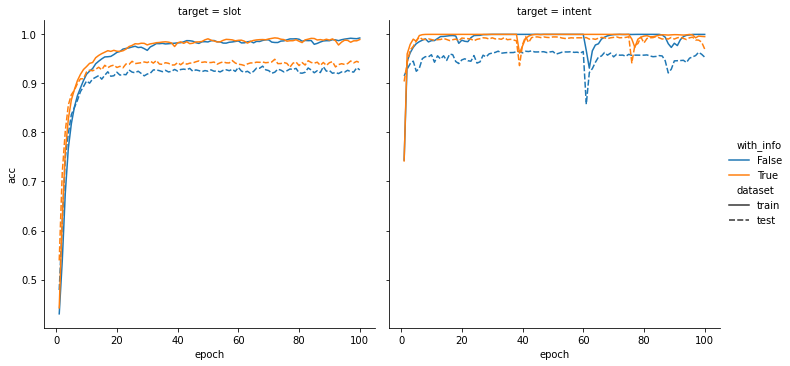

In [40]:
sns.relplot(data=tmp, x='epoch', y='acc', hue='with_info', style='dataset', col='target', kind='line')
plt.savefig('plots/additional_info_acc_snips.pdf', bbox_inches='tight')

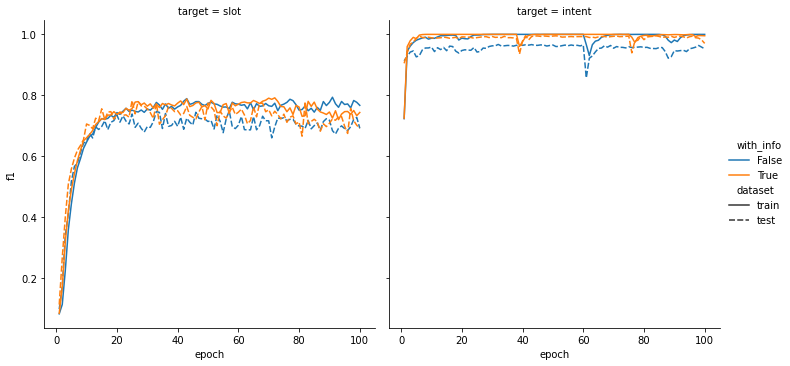

In [41]:
sns.relplot(data=tmp, x='epoch', y='f1', hue='with_info', style='dataset', col='target', kind='line')
plt.savefig('plots/additional_info_f1_snips.pdf', bbox_inches='tight')

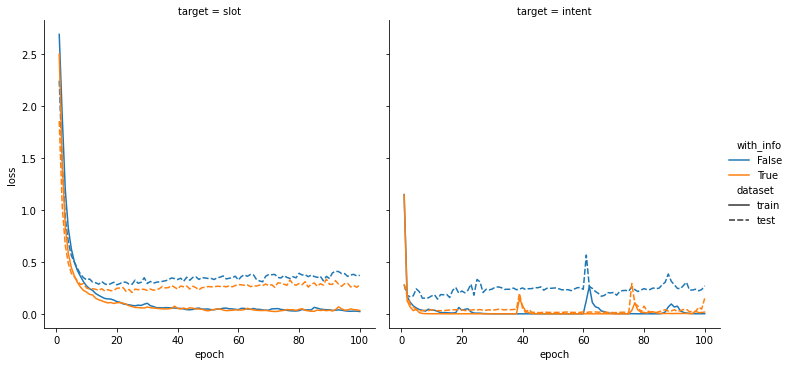

In [42]:
sns.relplot(data=tmp, x='epoch', y='loss', hue='with_info', style='dataset', col='target', kind='line')
plt.savefig('plots/additional_info_loss_snips.pdf', bbox_inches='tight')

# Новая модель

In [43]:
d = DatasetManager('./data/atis_snips/snips/', batch_size=256, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
class SlotNet(nn.Module):
    def __init__(self, input_size, num_slots, hidden_size=200, lstm_layers=4):
        super(SlotNet, self).__init__()
        self.__softmax = nn.Softmax(dim=1)
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers 
        )
        
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * 2, num_slots)
        )
        
    def forward(self, X):
        X_lstm = self.__lstm(X)
        y = self.__fc(X_lstm[0])
        return y
    
class IntentNet(nn.Module):
    def __init__(self, input_size, num_intent, hidden_size=200, lstm_layers=4):
        super(IntentNet, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers        
        )
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * lstm_layers * 4, num_intent)
        )
    
    def forward(self, X, slot):
        X_lstm = self.__lstm(torch.cat((X, slot), dim=-1))
        return self.__fc(torch.cat(X_lstm[1]).transpose(0, 1).reshape(X.shape[0], -1))
    
class Net(nn.Module):
    def __init__(
        self, 
        input_size,
        num_intent, 
        num_slots, 
        intent_hidden_size=200,
        slot_hidden_size=200,        
        lstm_layers=4
    ):
        super(Net, self).__init__()
        self.__slot_net = SlotNet(input_size, num_slots, slot_hidden_size, lstm_layers)
        self.__intent_net = IntentNet(input_size + num_slots, num_intent, intent_hidden_size, lstm_layers)
        
    def forward(self, X):
        y_slot = self.__slot_net(X)
        y_intent = self.__intent_net(X, y_slot)
        return y_intent, y_slot

In [45]:
class SlotAndIntentStep(BaseStep):
    def __init__(self, net, criterion, optimizer, alpha):
        super(SlotAndIntentStep, self).__init__(net, criterion, optimizer)
        self.alpha = alpha
        
    def forward(self, X, slot, intent):
        y_intent, y_slot = self.net(X)
        
        loss = {
            'intent': self.criterion(y_intent, intent.to(device)),
            'slot': self.criterion(y_slot.transpose(1, 2), slot.to(device))
        }
        
        y_intent = y_intent.argmax(axis=-1)
        y_slot = y_slot.argmax(axis=-1)
        
        acc = {
            'intent': accuracy(intent, y_intent),
            'slot': accuracy(slot, y_slot)
        }
        
        f1 = {
            'intent': f1_score(intent.cpu(), y_intent.cpu(), average='macro', zero_division=1),
            'slot': f1_score(
                y_true=slot.cpu().flatten(),
                y_pred=y_slot.cpu().flatten(), 
                labels=range(N_SLOT), average='macro',
                zero_division=1
            )
        } 
        
        return loss, f1, acc
    
    def step(self, X, slot, intent):
        self.optimizer.zero_grad()
        
        loss, f1, acc = self.forward(X, slot, intent)
        
        total_loss = (1 - self.alpha) * loss['intent'] + self.alpha * loss['slot']
        
        total_loss.backward()
        
        self.optimizer.step()
        
        return loss, f1, acc

In [46]:
steppers = dict()
a = np.linspace(-3, 3, 9)
alpha_list = [round(i, 2) for i in sigmoid(a)]

for alpha in alpha_list:
    torch.manual_seed(seed)
    net = Net(768, N_INTENT, len(d.slot_enc), 200, 200, 2).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)
    
    steppers[f'alpha={alpha}'] = SlotAndIntentStep(net, criterion, optimizer, alpha)

In [47]:
history = train(steppers, N_EPOCH)
history.to_csv('history/new_model_snips.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 / 100
------------------
alpha=0.05_intent
Train loss: 2.3770
Train acc: 0.5246
Train f1: 0.5606
Test loss: 0.5148
Test acc: 0.7925
Test f1: 0.8075
------------------
alpha=0.05_slot
Train loss: 5.0482
Train acc: 0.0860
Train f1: 0.3457
Test loss: 3.9224
Test acc: 0.0877
Test f1: 0.4479
------------------
alpha=0.1_intent
Train loss: 1.3438
Train acc: 0.6939
Train f1: 0.7191
Test loss: 0.2891
Test acc: 0.8929
Test f1: 0.8935
------------------
alpha=0.1_slot
Train loss: 3.5762
Train acc: 0.0856
Train f1: 0.3334
Test loss: 2.8249
Test acc: 0.0877
Test f1: 0.4479
------------------
alpha=0.18_intent
Train loss: 1.8986
Train acc: 0.5982
Train f1: 0.6305
Test loss: 0.2798
Test acc: 0.8956
Test f1: 0.8974
------------------
alpha=0.18_slot
Train loss: 3.6165
Train acc: 0.0866
Train f1: 0.3884
Test loss: 2.8511
Test acc: 0.0877
Test f1: 0.4479
------------------
alpha=0.32_intent
Train loss: 1.5790
Train acc: 0.6521
Train f1: 0.6807
Test loss: 0.2797
Test acc: 0.8954
Test f1: 0.8965


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 / 100
------------------
alpha=0.05_intent
Train loss: 0.2729
Train acc: 0.9087
Train f1: 0.9104
Test loss: 0.2577
Test acc: 0.9134
Test f1: 0.9142
------------------
alpha=0.05_slot
Train loss: 3.2784
Train acc: 0.0860
Train f1: 0.4491
Test loss: 2.9568
Test acc: 0.0831
Test f1: 0.4477
------------------
alpha=0.1_intent
Train loss: 0.1743
Train acc: 0.9427
Train f1: 0.9436
Test loss: 0.2026
Test acc: 0.9160
Test f1: 0.9159
------------------
alpha=0.1_slot
Train loss: 2.7836
Train acc: 0.0860
Train f1: 0.4491
Test loss: 2.7423
Test acc: 0.0831
Test f1: 0.4477
------------------
alpha=0.18_intent
Train loss: 0.1991
Train acc: 0.9334
Train f1: 0.9349
Test loss: 0.2374
Test acc: 0.9096
Test f1: 0.9112
------------------
alpha=0.18_slot
Train loss: 2.7696
Train acc: 0.0860
Train f1: 0.4491
Test loss: 2.6872
Test acc: 0.0831
Test f1: 0.4477
------------------
alpha=0.32_intent
Train loss: 0.1977
Train acc: 0.9348
Train f1: 0.9361
Test loss: 0.2325
Test acc: 0.9101
Test f1: 0.9120


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 / 100
------------------
alpha=0.05_intent
Train loss: 0.1840
Train acc: 0.9394
Train f1: 0.9412
Test loss: 0.2356
Test acc: 0.9154
Test f1: 0.9162
------------------
alpha=0.05_slot
Train loss: 2.9167
Train acc: 0.0836
Train f1: 0.4473
Test loss: 2.8046
Test acc: 0.1016
Test f1: 0.4474
------------------
alpha=0.1_intent
Train loss: 0.1249
Train acc: 0.9577
Train f1: 0.9595
Test loss: 0.1981
Test acc: 0.9303
Test f1: 0.9301
------------------
alpha=0.1_slot
Train loss: 2.7221
Train acc: 0.0836
Train f1: 0.4473
Test loss: 2.6435
Test acc: 0.1016
Test f1: 0.4474
------------------
alpha=0.18_intent
Train loss: 0.1443
Train acc: 0.9531
Train f1: 0.9553
Test loss: 0.2136
Test acc: 0.9186
Test f1: 0.9199
------------------
alpha=0.18_slot
Train loss: 2.6215
Train acc: 0.0836
Train f1: 0.4473
Test loss: 2.4483
Test acc: 0.1016
Test f1: 0.4474
------------------
alpha=0.32_intent
Train loss: 0.1373
Train acc: 0.9542
Train f1: 0.9558
Test loss: 0.1714
Test acc: 0.9291
Test f1: 0.9310


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 / 100
------------------
alpha=0.05_intent
Train loss: 0.1418
Train acc: 0.9526
Train f1: 0.9534
Test loss: 0.1947
Test acc: 0.9200
Test f1: 0.9205
------------------
alpha=0.05_slot
Train loss: 2.8045
Train acc: 0.0886
Train f1: 0.4482
Test loss: 2.7556
Test acc: 0.0785
Test f1: 0.4467
------------------
alpha=0.1_intent
Train loss: 0.1125
Train acc: 0.9622
Train f1: 0.9632
Test loss: 0.1780
Test acc: 0.9298
Test f1: 0.9304
------------------
alpha=0.1_slot
Train loss: 2.5583
Train acc: 0.0887
Train f1: 0.4482
Test loss: 2.3873
Test acc: 0.0787
Test f1: 0.4465
------------------
alpha=0.18_intent
Train loss: 0.1189
Train acc: 0.9605
Train f1: 0.9613
Test loss: 0.2424
Test acc: 0.9160
Test f1: 0.9160
------------------
alpha=0.18_slot
Train loss: 2.3547
Train acc: 0.0917
Train f1: 0.4759
Test loss: 2.2450
Test acc: 0.0826
Test f1: 0.4897
------------------
alpha=0.32_intent
Train loss: 0.1222
Train acc: 0.9572
Train f1: 0.9583
Test loss: 0.2047
Test acc: 0.9375
Test f1: 0.9380


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 / 100
------------------
alpha=0.05_intent
Train loss: 0.0986
Train acc: 0.9670
Train f1: 0.9681
Test loss: 0.1615
Test acc: 0.9430
Test f1: 0.9413
------------------
alpha=0.05_slot
Train loss: 2.7209
Train acc: 0.0884
Train f1: 0.4475
Test loss: 2.6129
Test acc: 0.0922
Test f1: 0.4465
------------------
alpha=0.1_intent
Train loss: 0.0736
Train acc: 0.9740
Train f1: 0.9751
Test loss: 0.1556
Test acc: 0.9503
Test f1: 0.9500
------------------
alpha=0.1_slot
Train loss: 2.3418
Train acc: 0.0918
Train f1: 0.4726
Test loss: 2.2615
Test acc: 0.0982
Test f1: 0.4829
------------------
alpha=0.18_intent
Train loss: 0.0934
Train acc: 0.9704
Train f1: 0.9711
Test loss: 0.1692
Test acc: 0.9390
Test f1: 0.9391
------------------
alpha=0.18_slot
Train loss: 2.2407
Train acc: 0.0934
Train f1: 0.4928
Test loss: 2.1526
Test acc: 0.0973
Test f1: 0.4942
------------------
alpha=0.32_intent
Train loss: 0.0855
Train acc: 0.9709
Train f1: 0.9720
Test loss: 0.1496
Test acc: 0.9526
Test f1: 0.9510


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 / 100
------------------
alpha=0.05_intent
Train loss: 0.0759
Train acc: 0.9753
Train f1: 0.9757
Test loss: 0.1794
Test acc: 0.9366
Test f1: 0.9352
------------------
alpha=0.05_slot
Train loss: 2.5148
Train acc: 0.0856
Train f1: 0.4486
Test loss: 2.3688
Test acc: 0.0879
Test f1: 0.4481
------------------
alpha=0.1_intent
Train loss: 0.0605
Train acc: 0.9803
Train f1: 0.9805
Test loss: 0.1469
Test acc: 0.9441
Test f1: 0.9423
------------------
alpha=0.1_slot
Train loss: 2.2651
Train acc: 0.0916
Train f1: 0.4874
Test loss: 2.2220
Test acc: 0.0932
Test f1: 0.4833
------------------
alpha=0.18_intent
Train loss: 0.0650
Train acc: 0.9772
Train f1: 0.9776
Test loss: 0.1572
Test acc: 0.9488
Test f1: 0.9475
------------------
alpha=0.18_slot
Train loss: 2.1477
Train acc: 0.0927
Train f1: 0.5024
Test loss: 2.0556
Test acc: 0.1003
Test f1: 0.5158
------------------
alpha=0.32_intent
Train loss: 0.0658
Train acc: 0.9781
Train f1: 0.9784
Test loss: 0.1417
Test acc: 0.9572
Test f1: 0.9576


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 / 100
------------------
alpha=0.05_intent
Train loss: 0.0609
Train acc: 0.9811
Train f1: 0.9814
Test loss: 0.1531
Test acc: 0.9450
Test f1: 0.9452
------------------
alpha=0.05_slot
Train loss: 2.3606
Train acc: 0.0883
Train f1: 0.4714
Test loss: 2.2962
Test acc: 0.0999
Test f1: 0.4819
------------------
alpha=0.1_intent
Train loss: 0.0401
Train acc: 0.9872
Train f1: 0.9874
Test loss: 0.1818
Test acc: 0.9422
Test f1: 0.9425
------------------
alpha=0.1_slot
Train loss: 2.2041
Train acc: 0.0923
Train f1: 0.4934
Test loss: 2.1507
Test acc: 0.1002
Test f1: 0.4911
------------------
alpha=0.18_intent
Train loss: 0.0481
Train acc: 0.9843
Train f1: 0.9846
Test loss: 0.1556
Test acc: 0.9539
Test f1: 0.9532
------------------
alpha=0.18_slot
Train loss: 2.0429
Train acc: 0.0934
Train f1: 0.5169
Test loss: 1.9267
Test acc: 0.1054
Test f1: 0.5245
------------------
alpha=0.32_intent
Train loss: 0.0457
Train acc: 0.9845
Train f1: 0.9851
Test loss: 0.1565
Test acc: 0.9481
Test f1: 0.9479


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 / 100
------------------
alpha=0.05_intent
Train loss: 0.0452
Train acc: 0.9861
Train f1: 0.9865
Test loss: 0.2399
Test acc: 0.9253
Test f1: 0.9222
------------------
alpha=0.05_slot
Train loss: 2.3060
Train acc: 0.0876
Train f1: 0.4876
Test loss: 2.2429
Test acc: 0.0822
Test f1: 0.4911
------------------
alpha=0.1_intent
Train loss: 0.0249
Train acc: 0.9918
Train f1: 0.9920
Test loss: 0.1764
Test acc: 0.9489
Test f1: 0.9463
------------------
alpha=0.1_slot
Train loss: 2.1461
Train acc: 0.0892
Train f1: 0.4976
Test loss: 2.0592
Test acc: 0.0848
Test f1: 0.5036
------------------
alpha=0.18_intent
Train loss: 0.0374
Train acc: 0.9879
Train f1: 0.9881
Test loss: 0.2344
Test acc: 0.9448
Test f1: 0.9437
------------------
alpha=0.18_slot
Train loss: 1.9055
Train acc: 0.0935
Train f1: 0.5279
Test loss: 1.7974
Test acc: 0.0901
Test f1: 0.5418
------------------
alpha=0.32_intent
Train loss: 0.0386
Train acc: 0.9867
Train f1: 0.9870
Test loss: 0.2279
Test acc: 0.9395
Test f1: 0.9374


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 / 100
------------------
alpha=0.05_intent
Train loss: 0.0468
Train acc: 0.9839
Train f1: 0.9841
Test loss: 0.1577
Test acc: 0.9518
Test f1: 0.9517
------------------
alpha=0.05_slot
Train loss: 2.2728
Train acc: 0.0951
Train f1: 0.4894
Test loss: 2.2284
Test acc: 0.0824
Test f1: 0.4900
------------------
alpha=0.1_intent
Train loss: 0.0306
Train acc: 0.9896
Train f1: 0.9896
Test loss: 0.1894
Test acc: 0.9405
Test f1: 0.9409
------------------
alpha=0.1_slot
Train loss: 2.0657
Train acc: 0.0992
Train f1: 0.5191
Test loss: 2.0168
Test acc: 0.0936
Test f1: 0.5422
------------------
alpha=0.18_intent
Train loss: 0.0356
Train acc: 0.9874
Train f1: 0.9876
Test loss: 0.2058
Test acc: 0.9510
Test f1: 0.9516
------------------
alpha=0.18_slot
Train loss: 1.7946
Train acc: 0.1055
Train f1: 0.5444
Test loss: 1.6922
Test acc: 0.0939
Test f1: 0.5452
------------------
alpha=0.32_intent
Train loss: 0.0463
Train acc: 0.9833
Train f1: 0.9835
Test loss: 0.2530
Test acc: 0.9144
Test f1: 0.9171


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 / 100
------------------
alpha=0.05_intent
Train loss: 0.0340
Train acc: 0.9894
Train f1: 0.9896
Test loss: 0.1840
Test acc: 0.9400
Test f1: 0.9411
------------------
alpha=0.05_slot
Train loss: 2.2413
Train acc: 0.0927
Train f1: 0.4939
Test loss: 2.2097
Test acc: 0.0870
Test f1: 0.4905
------------------
alpha=0.1_intent
Train loss: 0.0329
Train acc: 0.9886
Train f1: 0.9888
Test loss: 0.2278
Test acc: 0.9464
Test f1: 0.9458
------------------
alpha=0.1_slot
Train loss: 1.9904
Train acc: 0.0999
Train f1: 0.5377
Test loss: 1.9468
Test acc: 0.0923
Test f1: 0.5409
------------------
alpha=0.18_intent
Train loss: 0.0231
Train acc: 0.9928
Train f1: 0.9929
Test loss: 0.1722
Test acc: 0.9558
Test f1: 0.9554
------------------
alpha=0.18_slot
Train loss: 1.6677
Train acc: 0.1116
Train f1: 0.5735
Test loss: 1.5498
Test acc: 0.1120
Test f1: 0.5949
------------------
alpha=0.32_intent
Train loss: 0.0401
Train acc: 0.9864
Train f1: 0.9865
Test loss: 0.1899
Test acc: 0.9520
Test f1: 0.9523

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 / 100
------------------
alpha=0.05_intent
Train loss: 0.0356
Train acc: 0.9884
Train f1: 0.9884
Test loss: 0.2156
Test acc: 0.9356
Test f1: 0.9342
------------------
alpha=0.05_slot
Train loss: 2.2355
Train acc: 0.0877
Train f1: 0.4940
Test loss: 2.1832
Test acc: 0.0963
Test f1: 0.4948
------------------
alpha=0.1_intent
Train loss: 0.0370
Train acc: 0.9873
Train f1: 0.9876
Test loss: 0.2042
Test acc: 0.9378
Test f1: 0.9371
------------------
alpha=0.1_slot
Train loss: 1.9292
Train acc: 0.0975
Train f1: 0.5462
Test loss: 1.8088
Test acc: 0.1121
Test f1: 0.5802
------------------
alpha=0.18_intent
Train loss: 0.0192
Train acc: 0.9937
Train f1: 0.9935
Test loss: 0.1748
Test acc: 0.9542
Test f1: 0.9532
------------------
alpha=0.18_slot
Train loss: 1.5347
Train acc: 0.1189
Train f1: 0.6040
Test loss: 1.4594
Test acc: 0.1323
Test f1: 0.6205
------------------
alpha=0.32_intent
Train loss: 0.0256
Train acc: 0.9905
Train f1: 0.9903
Test loss: 0.1655
Test acc: 0.9455
Test f1: 0.9446

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 / 100
------------------
alpha=0.05_intent
Train loss: 0.0209
Train acc: 0.9931
Train f1: 0.9932
Test loss: 0.2139
Test acc: 0.9407
Test f1: 0.9405
------------------
alpha=0.05_slot
Train loss: 2.1936
Train acc: 0.0915
Train f1: 0.4971
Test loss: 2.1341
Test acc: 0.1001
Test f1: 0.4987
------------------
alpha=0.1_intent
Train loss: 0.0247
Train acc: 0.9912
Train f1: 0.9914
Test loss: 0.1999
Test acc: 0.9498
Test f1: 0.9498
------------------
alpha=0.1_slot
Train loss: 1.8100
Train acc: 0.1073
Train f1: 0.5704
Test loss: 1.7232
Test acc: 0.1274
Test f1: 0.6056
------------------
alpha=0.18_intent
Train loss: 0.0234
Train acc: 0.9928
Train f1: 0.9928
Test loss: 0.2085
Test acc: 0.9523
Test f1: 0.9532
------------------
alpha=0.18_slot
Train loss: 1.4402
Train acc: 0.1346
Train f1: 0.6254
Test loss: 1.3651
Test acc: 0.1481
Test f1: 0.6455
------------------
alpha=0.32_intent
Train loss: 0.0337
Train acc: 0.9878
Train f1: 0.9880
Test loss: 0.1586
Test acc: 0.9540
Test f1: 0.9559

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 / 100
------------------
alpha=0.05_intent
Train loss: 0.0183
Train acc: 0.9949
Train f1: 0.9950
Test loss: 0.1466
Test acc: 0.9486
Test f1: 0.9489
------------------
alpha=0.05_slot
Train loss: 2.1710
Train acc: 0.0980
Train f1: 0.4981
Test loss: 2.1073
Test acc: 0.0797
Test f1: 0.5082
------------------
alpha=0.1_intent
Train loss: 0.0211
Train acc: 0.9927
Train f1: 0.9931
Test loss: 0.2145
Test acc: 0.9466
Test f1: 0.9468
------------------
alpha=0.1_slot
Train loss: 1.7300
Train acc: 0.1221
Train f1: 0.5868
Test loss: 1.5936
Test acc: 0.1139
Test f1: 0.6207
------------------
alpha=0.18_intent
Train loss: 0.0175
Train acc: 0.9945
Train f1: 0.9947
Test loss: 0.2222
Test acc: 0.9435
Test f1: 0.9437
------------------
alpha=0.18_slot
Train loss: 1.3212
Train acc: 0.1580
Train f1: 0.6605
Test loss: 1.2524
Test acc: 0.1537
Test f1: 0.6855
------------------
alpha=0.32_intent
Train loss: 0.0230
Train acc: 0.9926
Train f1: 0.9927
Test loss: 0.1780
Test acc: 0.9487
Test f1: 0.9511

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 / 100
------------------
alpha=0.05_intent
Train loss: 0.0177
Train acc: 0.9936
Train f1: 0.9940
Test loss: 0.1481
Test acc: 0.9575
Test f1: 0.9568
------------------
alpha=0.05_slot
Train loss: 2.1362
Train acc: 0.0913
Train f1: 0.5063
Test loss: 2.0953
Test acc: 0.0932
Test f1: 0.5120
------------------
alpha=0.1_intent
Train loss: 0.0236
Train acc: 0.9914
Train f1: 0.9920
Test loss: 0.2322
Test acc: 0.9441
Test f1: 0.9441
------------------
alpha=0.1_slot
Train loss: 1.6144
Train acc: 0.1265
Train f1: 0.6140
Test loss: 1.5077
Test acc: 0.1326
Test f1: 0.6290
------------------
alpha=0.18_intent
Train loss: 0.0171
Train acc: 0.9944
Train f1: 0.9948
Test loss: 0.1474
Test acc: 0.9587
Test f1: 0.9581
------------------
alpha=0.18_slot
Train loss: 1.2416
Train acc: 0.1651
Train f1: 0.6821
Test loss: 1.1658
Test acc: 0.1921
Test f1: 0.7042
------------------
alpha=0.32_intent
Train loss: 0.0201
Train acc: 0.9940
Train f1: 0.9940
Test loss: 0.1839
Test acc: 0.9440
Test f1: 0.9445

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 / 100
------------------
alpha=0.05_intent
Train loss: 0.0203
Train acc: 0.9935
Train f1: 0.9935
Test loss: 0.1854
Test acc: 0.9489
Test f1: 0.9514
------------------
alpha=0.05_slot
Train loss: 2.1237
Train acc: 0.0926
Train f1: 0.5091
Test loss: 2.0677
Test acc: 0.0717
Test f1: 0.5117
------------------
alpha=0.1_intent
Train loss: 0.0248
Train acc: 0.9904
Train f1: 0.9906
Test loss: 0.2312
Test acc: 0.9408
Test f1: 0.9431
------------------
alpha=0.1_slot
Train loss: 1.5002
Train acc: 0.1403
Train f1: 0.6339
Test loss: 1.4112
Test acc: 0.1489
Test f1: 0.6547
------------------
alpha=0.18_intent
Train loss: 0.0375
Train acc: 0.9865
Train f1: 0.9868
Test loss: 0.1942
Test acc: 0.9550
Test f1: 0.9549
------------------
alpha=0.18_slot
Train loss: 1.2514
Train acc: 0.1834
Train f1: 0.6793
Test loss: 1.1107
Test acc: 0.1908
Test f1: 0.7128
------------------
alpha=0.32_intent
Train loss: 0.0159
Train acc: 0.9946
Train f1: 0.9944
Test loss: 0.2408
Test acc: 0.9469
Test f1: 0.9457

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 / 100
------------------
alpha=0.05_intent
Train loss: 0.0229
Train acc: 0.9917
Train f1: 0.9917
Test loss: 0.2099
Test acc: 0.9378
Test f1: 0.9371
------------------
alpha=0.05_slot
Train loss: 2.1125
Train acc: 0.0933
Train f1: 0.5115
Test loss: 2.0490
Test acc: 0.0878
Test f1: 0.5135
------------------
alpha=0.1_intent
Train loss: 0.0503
Train acc: 0.9838
Train f1: 0.9838
Test loss: 0.2383
Test acc: 0.9397
Test f1: 0.9374
------------------
alpha=0.1_slot
Train loss: 1.5468
Train acc: 0.1461
Train f1: 0.6219
Test loss: 1.3906
Test acc: 0.1450
Test f1: 0.6537
------------------
alpha=0.18_intent
Train loss: 0.0398
Train acc: 0.9859
Train f1: 0.9860
Test loss: 0.2720
Test acc: 0.9353
Test f1: 0.9365
------------------
alpha=0.18_slot
Train loss: 1.1446
Train acc: 0.2078
Train f1: 0.7053
Test loss: 1.0687
Test acc: 0.2522
Test f1: 0.7287
------------------
alpha=0.32_intent
Train loss: 0.0261
Train acc: 0.9903
Train f1: 0.9905
Test loss: 0.2273
Test acc: 0.9460
Test f1: 0.9466

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 / 100
------------------
alpha=0.05_intent
Train loss: 0.0127
Train acc: 0.9962
Train f1: 0.9962
Test loss: 0.1936
Test acc: 0.9432
Test f1: 0.9414
------------------
alpha=0.05_slot
Train loss: 2.0610
Train acc: 0.0949
Train f1: 0.5152
Test loss: 1.9912
Test acc: 0.1146
Test f1: 0.5203
------------------
alpha=0.1_intent
Train loss: 0.0297
Train acc: 0.9899
Train f1: 0.9899
Test loss: 0.2321
Test acc: 0.9477
Test f1: 0.9475
------------------
alpha=0.1_slot
Train loss: 1.3853
Train acc: 0.1650
Train f1: 0.6516
Test loss: 1.2663
Test acc: 0.2115
Test f1: 0.6830
------------------
alpha=0.18_intent
Train loss: 0.0271
Train acc: 0.9896
Train f1: 0.9897
Test loss: 0.1714
Test acc: 0.9608
Test f1: 0.9598
------------------
alpha=0.18_slot
Train loss: 1.0614
Train acc: 0.2265
Train f1: 0.7252
Test loss: 0.9521
Test acc: 0.2749
Test f1: 0.7517
------------------
alpha=0.32_intent
Train loss: 0.0153
Train acc: 0.9951
Train f1: 0.9951
Test loss: 0.1779
Test acc: 0.9498
Test f1: 0.9489

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 / 100
------------------
alpha=0.05_intent
Train loss: 0.0114
Train acc: 0.9970
Train f1: 0.9970
Test loss: 0.1752
Test acc: 0.9490
Test f1: 0.9479
------------------
alpha=0.05_slot
Train loss: 2.0224
Train acc: 0.0915
Train f1: 0.5172
Test loss: 1.9583
Test acc: 0.0963
Test f1: 0.5144
------------------
alpha=0.1_intent
Train loss: 0.0227
Train acc: 0.9919
Train f1: 0.9920
Test loss: 0.2200
Test acc: 0.9465
Test f1: 0.9457
------------------
alpha=0.1_slot
Train loss: 1.2653
Train acc: 0.1862
Train f1: 0.6779
Test loss: 1.1433
Test acc: 0.2228
Test f1: 0.6993
------------------
alpha=0.18_intent
Train loss: 0.0174
Train acc: 0.9933
Train f1: 0.9934
Test loss: 0.2609
Test acc: 0.9494
Test f1: 0.9483
------------------
alpha=0.18_slot
Train loss: 0.9567
Train acc: 0.2537
Train f1: 0.7509
Test loss: 0.9079
Test acc: 0.2799
Test f1: 0.7646
------------------
alpha=0.32_intent
Train loss: 0.0149
Train acc: 0.9935
Train f1: 0.9937
Test loss: 0.3384
Test acc: 0.9383
Test f1: 0.9382

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19 / 100
------------------
alpha=0.05_intent
Train loss: 0.0144
Train acc: 0.9948
Train f1: 0.9957
Test loss: 0.2300
Test acc: 0.9462
Test f1: 0.9441
------------------
alpha=0.05_slot
Train loss: 1.9722
Train acc: 0.0928
Train f1: 0.5221
Test loss: 1.9252
Test acc: 0.0838
Test f1: 0.5153
------------------
alpha=0.1_intent
Train loss: 0.0139
Train acc: 0.9959
Train f1: 0.9959
Test loss: 0.2851
Test acc: 0.9334
Test f1: 0.9327
------------------
alpha=0.1_slot
Train loss: 1.1139
Train acc: 0.2185
Train f1: 0.7102
Test loss: 1.0227
Test acc: 0.2527
Test f1: 0.7317
------------------
alpha=0.18_intent
Train loss: 0.0135
Train acc: 0.9951
Train f1: 0.9955
Test loss: 0.2405
Test acc: 0.9516
Test f1: 0.9502
------------------
alpha=0.18_slot
Train loss: 0.8457
Train acc: 0.2890
Train f1: 0.7790
Test loss: 0.8011
Test acc: 0.3269
Test f1: 0.7884
------------------
alpha=0.32_intent
Train loss: 0.0201
Train acc: 0.9942
Train f1: 0.9942
Test loss: 0.2344
Test acc: 0.9442
Test f1: 0.9428

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 / 100
------------------
alpha=0.05_intent
Train loss: 0.0639
Train acc: 0.9774
Train f1: 0.9783
Test loss: 0.2158
Test acc: 0.9490
Test f1: 0.9483
------------------
alpha=0.05_slot
Train loss: 2.1716
Train acc: 0.0905
Train f1: 0.5041
Test loss: 1.9766
Test acc: 0.0861
Test f1: 0.5095
------------------
alpha=0.1_intent
Train loss: 0.0217
Train acc: 0.9933
Train f1: 0.9935
Test loss: 0.2199
Test acc: 0.9423
Test f1: 0.9414
------------------
alpha=0.1_slot
Train loss: 1.0769
Train acc: 0.2367
Train f1: 0.7176
Test loss: 1.0441
Test acc: 0.2447
Test f1: 0.7200
------------------
alpha=0.18_intent
Train loss: 0.0217
Train acc: 0.9922
Train f1: 0.9922
Test loss: 0.2496
Test acc: 0.9471
Test f1: 0.9457
------------------
alpha=0.18_slot
Train loss: 0.8091
Train acc: 0.3118
Train f1: 0.7889
Test loss: 0.7875
Test acc: 0.3388
Test f1: 0.7961
------------------
alpha=0.32_intent
Train loss: 0.0288
Train acc: 0.9909
Train f1: 0.9910
Test loss: 0.1952
Test acc: 0.9547
Test f1: 0.9532

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 / 100
------------------
alpha=0.05_intent
Train loss: 0.0287
Train acc: 0.9891
Train f1: 0.9893
Test loss: 0.2043
Test acc: 0.9512
Test f1: 0.9494
------------------
alpha=0.05_slot
Train loss: 1.9865
Train acc: 0.0979
Train f1: 0.5187
Test loss: 1.8904
Test acc: 0.1053
Test f1: 0.5225
------------------
alpha=0.1_intent
Train loss: 0.0111
Train acc: 0.9966
Train f1: 0.9967
Test loss: 0.1627
Test acc: 0.9610
Test f1: 0.9620
------------------
alpha=0.1_slot
Train loss: 0.9539
Train acc: 0.2828
Train f1: 0.7482
Test loss: 0.8433
Test acc: 0.3284
Test f1: 0.7730
------------------
alpha=0.18_intent
Train loss: 0.0194
Train acc: 0.9933
Train f1: 0.9934
Test loss: 0.2073
Test acc: 0.9510
Test f1: 0.9498
------------------
alpha=0.18_slot
Train loss: 0.7733
Train acc: 0.3367
Train f1: 0.7956
Test loss: 0.7466
Test acc: 0.3678
Test f1: 0.8010
------------------
alpha=0.32_intent
Train loss: 0.0171
Train acc: 0.9933
Train f1: 0.9935
Test loss: 0.2035
Test acc: 0.9527
Test f1: 0.9536

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 / 100
------------------
alpha=0.05_intent
Train loss: 0.0189
Train acc: 0.9938
Train f1: 0.9938
Test loss: 0.2426
Test acc: 0.9454
Test f1: 0.9428
------------------
alpha=0.05_slot
Train loss: 1.9141
Train acc: 0.0973
Train f1: 0.5289
Test loss: 1.8461
Test acc: 0.1056
Test f1: 0.5610
------------------
alpha=0.1_intent
Train loss: 0.0086
Train acc: 0.9971
Train f1: 0.9971
Test loss: 0.2166
Test acc: 0.9459
Test f1: 0.9455
------------------
alpha=0.1_slot
Train loss: 0.8421
Train acc: 0.3215
Train f1: 0.7742
Test loss: 0.7879
Test acc: 0.3487
Test f1: 0.7869
------------------
alpha=0.18_intent
Train loss: 0.0146
Train acc: 0.9951
Train f1: 0.9952
Test loss: 0.2524
Test acc: 0.9469
Test f1: 0.9489
------------------
alpha=0.18_slot
Train loss: 0.7073
Train acc: 0.3711
Train f1: 0.8115
Test loss: 0.7009
Test acc: 0.4062
Test f1: 0.8132
------------------
alpha=0.32_intent
Train loss: 0.0172
Train acc: 0.9940
Train f1: 0.9940
Test loss: 0.3230
Test acc: 0.9427
Test f1: 0.9419

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 / 100
------------------
alpha=0.05_intent
Train loss: 0.0140
Train acc: 0.9955
Train f1: 0.9955
Test loss: 0.2179
Test acc: 0.9423
Test f1: 0.9398
------------------
alpha=0.05_slot
Train loss: 1.8365
Train acc: 0.1081
Train f1: 0.5526
Test loss: 1.7569
Test acc: 0.1263
Test f1: 0.5827
------------------
alpha=0.1_intent
Train loss: 0.0195
Train acc: 0.9931
Train f1: 0.9933
Test loss: 0.2129
Test acc: 0.9501
Test f1: 0.9494
------------------
alpha=0.1_slot
Train loss: 0.8300
Train acc: 0.3239
Train f1: 0.7758
Test loss: 0.7554
Test acc: 0.3898
Test f1: 0.7910
------------------
alpha=0.18_intent
Train loss: 0.0172
Train acc: 0.9936
Train f1: 0.9935
Test loss: 0.3194
Test acc: 0.9488
Test f1: 0.9477
------------------
alpha=0.18_slot
Train loss: 0.6771
Train acc: 0.3933
Train f1: 0.8185
Test loss: 0.6465
Test acc: 0.4504
Test f1: 0.8272
------------------
alpha=0.32_intent
Train loss: 0.0186
Train acc: 0.9941
Train f1: 0.9942
Test loss: 0.2584
Test acc: 0.9494
Test f1: 0.9485

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 / 100
------------------
alpha=0.05_intent
Train loss: 0.0064
Train acc: 0.9981
Train f1: 0.9981
Test loss: 0.1815
Test acc: 0.9565
Test f1: 0.9562
------------------
alpha=0.05_slot
Train loss: 1.6418
Train acc: 0.1262
Train f1: 0.5936
Test loss: 1.4505
Test acc: 0.1449
Test f1: 0.6298
------------------
alpha=0.1_intent
Train loss: 0.0066
Train acc: 0.9974
Train f1: 0.9974
Test loss: 0.2575
Test acc: 0.9571
Test f1: 0.9593
------------------
alpha=0.1_slot
Train loss: 0.7019
Train acc: 0.3702
Train f1: 0.8067
Test loss: 0.6848
Test acc: 0.4201
Test f1: 0.8155
------------------
alpha=0.18_intent
Train loss: 0.0294
Train acc: 0.9899
Train f1: 0.9900
Test loss: 0.3166
Test acc: 0.9363
Test f1: 0.9348
------------------
alpha=0.18_slot
Train loss: 0.6953
Train acc: 0.3935
Train f1: 0.8132
Test loss: 0.6341
Test acc: 0.4292
Test f1: 0.8249
------------------
alpha=0.32_intent
Train loss: 0.0173
Train acc: 0.9938
Train f1: 0.9938
Test loss: 0.3064
Test acc: 0.9403
Test f1: 0.9410

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 / 100
------------------
alpha=0.05_intent
Train loss: 0.0096
Train acc: 0.9961
Train f1: 0.9965
Test loss: 0.2518
Test acc: 0.9445
Test f1: 0.9438
------------------
alpha=0.05_slot
Train loss: 1.4057
Train acc: 0.1705
Train f1: 0.6439
Test loss: 1.4637
Test acc: 0.2092
Test f1: 0.6340
------------------
alpha=0.1_intent
Train loss: 0.0062
Train acc: 0.9983
Train f1: 0.9983
Test loss: 0.1949
Test acc: 0.9579
Test f1: 0.9576
------------------
alpha=0.1_slot
Train loss: 0.6201
Train acc: 0.4124
Train f1: 0.8254
Test loss: 0.5811
Test acc: 0.4603
Test f1: 0.8337
------------------
alpha=0.18_intent
Train loss: 0.0380
Train acc: 0.9883
Train f1: 0.9885
Test loss: 0.2170
Test acc: 0.9536
Test f1: 0.9528
------------------
alpha=0.18_slot
Train loss: 0.6995
Train acc: 0.3854
Train f1: 0.8088
Test loss: 0.6651
Test acc: 0.4174
Test f1: 0.8197
------------------
alpha=0.32_intent
Train loss: 0.0185
Train acc: 0.9934
Train f1: 0.9936
Test loss: 0.2378
Test acc: 0.9534
Test f1: 0.9533

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 / 100
------------------
alpha=0.05_intent
Train loss: 0.0194
Train acc: 0.9931
Train f1: 0.9931
Test loss: 0.1671
Test acc: 0.9491
Test f1: 0.9471
------------------
alpha=0.05_slot
Train loss: 1.3643
Train acc: 0.1891
Train f1: 0.6474
Test loss: 1.1675
Test acc: 0.2176
Test f1: 0.6900
------------------
alpha=0.1_intent
Train loss: 0.0042
Train acc: 0.9988
Train f1: 0.9988
Test loss: 0.2388
Test acc: 0.9490
Test f1: 0.9494
------------------
alpha=0.1_slot
Train loss: 0.5417
Train acc: 0.4644
Train f1: 0.8464
Test loss: 0.5314
Test acc: 0.5374
Test f1: 0.8497
------------------
alpha=0.18_intent
Train loss: 0.0234
Train acc: 0.9928
Train f1: 0.9929
Test loss: 0.2455
Test acc: 0.9517
Test f1: 0.9511
------------------
alpha=0.18_slot
Train loss: 0.6251
Train acc: 0.4242
Train f1: 0.8278
Test loss: 0.5987
Test acc: 0.4551
Test f1: 0.8395
------------------
alpha=0.32_intent
Train loss: 0.0179
Train acc: 0.9930
Train f1: 0.9932
Test loss: 0.2148
Test acc: 0.9565
Test f1: 0.9550

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 / 100
------------------
alpha=0.05_intent
Train loss: 0.0117
Train acc: 0.9965
Train f1: 0.9965
Test loss: 0.1992
Test acc: 0.9496
Test f1: 0.9497
------------------
alpha=0.05_slot
Train loss: 1.1069
Train acc: 0.2416
Train f1: 0.7045
Test loss: 0.9889
Test acc: 0.2766
Test f1: 0.7278
------------------
alpha=0.1_intent
Train loss: 0.0067
Train acc: 0.9975
Train f1: 0.9976
Test loss: 0.2064
Test acc: 0.9501
Test f1: 0.9502
------------------
alpha=0.1_slot
Train loss: 0.5141
Train acc: 0.4767
Train f1: 0.8540
Test loss: 0.5094
Test acc: 0.4861
Test f1: 0.8554
------------------
alpha=0.18_intent
Train loss: 0.0223
Train acc: 0.9926
Train f1: 0.9927
Test loss: 0.2640
Test acc: 0.9544
Test f1: 0.9545
------------------
alpha=0.18_slot
Train loss: 0.6030
Train acc: 0.4334
Train f1: 0.8334
Test loss: 0.5496
Test acc: 0.4822
Test f1: 0.8488
------------------
alpha=0.32_intent
Train loss: 0.0234
Train acc: 0.9925
Train f1: 0.9926
Test loss: 0.2234
Test acc: 0.9496
Test f1: 0.9489

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28 / 100
------------------
alpha=0.05_intent
Train loss: 0.0102
Train acc: 0.9964
Train f1: 0.9965
Test loss: 0.1996
Test acc: 0.9500
Test f1: 0.9498
------------------
alpha=0.05_slot
Train loss: 1.0125
Train acc: 0.2790
Train f1: 0.7275
Test loss: 0.9561
Test acc: 0.3045
Test f1: 0.7411
------------------
alpha=0.1_intent
Train loss: 0.0051
Train acc: 0.9983
Train f1: 0.9983
Test loss: 0.2016
Test acc: 0.9614
Test f1: 0.9599
------------------
alpha=0.1_slot
Train loss: 0.4684
Train acc: 0.4822
Train f1: 0.8657
Test loss: 0.4688
Test acc: 0.5137
Test f1: 0.8679
------------------
alpha=0.18_intent
Train loss: 0.0086
Train acc: 0.9971
Train f1: 0.9970
Test loss: 0.1727
Test acc: 0.9631
Test f1: 0.9625
------------------
alpha=0.18_slot
Train loss: 0.5196
Train acc: 0.4645
Train f1: 0.8552
Test loss: 0.5223
Test acc: 0.5039
Test f1: 0.8613
------------------
alpha=0.32_intent
Train loss: 0.0215
Train acc: 0.9932
Train f1: 0.9932
Test loss: 0.2422
Test acc: 0.9556
Test f1: 0.9554

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 / 100
------------------
alpha=0.05_intent
Train loss: 0.0095
Train acc: 0.9965
Train f1: 0.9965
Test loss: 0.1970
Test acc: 0.9451
Test f1: 0.9464
------------------
alpha=0.05_slot
Train loss: 0.9088
Train acc: 0.3118
Train f1: 0.7528
Test loss: 0.8973
Test acc: 0.3059
Test f1: 0.7571
------------------
alpha=0.1_intent
Train loss: 0.0070
Train acc: 0.9976
Train f1: 0.9977
Test loss: 0.1885
Test acc: 0.9655
Test f1: 0.9669
------------------
alpha=0.1_slot
Train loss: 0.4533
Train acc: 0.5013
Train f1: 0.8704
Test loss: 0.4695
Test acc: 0.5081
Test f1: 0.8672
------------------
alpha=0.18_intent
Train loss: 0.0067
Train acc: 0.9977
Train f1: 0.9978
Test loss: 0.1966
Test acc: 0.9502
Test f1: 0.9510
------------------
alpha=0.18_slot
Train loss: 0.4642
Train acc: 0.4879
Train f1: 0.8689
Test loss: 0.4745
Test acc: 0.5177
Test f1: 0.8713
------------------
alpha=0.32_intent
Train loss: 0.0171
Train acc: 0.9939
Train f1: 0.9941
Test loss: 0.2523
Test acc: 0.9466
Test f1: 0.9476

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 / 100
------------------
alpha=0.05_intent
Train loss: 0.0220
Train acc: 0.9923
Train f1: 0.9924
Test loss: 0.2628
Test acc: 0.9363
Test f1: 0.9365
------------------
alpha=0.05_slot
Train loss: 1.0070
Train acc: 0.2981
Train f1: 0.7337
Test loss: 0.9959
Test acc: 0.3419
Test f1: 0.7412
------------------
alpha=0.1_intent
Train loss: 0.0051
Train acc: 0.9979
Train f1: 0.9980
Test loss: 0.2175
Test acc: 0.9634
Test f1: 0.9642
------------------
alpha=0.1_slot
Train loss: 0.4288
Train acc: 0.5153
Train f1: 0.8762
Test loss: 0.4609
Test acc: 0.5708
Test f1: 0.8675
------------------
alpha=0.18_intent
Train loss: 0.0047
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.1900
Test acc: 0.9547
Test f1: 0.9545
------------------
alpha=0.18_slot
Train loss: 0.4306
Train acc: 0.5165
Train f1: 0.8784
Test loss: 0.4641
Test acc: 0.5575
Test f1: 0.8731
------------------
alpha=0.32_intent
Train loss: 0.0131
Train acc: 0.9956
Train f1: 0.9957
Test loss: 0.2480
Test acc: 0.9479
Test f1: 0.9471

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 / 100
------------------
alpha=0.05_intent
Train loss: 0.0165
Train acc: 0.9944
Train f1: 0.9945
Test loss: 0.1668
Test acc: 0.9590
Test f1: 0.9581
------------------
alpha=0.05_slot
Train loss: 0.9702
Train acc: 0.3120
Train f1: 0.7422
Test loss: 0.8973
Test acc: 0.3644
Test f1: 0.7560
------------------
alpha=0.1_intent
Train loss: 0.0046
Train acc: 0.9985
Train f1: 0.9985
Test loss: 0.2046
Test acc: 0.9655
Test f1: 0.9655
------------------
alpha=0.1_slot
Train loss: 0.3916
Train acc: 0.5210
Train f1: 0.8874
Test loss: 0.4445
Test acc: 0.5336
Test f1: 0.8747
------------------
alpha=0.18_intent
Train loss: 0.0041
Train acc: 0.9987
Train f1: 0.9988
Test loss: 0.2093
Test acc: 0.9618
Test f1: 0.9601
------------------
alpha=0.18_slot
Train loss: 0.3895
Train acc: 0.5359
Train f1: 0.8885
Test loss: 0.4379
Test acc: 0.5826
Test f1: 0.8784
------------------
alpha=0.32_intent
Train loss: 0.0038
Train acc: 0.9987
Train f1: 0.9987
Test loss: 0.1594
Test acc: 0.9630
Test f1: 0.9625

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 / 100
------------------
alpha=0.05_intent
Train loss: 0.0107
Train acc: 0.9963
Train f1: 0.9963
Test loss: 0.1942
Test acc: 0.9566
Test f1: 0.9560
------------------
alpha=0.05_slot
Train loss: 0.8164
Train acc: 0.3697
Train f1: 0.7752
Test loss: 0.7443
Test acc: 0.4021
Test f1: 0.7932
------------------
alpha=0.1_intent
Train loss: 0.0120
Train acc: 0.9954
Train f1: 0.9959
Test loss: 0.3782
Test acc: 0.9444
Test f1: 0.9424
------------------
alpha=0.1_slot
Train loss: 0.4384
Train acc: 0.5353
Train f1: 0.8727
Test loss: 0.5009
Test acc: 0.5235
Test f1: 0.8597
------------------
alpha=0.18_intent
Train loss: 0.0020
Train acc: 0.9993
Train f1: 0.9994
Test loss: 0.2126
Test acc: 0.9660
Test f1: 0.9651
------------------
alpha=0.18_slot
Train loss: 0.3569
Train acc: 0.5656
Train f1: 0.8970
Test loss: 0.4129
Test acc: 0.5849
Test f1: 0.8897
------------------
alpha=0.32_intent
Train loss: 0.0042
Train acc: 0.9988
Train f1: 0.9989
Test loss: 0.2741
Test acc: 0.9612
Test f1: 0.9612

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 / 100
------------------
alpha=0.05_intent
Train loss: 0.0041
Train acc: 0.9988
Train f1: 0.9988
Test loss: 0.2023
Test acc: 0.9554
Test f1: 0.9556
------------------
alpha=0.05_slot
Train loss: 0.6986
Train acc: 0.4063
Train f1: 0.8048
Test loss: 0.6408
Test acc: 0.4617
Test f1: 0.8200
------------------
alpha=0.1_intent
Train loss: 0.0419
Train acc: 0.9876
Train f1: 0.9876
Test loss: 0.2579
Test acc: 0.9478
Test f1: 0.9472
------------------
alpha=0.1_slot
Train loss: 0.6578
Train acc: 0.4647
Train f1: 0.8188
Test loss: 0.5766
Test acc: 0.4988
Test f1: 0.8403
------------------
alpha=0.18_intent
Train loss: 0.0030
Train acc: 0.9992
Train f1: 0.9992
Test loss: 0.1789
Test acc: 0.9650
Test f1: 0.9646
------------------
alpha=0.18_slot
Train loss: 0.3414
Train acc: 0.5672
Train f1: 0.9002
Test loss: 0.4345
Test acc: 0.6059
Test f1: 0.8778
------------------
alpha=0.32_intent
Train loss: 0.0025
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.2569
Test acc: 0.9652
Test f1: 0.9639

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 / 100
------------------
alpha=0.05_intent
Train loss: 0.0067
Train acc: 0.9985
Train f1: 0.9986
Test loss: 0.1727
Test acc: 0.9578
Test f1: 0.9566
------------------
alpha=0.05_slot
Train loss: 0.6386
Train acc: 0.4137
Train f1: 0.8195
Test loss: 0.6253
Test acc: 0.4650
Test f1: 0.8260
------------------
alpha=0.1_intent
Train loss: 0.0317
Train acc: 0.9904
Train f1: 0.9905
Test loss: 0.2795
Test acc: 0.9427
Test f1: 0.9426
------------------
alpha=0.1_slot
Train loss: 0.6088
Train acc: 0.4525
Train f1: 0.8276
Test loss: 0.5196
Test acc: 0.4857
Test f1: 0.8527
------------------
alpha=0.18_intent
Train loss: 0.0104
Train acc: 0.9970
Train f1: 0.9971
Test loss: 0.2832
Test acc: 0.9398
Test f1: 0.9371
------------------
alpha=0.18_slot
Train loss: 0.3655
Train acc: 0.5544
Train f1: 0.8945
Test loss: 0.4888
Test acc: 0.5652
Test f1: 0.8671
------------------
alpha=0.32_intent
Train loss: 0.0048
Train acc: 0.9987
Train f1: 0.9987
Test loss: 0.2328
Test acc: 0.9637
Test f1: 0.9620

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 / 100
------------------
alpha=0.05_intent
Train loss: 0.0071
Train acc: 0.9978
Train f1: 0.9978
Test loss: 0.2444
Test acc: 0.9505
Test f1: 0.9484
------------------
alpha=0.05_slot
Train loss: 0.6182
Train acc: 0.4268
Train f1: 0.8261
Test loss: 0.6133
Test acc: 0.4629
Test f1: 0.8307
------------------
alpha=0.1_intent
Train loss: 0.0303
Train acc: 0.9904
Train f1: 0.9906
Test loss: 0.2554
Test acc: 0.9497
Test f1: 0.9489
------------------
alpha=0.1_slot
Train loss: 0.5472
Train acc: 0.4679
Train f1: 0.8452
Test loss: 0.4991
Test acc: 0.4885
Test f1: 0.8577
------------------
alpha=0.18_intent
Train loss: 0.0178
Train acc: 0.9933
Train f1: 0.9934
Test loss: 0.2787
Test acc: 0.9520
Test f1: 0.9507
------------------
alpha=0.18_slot
Train loss: 0.4234
Train acc: 0.5407
Train f1: 0.8772
Test loss: 0.4688
Test acc: 0.5683
Test f1: 0.8713
------------------
alpha=0.32_intent
Train loss: 0.0035
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.2500
Test acc: 0.9618
Test f1: 0.9607

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 / 100
------------------
alpha=0.05_intent
Train loss: 0.0133
Train acc: 0.9961
Train f1: 0.9962
Test loss: 0.1730
Test acc: 0.9600
Test f1: 0.9604
------------------
alpha=0.05_slot
Train loss: 0.6981
Train acc: 0.4172
Train f1: 0.8040
Test loss: 0.6241
Test acc: 0.5059
Test f1: 0.8254
------------------
alpha=0.1_intent
Train loss: 0.0318
Train acc: 0.9886
Train f1: 0.9884
Test loss: 0.2713
Test acc: 0.9356
Test f1: 0.9382
------------------
alpha=0.1_slot
Train loss: 0.5230
Train acc: 0.4662
Train f1: 0.8501
Test loss: 0.5032
Test acc: 0.5069
Test f1: 0.8572
------------------
alpha=0.18_intent
Train loss: 0.0262
Train acc: 0.9912
Train f1: 0.9912
Test loss: 0.4308
Test acc: 0.9468
Test f1: 0.9459
------------------
alpha=0.18_slot
Train loss: 0.4521
Train acc: 0.5151
Train f1: 0.8704
Test loss: 0.4648
Test acc: 0.5852
Test f1: 0.8702
------------------
alpha=0.32_intent
Train loss: 0.0090
Train acc: 0.9966
Train f1: 0.9966
Test loss: 0.2151
Test acc: 0.9535
Test f1: 0.9533

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 / 100
------------------
alpha=0.05_intent
Train loss: 0.0109
Train acc: 0.9964
Train f1: 0.9965
Test loss: 0.2628
Test acc: 0.9451
Test f1: 0.9445
------------------
alpha=0.05_slot
Train loss: 0.6437
Train acc: 0.4328
Train f1: 0.8186
Test loss: 0.6558
Test acc: 0.4373
Test f1: 0.8193
------------------
alpha=0.1_intent
Train loss: 0.0308
Train acc: 0.9895
Train f1: 0.9895
Test loss: 0.2742
Test acc: 0.9575
Test f1: 0.9591
------------------
alpha=0.1_slot
Train loss: 0.5717
Train acc: 0.4754
Train f1: 0.8403
Test loss: 0.5278
Test acc: 0.5233
Test f1: 0.8517
------------------
alpha=0.18_intent
Train loss: 0.0349
Train acc: 0.9899
Train f1: 0.9899
Test loss: 0.3599
Test acc: 0.9318
Test f1: 0.9327
------------------
alpha=0.18_slot
Train loss: 0.4481
Train acc: 0.5510
Train f1: 0.8707
Test loss: 0.4640
Test acc: 0.5796
Test f1: 0.8692
------------------
alpha=0.32_intent
Train loss: 0.0082
Train acc: 0.9966
Train f1: 0.9967
Test loss: 0.3065
Test acc: 0.9448
Test f1: 0.9452

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 38 / 100
------------------
alpha=0.05_intent
Train loss: 0.0080
Train acc: 0.9975
Train f1: 0.9975
Test loss: 0.1978
Test acc: 0.9616
Test f1: 0.9607
------------------
alpha=0.05_slot
Train loss: 0.6170
Train acc: 0.4282
Train f1: 0.8252
Test loss: 0.5851
Test acc: 0.4655
Test f1: 0.8318
------------------
alpha=0.1_intent
Train loss: 0.0159
Train acc: 0.9947
Train f1: 0.9949
Test loss: 0.3200
Test acc: 0.9500
Test f1: 0.9502
------------------
alpha=0.1_slot
Train loss: 0.4839
Train acc: 0.5098
Train f1: 0.8619
Test loss: 0.4719
Test acc: 0.5619
Test f1: 0.8704
------------------
alpha=0.18_intent
Train loss: 0.0360
Train acc: 0.9881
Train f1: 0.9884
Test loss: 0.2586
Test acc: 0.9521
Test f1: 0.9505
------------------
alpha=0.18_slot
Train loss: 0.4407
Train acc: 0.5265
Train f1: 0.8734
Test loss: 0.4460
Test acc: 0.5514
Test f1: 0.8757
------------------
alpha=0.32_intent
Train loss: 0.0216
Train acc: 0.9933
Train f1: 0.9935
Test loss: 0.2359
Test acc: 0.9467
Test f1: 0.9458

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39 / 100
------------------
alpha=0.05_intent
Train loss: 0.0065
Train acc: 0.9982
Train f1: 0.9982
Test loss: 0.1878
Test acc: 0.9578
Test f1: 0.9575
------------------
alpha=0.05_slot
Train loss: 0.5813
Train acc: 0.4447
Train f1: 0.8353
Test loss: 0.5532
Test acc: 0.4983
Test f1: 0.8453
------------------
alpha=0.1_intent
Train loss: 0.0163
Train acc: 0.9949
Train f1: 0.9950
Test loss: 0.1951
Test acc: 0.9540
Test f1: 0.9553
------------------
alpha=0.1_slot
Train loss: 0.4703
Train acc: 0.5155
Train f1: 0.8653
Test loss: 0.4766
Test acc: 0.5657
Test f1: 0.8667
------------------
alpha=0.18_intent
Train loss: 0.0210
Train acc: 0.9927
Train f1: 0.9929
Test loss: 0.2703
Test acc: 0.9494
Test f1: 0.9488
------------------
alpha=0.18_slot
Train loss: 0.3996
Train acc: 0.5514
Train f1: 0.8830
Test loss: 0.4151
Test acc: 0.5640
Test f1: 0.8831
------------------
alpha=0.32_intent
Train loss: 0.0168
Train acc: 0.9946
Train f1: 0.9948
Test loss: 0.2128
Test acc: 0.9567
Test f1: 0.9566

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 / 100
------------------
alpha=0.05_intent
Train loss: 0.0017
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2181
Test acc: 0.9585
Test f1: 0.9576
------------------
alpha=0.05_slot
Train loss: 0.5009
Train acc: 0.4696
Train f1: 0.8568
Test loss: 0.4725
Test acc: 0.5074
Test f1: 0.8648
------------------
alpha=0.1_intent
Train loss: 0.0205
Train acc: 0.9930
Train f1: 0.9929
Test loss: 0.3292
Test acc: 0.9477
Test f1: 0.9468
------------------
alpha=0.1_slot
Train loss: 0.4600
Train acc: 0.5069
Train f1: 0.8672
Test loss: 0.4704
Test acc: 0.5163
Test f1: 0.8665
------------------
alpha=0.18_intent
Train loss: 0.0109
Train acc: 0.9969
Train f1: 0.9968
Test loss: 0.3370
Test acc: 0.9498
Test f1: 0.9476
------------------
alpha=0.18_slot
Train loss: 0.3425
Train acc: 0.5664
Train f1: 0.9000
Test loss: 0.3858
Test acc: 0.6081
Test f1: 0.8918
------------------
alpha=0.32_intent
Train loss: 0.0288
Train acc: 0.9909
Train f1: 0.9908
Test loss: 0.3265
Test acc: 0.9509
Test f1: 0.9494

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41 / 100
------------------
alpha=0.05_intent
Train loss: 0.0011
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2497
Test acc: 0.9554
Test f1: 0.9528
------------------
alpha=0.05_slot
Train loss: 0.4368
Train acc: 0.5018
Train f1: 0.8726
Test loss: 0.4340
Test acc: 0.5474
Test f1: 0.8745
------------------
alpha=0.1_intent
Train loss: 0.0178
Train acc: 0.9945
Train f1: 0.9945
Test loss: 0.3095
Test acc: 0.9466
Test f1: 0.9458
------------------
alpha=0.1_slot
Train loss: 0.5209
Train acc: 0.4685
Train f1: 0.8511
Test loss: 0.4562
Test acc: 0.5348
Test f1: 0.8697
------------------
alpha=0.18_intent
Train loss: 0.0083
Train acc: 0.9971
Train f1: 0.9971
Test loss: 0.2243
Test acc: 0.9592
Test f1: 0.9580
------------------
alpha=0.18_slot
Train loss: 0.3115
Train acc: 0.5801
Train f1: 0.9089
Test loss: 0.3826
Test acc: 0.5823
Test f1: 0.8873
------------------
alpha=0.32_intent
Train loss: 0.0334
Train acc: 0.9890
Train f1: 0.9892
Test loss: 0.2350
Test acc: 0.9484
Test f1: 0.9489

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42 / 100
------------------
alpha=0.05_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2136
Test acc: 0.9617
Test f1: 0.9612
------------------
alpha=0.05_slot
Train loss: 0.3878
Train acc: 0.5327
Train f1: 0.8860
Test loss: 0.4001
Test acc: 0.5612
Test f1: 0.8818
------------------
alpha=0.1_intent
Train loss: 0.0184
Train acc: 0.9942
Train f1: 0.9943
Test loss: 0.2770
Test acc: 0.9503
Test f1: 0.9502
------------------
alpha=0.1_slot
Train loss: 0.4718
Train acc: 0.4844
Train f1: 0.8648
Test loss: 0.4614
Test acc: 0.5448
Test f1: 0.8707
------------------
alpha=0.18_intent
Train loss: 0.0097
Train acc: 0.9969
Train f1: 0.9970
Test loss: 0.3166
Test acc: 0.9535
Test f1: 0.9536
------------------
alpha=0.18_slot
Train loss: 0.3102
Train acc: 0.5764
Train f1: 0.9088
Test loss: 0.3678
Test acc: 0.6034
Test f1: 0.8942
------------------
alpha=0.32_intent
Train loss: 0.0329
Train acc: 0.9891
Train f1: 0.9891
Test loss: 0.2436
Test acc: 0.9497
Test f1: 0.9519

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43 / 100
------------------
alpha=0.05_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2607
Test acc: 0.9561
Test f1: 0.9549
------------------
alpha=0.05_slot
Train loss: 0.3473
Train acc: 0.5461
Train f1: 0.8968
Test loss: 0.3848
Test acc: 0.5595
Test f1: 0.8852
------------------
alpha=0.1_intent
Train loss: 0.0100
Train acc: 0.9973
Train f1: 0.9974
Test loss: 0.3026
Test acc: 0.9566
Test f1: 0.9571
------------------
alpha=0.1_slot
Train loss: 0.4365
Train acc: 0.5047
Train f1: 0.8729
Test loss: 0.4456
Test acc: 0.5334
Test f1: 0.8722
------------------
alpha=0.18_intent
Train loss: 0.0060
Train acc: 0.9978
Train f1: 0.9978
Test loss: 0.2485
Test acc: 0.9603
Test f1: 0.9598
------------------
alpha=0.18_slot
Train loss: 0.2790
Train acc: 0.6024
Train f1: 0.9174
Test loss: 0.3566
Test acc: 0.6149
Test f1: 0.8954
------------------
alpha=0.32_intent
Train loss: 0.0410
Train acc: 0.9876
Train f1: 0.9879
Test loss: 0.4165
Test acc: 0.9332
Test f1: 0.9290

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2455
Test acc: 0.9555
Test f1: 0.9540
------------------
alpha=0.05_slot
Train loss: 0.3189
Train acc: 0.5686
Train f1: 0.9058
Test loss: 0.3540
Test acc: 0.5810
Test f1: 0.8930
------------------
alpha=0.1_intent
Train loss: 0.0188
Train acc: 0.9941
Train f1: 0.9944
Test loss: 0.2591
Test acc: 0.9575
Test f1: 0.9572
------------------
alpha=0.1_slot
Train loss: 0.4739
Train acc: 0.4719
Train f1: 0.8607
Test loss: 0.4669
Test acc: 0.5625
Test f1: 0.8672
------------------
alpha=0.18_intent
Train loss: 0.0095
Train acc: 0.9968
Train f1: 0.9968
Test loss: 0.2373
Test acc: 0.9614
Test f1: 0.9606
------------------
alpha=0.18_slot
Train loss: 0.3033
Train acc: 0.5883
Train f1: 0.9098
Test loss: 0.3826
Test acc: 0.6212
Test f1: 0.8924
------------------
alpha=0.32_intent
Train loss: 0.0209
Train acc: 0.9917
Train f1: 0.9920
Test loss: 0.2755
Test acc: 0.9477
Test f1: 0.9466

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2403
Test acc: 0.9565
Test f1: 0.9568
------------------
alpha=0.05_slot
Train loss: 0.2886
Train acc: 0.5837
Train f1: 0.9152
Test loss: 0.3370
Test acc: 0.5825
Test f1: 0.8965
------------------
alpha=0.1_intent
Train loss: 0.0422
Train acc: 0.9885
Train f1: 0.9886
Test loss: 0.2362
Test acc: 0.9580
Test f1: 0.9599
------------------
alpha=0.1_slot
Train loss: 0.5807
Train acc: 0.4619
Train f1: 0.8334
Test loss: 0.4906
Test acc: 0.5292
Test f1: 0.8609
------------------
alpha=0.18_intent
Train loss: 0.0094
Train acc: 0.9977
Train f1: 0.9977
Test loss: 0.3250
Test acc: 0.9581
Test f1: 0.9559
------------------
alpha=0.18_slot
Train loss: 0.3192
Train acc: 0.5827
Train f1: 0.9044
Test loss: 0.3657
Test acc: 0.5977
Test f1: 0.8928
------------------
alpha=0.32_intent
Train loss: 0.0098
Train acc: 0.9966
Train f1: 0.9965
Test loss: 0.1819
Test acc: 0.9666
Test f1: 0.9672

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2424
Test acc: 0.9603
Test f1: 0.9604
------------------
alpha=0.05_slot
Train loss: 0.2711
Train acc: 0.5968
Train f1: 0.9188
Test loss: 0.3214
Test acc: 0.6113
Test f1: 0.9020
------------------
alpha=0.1_intent
Train loss: 0.0346
Train acc: 0.9900
Train f1: 0.9903
Test loss: 0.2530
Test acc: 0.9521
Test f1: 0.9515
------------------
alpha=0.1_slot
Train loss: 0.5285
Train acc: 0.4513
Train f1: 0.8458
Test loss: 0.4763
Test acc: 0.5128
Test f1: 0.8613
------------------
alpha=0.18_intent
Train loss: 0.0145
Train acc: 0.9947
Train f1: 0.9946
Test loss: 0.3088
Test acc: 0.9542
Test f1: 0.9538
------------------
alpha=0.18_slot
Train loss: 0.3296
Train acc: 0.5632
Train f1: 0.9023
Test loss: 0.3840
Test acc: 0.6048
Test f1: 0.8944
------------------
alpha=0.32_intent
Train loss: 0.0107
Train acc: 0.9967
Train f1: 0.9967
Test loss: 0.2127
Test acc: 0.9639
Test f1: 0.9630

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2438
Test acc: 0.9537
Test f1: 0.9523
------------------
alpha=0.05_slot
Train loss: 0.2543
Train acc: 0.6091
Train f1: 0.9244
Test loss: 0.3161
Test acc: 0.6152
Test f1: 0.9060
------------------
alpha=0.1_intent
Train loss: 0.0316
Train acc: 0.9910
Train f1: 0.9911
Test loss: 0.2884
Test acc: 0.9431
Test f1: 0.9410
------------------
alpha=0.1_slot
Train loss: 0.5370
Train acc: 0.4889
Train f1: 0.8475
Test loss: 0.5147
Test acc: 0.5175
Test f1: 0.8517
------------------
alpha=0.18_intent
Train loss: 0.0133
Train acc: 0.9951
Train f1: 0.9952
Test loss: 0.2862
Test acc: 0.9550
Test f1: 0.9541
------------------
alpha=0.18_slot
Train loss: 0.3084
Train acc: 0.5637
Train f1: 0.9089
Test loss: 0.3632
Test acc: 0.5767
Test f1: 0.8957
------------------
alpha=0.32_intent
Train loss: 0.0034
Train acc: 0.9991
Train f1: 0.9991
Test loss: 0.1769
Test acc: 0.9592
Test f1: 0.9584

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 48 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2597
Test acc: 0.9551
Test f1: 0.9554
------------------
alpha=0.05_slot
Train loss: 0.2337
Train acc: 0.6184
Train f1: 0.9307
Test loss: 0.2979
Test acc: 0.6519
Test f1: 0.9092
------------------
alpha=0.1_intent
Train loss: 0.0203
Train acc: 0.9934
Train f1: 0.9933
Test loss: 0.2757
Test acc: 0.9474
Test f1: 0.9476
------------------
alpha=0.1_slot
Train loss: 0.4893
Train acc: 0.4839
Train f1: 0.8570
Test loss: 0.4509
Test acc: 0.5174
Test f1: 0.8690
------------------
alpha=0.18_intent
Train loss: 0.0072
Train acc: 0.9975
Train f1: 0.9975
Test loss: 0.2768
Test acc: 0.9614
Test f1: 0.9624
------------------
alpha=0.18_slot
Train loss: 0.2772
Train acc: 0.5830
Train f1: 0.9169
Test loss: 0.3415
Test acc: 0.6559
Test f1: 0.8990
------------------
alpha=0.32_intent
Train loss: 0.0013
Train acc: 0.9996
Train f1: 0.9996
Test loss: 0.2057
Test acc: 0.9596
Test f1: 0.9594

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2585
Test acc: 0.9534
Test f1: 0.9510
------------------
alpha=0.05_slot
Train loss: 0.2195
Train acc: 0.6398
Train f1: 0.9343
Test loss: 0.2919
Test acc: 0.6304
Test f1: 0.9133
------------------
alpha=0.1_intent
Train loss: 0.0132
Train acc: 0.9956
Train f1: 0.9956
Test loss: 0.2755
Test acc: 0.9557
Test f1: 0.9540
------------------
alpha=0.1_slot
Train loss: 0.4561
Train acc: 0.5073
Train f1: 0.8676
Test loss: 0.4227
Test acc: 0.5752
Test f1: 0.8769
------------------
alpha=0.18_intent
Train loss: 0.0080
Train acc: 0.9977
Train f1: 0.9977
Test loss: 0.2143
Test acc: 0.9628
Test f1: 0.9615
------------------
alpha=0.18_slot
Train loss: 0.2668
Train acc: 0.6134
Train f1: 0.9202
Test loss: 0.3244
Test acc: 0.6605
Test f1: 0.9051
------------------
alpha=0.32_intent
Train loss: 0.0009
Train acc: 0.9997
Train f1: 0.9997
Test loss: 0.1904
Test acc: 0.9659
Test f1: 0.9646

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2404
Test acc: 0.9582
Test f1: 0.9563
------------------
alpha=0.05_slot
Train loss: 0.2134
Train acc: 0.6306
Train f1: 0.9364
Test loss: 0.2866
Test acc: 0.6450
Test f1: 0.9171
------------------
alpha=0.1_intent
Train loss: 0.0068
Train acc: 0.9977
Train f1: 0.9977
Test loss: 0.2841
Test acc: 0.9617
Test f1: 0.9601
------------------
alpha=0.1_slot
Train loss: 0.4055
Train acc: 0.5270
Train f1: 0.8806
Test loss: 0.3846
Test acc: 0.5899
Test f1: 0.8865
------------------
alpha=0.18_intent
Train loss: 0.0048
Train acc: 0.9982
Train f1: 0.9983
Test loss: 0.3325
Test acc: 0.9541
Test f1: 0.9528
------------------
alpha=0.18_slot
Train loss: 0.2503
Train acc: 0.5996
Train f1: 0.9254
Test loss: 0.3328
Test acc: 0.6470
Test f1: 0.9028
------------------
alpha=0.32_intent
Train loss: 0.0029
Train acc: 0.9993
Train f1: 0.9992
Test loss: 0.2010
Test acc: 0.9627
Test f1: 0.9615

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 51 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2843
Test acc: 0.9518
Test f1: 0.9504
------------------
alpha=0.05_slot
Train loss: 0.1941
Train acc: 0.6315
Train f1: 0.9416
Test loss: 0.2759
Test acc: 0.6593
Test f1: 0.9180
------------------
alpha=0.1_intent
Train loss: 0.0016
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.3000
Test acc: 0.9585
Test f1: 0.9583
------------------
alpha=0.1_slot
Train loss: 0.3533
Train acc: 0.5347
Train f1: 0.8954
Test loss: 0.3801
Test acc: 0.5681
Test f1: 0.8873
------------------
alpha=0.18_intent
Train loss: 0.0063
Train acc: 0.9975
Train f1: 0.9976
Test loss: 0.2526
Test acc: 0.9511
Test f1: 0.9508
------------------
alpha=0.18_slot
Train loss: 0.2440
Train acc: 0.5961
Train f1: 0.9264
Test loss: 0.3213
Test acc: 0.5786
Test f1: 0.9046
------------------
alpha=0.32_intent
Train loss: 0.0013
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2668
Test acc: 0.9606
Test f1: 0.9601

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 52 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2910
Test acc: 0.9618
Test f1: 0.9601
------------------
alpha=0.05_slot
Train loss: 0.1840
Train acc: 0.6513
Train f1: 0.9445
Test loss: 0.2857
Test acc: 0.6516
Test f1: 0.9149
------------------
alpha=0.1_intent
Train loss: 0.0010
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2662
Test acc: 0.9640
Test f1: 0.9632
------------------
alpha=0.1_slot
Train loss: 0.3283
Train acc: 0.5364
Train f1: 0.9025
Test loss: 0.3657
Test acc: 0.5522
Test f1: 0.8924
------------------
alpha=0.18_intent
Train loss: 0.0094
Train acc: 0.9957
Train f1: 0.9958
Test loss: 0.2639
Test acc: 0.9609
Test f1: 0.9600
------------------
alpha=0.18_slot
Train loss: 0.2715
Train acc: 0.5839
Train f1: 0.9192
Test loss: 0.3481
Test acc: 0.6404
Test f1: 0.8970
------------------
alpha=0.32_intent
Train loss: 0.0011
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2014
Test acc: 0.9688
Test f1: 0.9679

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 53 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2799
Test acc: 0.9556
Test f1: 0.9545
------------------
alpha=0.05_slot
Train loss: 0.1846
Train acc: 0.6430
Train f1: 0.9439
Test loss: 0.2916
Test acc: 0.6548
Test f1: 0.9162
------------------
alpha=0.1_intent
Train loss: 0.0014
Train acc: 0.9993
Train f1: 0.9993
Test loss: 0.2716
Test acc: 0.9604
Test f1: 0.9598
------------------
alpha=0.1_slot
Train loss: 0.3149
Train acc: 0.5462
Train f1: 0.9061
Test loss: 0.3665
Test acc: 0.6255
Test f1: 0.8916
------------------
alpha=0.18_intent
Train loss: 0.0129
Train acc: 0.9959
Train f1: 0.9961
Test loss: 0.2575
Test acc: 0.9564
Test f1: 0.9555
------------------
alpha=0.18_slot
Train loss: 0.2773
Train acc: 0.5932
Train f1: 0.9168
Test loss: 0.3531
Test acc: 0.5923
Test f1: 0.8993
------------------
alpha=0.32_intent
Train loss: 0.0011
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2499
Test acc: 0.9585
Test f1: 0.9580

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 54 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2619
Test acc: 0.9566
Test f1: 0.9566
------------------
alpha=0.05_slot
Train loss: 0.1751
Train acc: 0.6442
Train f1: 0.9465
Test loss: 0.2674
Test acc: 0.6172
Test f1: 0.9178
------------------
alpha=0.1_intent
Train loss: 0.0032
Train acc: 0.9991
Train f1: 0.9990
Test loss: 0.2533
Test acc: 0.9602
Test f1: 0.9601
------------------
alpha=0.1_slot
Train loss: 0.3250
Train acc: 0.5731
Train f1: 0.9030
Test loss: 0.3436
Test acc: 0.5898
Test f1: 0.8983
------------------
alpha=0.18_intent
Train loss: 0.0549
Train acc: 0.9846
Train f1: 0.9848
Test loss: 0.4166
Test acc: 0.9358
Test f1: 0.9346
------------------
alpha=0.18_slot
Train loss: 0.4054
Train acc: 0.5305
Train f1: 0.8804
Test loss: 0.4968
Test acc: 0.5296
Test f1: 0.8628
------------------
alpha=0.32_intent
Train loss: 0.0034
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.2674
Test acc: 0.9605
Test f1: 0.9614

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 55 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2643
Test acc: 0.9564
Test f1: 0.9559
------------------
alpha=0.05_slot
Train loss: 0.1583
Train acc: 0.6507
Train f1: 0.9525
Test loss: 0.2935
Test acc: 0.6361
Test f1: 0.9166
------------------
alpha=0.1_intent
Train loss: 0.0044
Train acc: 0.9984
Train f1: 0.9984
Test loss: 0.2145
Test acc: 0.9628
Test f1: 0.9612
------------------
alpha=0.1_slot
Train loss: 0.3176
Train acc: 0.5317
Train f1: 0.9055
Test loss: 0.3634
Test acc: 0.5908
Test f1: 0.8927
------------------
alpha=0.18_intent
Train loss: 0.0554
Train acc: 0.9831
Train f1: 0.9833
Test loss: 0.2416
Test acc: 0.9487
Test f1: 0.9485
------------------
alpha=0.18_slot
Train loss: 0.4670
Train acc: 0.5035
Train f1: 0.8641
Test loss: 0.4766
Test acc: 0.5393
Test f1: 0.8671
------------------
alpha=0.32_intent
Train loss: 0.0190
Train acc: 0.9945
Train f1: 0.9945
Test loss: 0.2701
Test acc: 0.9529
Test f1: 0.9524

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 56 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2662
Test acc: 0.9548
Test f1: 0.9536
------------------
alpha=0.05_slot
Train loss: 0.1581
Train acc: 0.6410
Train f1: 0.9522
Test loss: 0.2552
Test acc: 0.6382
Test f1: 0.9239
------------------
alpha=0.1_intent
Train loss: 0.0041
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.2681
Test acc: 0.9538
Test f1: 0.9528
------------------
alpha=0.1_slot
Train loss: 0.3226
Train acc: 0.5439
Train f1: 0.9037
Test loss: 0.3401
Test acc: 0.5772
Test f1: 0.8985
------------------
alpha=0.18_intent
Train loss: 0.0375
Train acc: 0.9879
Train f1: 0.9884
Test loss: 0.2251
Test acc: 0.9472
Test f1: 0.9448
------------------
alpha=0.18_slot
Train loss: 0.3892
Train acc: 0.5161
Train f1: 0.8857
Test loss: 0.3975
Test acc: 0.5691
Test f1: 0.8850
------------------
alpha=0.32_intent
Train loss: 0.0775
Train acc: 0.9798
Train f1: 0.9800
Test loss: 0.2823
Test acc: 0.9418
Test f1: 0.9400

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 57 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2707
Test acc: 0.9599
Test f1: 0.9576
------------------
alpha=0.05_slot
Train loss: 0.1464
Train acc: 0.6522
Train f1: 0.9565
Test loss: 0.2624
Test acc: 0.6730
Test f1: 0.9234
------------------
alpha=0.1_intent
Train loss: 0.0020
Train acc: 0.9993
Train f1: 0.9993
Test loss: 0.2469
Test acc: 0.9635
Test f1: 0.9617
------------------
alpha=0.1_slot
Train loss: 0.2960
Train acc: 0.5567
Train f1: 0.9115
Test loss: 0.3432
Test acc: 0.6176
Test f1: 0.8999
------------------
alpha=0.18_intent
Train loss: 0.0165
Train acc: 0.9945
Train f1: 0.9946
Test loss: 0.2480
Test acc: 0.9512
Test f1: 0.9489
------------------
alpha=0.18_slot
Train loss: 0.3233
Train acc: 0.5267
Train f1: 0.9042
Test loss: 0.3742
Test acc: 0.5942
Test f1: 0.8922
------------------
alpha=0.32_intent
Train loss: 0.0497
Train acc: 0.9843
Train f1: 0.9843
Test loss: 0.2696
Test acc: 0.9514
Test f1: 0.9494

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 58 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2875
Test acc: 0.9580
Test f1: 0.9563
------------------
alpha=0.05_slot
Train loss: 0.1394
Train acc: 0.6562
Train f1: 0.9584
Test loss: 0.2635
Test acc: 0.6177
Test f1: 0.9238
------------------
alpha=0.1_intent
Train loss: 0.0030
Train acc: 0.9985
Train f1: 0.9988
Test loss: 0.2580
Test acc: 0.9572
Test f1: 0.9572
------------------
alpha=0.1_slot
Train loss: 0.2901
Train acc: 0.5728
Train f1: 0.9125
Test loss: 0.3432
Test acc: 0.5806
Test f1: 0.9014
------------------
alpha=0.18_intent
Train loss: 0.0071
Train acc: 0.9975
Train f1: 0.9975
Test loss: 0.3073
Test acc: 0.9535
Test f1: 0.9528
------------------
alpha=0.18_slot
Train loss: 0.2824
Train acc: 0.5569
Train f1: 0.9159
Test loss: 0.3368
Test acc: 0.5857
Test f1: 0.9034
------------------
alpha=0.32_intent
Train loss: 0.0489
Train acc: 0.9838
Train f1: 0.9841
Test loss: 0.1601
Test acc: 0.9543
Test f1: 0.9546

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 59 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2675
Test acc: 0.9608
Test f1: 0.9602
------------------
alpha=0.05_slot
Train loss: 0.1361
Train acc: 0.6637
Train f1: 0.9587
Test loss: 0.2678
Test acc: 0.6459
Test f1: 0.9244
------------------
alpha=0.1_intent
Train loss: 0.0470
Train acc: 0.9866
Train f1: 0.9868
Test loss: 0.3352
Test acc: 0.9454
Test f1: 0.9453
------------------
alpha=0.1_slot
Train loss: 0.5182
Train acc: 0.4560
Train f1: 0.8495
Test loss: 0.5625
Test acc: 0.5137
Test f1: 0.8431
------------------
alpha=0.18_intent
Train loss: 0.0073
Train acc: 0.9977
Train f1: 0.9977
Test loss: 0.3431
Test acc: 0.9515
Test f1: 0.9515
------------------
alpha=0.18_slot
Train loss: 0.2672
Train acc: 0.5563
Train f1: 0.9195
Test loss: 0.3532
Test acc: 0.5851
Test f1: 0.8986
------------------
alpha=0.32_intent
Train loss: 0.0349
Train acc: 0.9891
Train f1: 0.9890
Test loss: 0.2397
Test acc: 0.9490
Test f1: 0.9488

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 60 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2745
Test acc: 0.9569
Test f1: 0.9563
------------------
alpha=0.05_slot
Train loss: 0.1396
Train acc: 0.6643
Train f1: 0.9568
Test loss: 0.2760
Test acc: 0.6616
Test f1: 0.9210
------------------
alpha=0.1_intent
Train loss: 0.0461
Train acc: 0.9868
Train f1: 0.9872
Test loss: 0.3713
Test acc: 0.9386
Test f1: 0.9366
------------------
alpha=0.1_slot
Train loss: 0.5934
Train acc: 0.4450
Train f1: 0.8284
Test loss: 0.5708
Test acc: 0.5312
Test f1: 0.8389
------------------
alpha=0.18_intent
Train loss: 0.0033
Train acc: 0.9989
Train f1: 0.9989
Test loss: 0.2821
Test acc: 0.9608
Test f1: 0.9602
------------------
alpha=0.18_slot
Train loss: 0.2385
Train acc: 0.5730
Train f1: 0.9272
Test loss: 0.3271
Test acc: 0.5961
Test f1: 0.9054
------------------
alpha=0.32_intent
Train loss: 0.0333
Train acc: 0.9897
Train f1: 0.9899
Test loss: 0.2575
Test acc: 0.9498
Test f1: 0.9489

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 61 / 100
------------------
alpha=0.05_intent
Train loss: 0.0225
Train acc: 0.9921
Train f1: 0.9922
Test loss: 0.5066
Test acc: 0.8978
Test f1: 0.9007
------------------
alpha=0.05_slot
Train loss: 0.6087
Train acc: 0.5198
Train f1: 0.8359
Test loss: 0.9483
Test acc: 0.3623
Test f1: 0.7451
------------------
alpha=0.1_intent
Train loss: 0.0661
Train acc: 0.9817
Train f1: 0.9821
Test loss: 0.3338
Test acc: 0.9406
Test f1: 0.9397
------------------
alpha=0.1_slot
Train loss: 0.6467
Train acc: 0.4266
Train f1: 0.8172
Test loss: 0.5939
Test acc: 0.4743
Test f1: 0.8361
------------------
alpha=0.18_intent
Train loss: 0.0046
Train acc: 0.9984
Train f1: 0.9984
Test loss: 0.2609
Test acc: 0.9583
Test f1: 0.9580
------------------
alpha=0.18_slot
Train loss: 0.2463
Train acc: 0.5685
Train f1: 0.9253
Test loss: 0.3261
Test acc: 0.6159
Test f1: 0.9067
------------------
alpha=0.32_intent
Train loss: 0.0241
Train acc: 0.9923
Train f1: 0.9924
Test loss: 0.2324
Test acc: 0.9564
Test f1: 0.9562

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 62 / 100
------------------
alpha=0.05_intent
Train loss: 0.2663
Train acc: 0.9346
Train f1: 0.9351
Test loss: 0.4613
Test acc: 0.9079
Test f1: 0.9074
------------------
alpha=0.05_slot
Train loss: 1.9702
Train acc: 0.1598
Train f1: 0.5523
Test loss: 1.5617
Test acc: 0.2025
Test f1: 0.6079
------------------
alpha=0.1_intent
Train loss: 0.0366
Train acc: 0.9890
Train f1: 0.9893
Test loss: 0.3072
Test acc: 0.9494
Test f1: 0.9479
------------------
alpha=0.1_slot
Train loss: 0.6261
Train acc: 0.4224
Train f1: 0.8204
Test loss: 0.5211
Test acc: 0.5148
Test f1: 0.8538
------------------
alpha=0.18_intent
Train loss: 0.0035
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.3115
Test acc: 0.9465
Test f1: 0.9444
------------------
alpha=0.18_slot
Train loss: 0.2229
Train acc: 0.5854
Train f1: 0.9323
Test loss: 0.3261
Test acc: 0.6108
Test f1: 0.9069
------------------
alpha=0.32_intent
Train loss: 0.0182
Train acc: 0.9941
Train f1: 0.9943
Test loss: 0.2332
Test acc: 0.9550
Test f1: 0.9545

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 63 / 100
------------------
alpha=0.05_intent
Train loss: 0.1031
Train acc: 0.9692
Train f1: 0.9699
Test loss: 0.4213
Test acc: 0.9194
Test f1: 0.9155
------------------
alpha=0.05_slot
Train loss: 1.5491
Train acc: 0.1968
Train f1: 0.6166
Test loss: 1.2080
Test acc: 0.2676
Test f1: 0.6799
------------------
alpha=0.1_intent
Train loss: 0.0280
Train acc: 0.9913
Train f1: 0.9914
Test loss: 0.3237
Test acc: 0.9527
Test f1: 0.9509
------------------
alpha=0.1_slot
Train loss: 0.5136
Train acc: 0.4495
Train f1: 0.8507
Test loss: 0.5096
Test acc: 0.5337
Test f1: 0.8638
------------------
alpha=0.18_intent
Train loss: 0.0083
Train acc: 0.9977
Train f1: 0.9977
Test loss: 0.2504
Test acc: 0.9548
Test f1: 0.9549
------------------
alpha=0.18_slot
Train loss: 0.2468
Train acc: 0.5836
Train f1: 0.9263
Test loss: 0.3209
Test acc: 0.6228
Test f1: 0.9075
------------------
alpha=0.32_intent
Train loss: 0.0260
Train acc: 0.9915
Train f1: 0.9919
Test loss: 0.2259
Test acc: 0.9587
Test f1: 0.9579

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 64 / 100
------------------
alpha=0.05_intent
Train loss: 0.0601
Train acc: 0.9791
Train f1: 0.9799
Test loss: 0.2201
Test acc: 0.9419
Test f1: 0.9425
------------------
alpha=0.05_slot
Train loss: 1.2264
Train acc: 0.2609
Train f1: 0.6794
Test loss: 1.0899
Test acc: 0.3324
Test f1: 0.7227
------------------
alpha=0.1_intent
Train loss: 0.0262
Train acc: 0.9908
Train f1: 0.9911
Test loss: 0.2630
Test acc: 0.9580
Test f1: 0.9599
------------------
alpha=0.1_slot
Train loss: 0.5046
Train acc: 0.4662
Train f1: 0.8540
Test loss: 0.5266
Test acc: 0.5636
Test f1: 0.8503
------------------
alpha=0.18_intent
Train loss: 0.0033
Train acc: 0.9993
Train f1: 0.9992
Test loss: 0.2131
Test acc: 0.9621
Test f1: 0.9628
------------------
alpha=0.18_slot
Train loss: 0.2278
Train acc: 0.5902
Train f1: 0.9307
Test loss: 0.3306
Test acc: 0.6328
Test f1: 0.9066
------------------
alpha=0.32_intent
Train loss: 0.0334
Train acc: 0.9899
Train f1: 0.9902
Test loss: 0.2468
Test acc: 0.9537
Test f1: 0.9550

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 65 / 100
------------------
alpha=0.05_intent
Train loss: 0.0355
Train acc: 0.9876
Train f1: 0.9879
Test loss: 0.2579
Test acc: 0.9406
Test f1: 0.9424
------------------
alpha=0.05_slot
Train loss: 1.0815
Train acc: 0.2821
Train f1: 0.7083
Test loss: 0.8597
Test acc: 0.3770
Test f1: 0.7681
------------------
alpha=0.1_intent
Train loss: 0.0220
Train acc: 0.9937
Train f1: 0.9938
Test loss: 0.2600
Test acc: 0.9554
Test f1: 0.9563
------------------
alpha=0.1_slot
Train loss: 0.5397
Train acc: 0.4947
Train f1: 0.8433
Test loss: 0.4839
Test acc: 0.5504
Test f1: 0.8633
------------------
alpha=0.18_intent
Train loss: 0.0128
Train acc: 0.9959
Train f1: 0.9961
Test loss: 0.2537
Test acc: 0.9525
Test f1: 0.9520
------------------
alpha=0.18_slot
Train loss: 0.2479
Train acc: 0.5760
Train f1: 0.9250
Test loss: 0.4267
Test acc: 0.5940
Test f1: 0.8787
------------------
alpha=0.32_intent
Train loss: 0.0213
Train acc: 0.9925
Train f1: 0.9927
Test loss: 0.2303
Test acc: 0.9585
Test f1: 0.9586

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 66 / 100
------------------
alpha=0.05_intent
Train loss: 0.0309
Train acc: 0.9894
Train f1: 0.9896
Test loss: 0.2638
Test acc: 0.9375
Test f1: 0.9371
------------------
alpha=0.05_slot
Train loss: 0.9624
Train acc: 0.3163
Train f1: 0.7378
Test loss: 0.8354
Test acc: 0.3646
Test f1: 0.7707
------------------
alpha=0.1_intent
Train loss: 0.0154
Train acc: 0.9938
Train f1: 0.9939
Test loss: 0.2669
Test acc: 0.9619
Test f1: 0.9624
------------------
alpha=0.1_slot
Train loss: 0.4728
Train acc: 0.4723
Train f1: 0.8619
Test loss: 0.4660
Test acc: 0.5340
Test f1: 0.8696
------------------
alpha=0.18_intent
Train loss: 0.0356
Train acc: 0.9908
Train f1: 0.9909
Test loss: 0.3062
Test acc: 0.9409
Test f1: 0.9419
------------------
alpha=0.18_slot
Train loss: 0.3406
Train acc: 0.5307
Train f1: 0.8969
Test loss: 0.4328
Test acc: 0.5975
Test f1: 0.8766
------------------
alpha=0.32_intent
Train loss: 0.0330
Train acc: 0.9898
Train f1: 0.9900
Test loss: 0.1653
Test acc: 0.9601
Test f1: 0.9611

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 67 / 100
------------------
alpha=0.05_intent
Train loss: 0.0211
Train acc: 0.9928
Train f1: 0.9929
Test loss: 0.2168
Test acc: 0.9515
Test f1: 0.9503
------------------
alpha=0.05_slot
Train loss: 0.8925
Train acc: 0.3430
Train f1: 0.7571
Test loss: 0.6785
Test acc: 0.4465
Test f1: 0.8097
------------------
alpha=0.1_intent
Train loss: 0.0124
Train acc: 0.9959
Train f1: 0.9959
Test loss: 0.2442
Test acc: 0.9657
Test f1: 0.9647
------------------
alpha=0.1_slot
Train loss: 0.4403
Train acc: 0.4981
Train f1: 0.8705
Test loss: 0.4125
Test acc: 0.5904
Test f1: 0.8831
------------------
alpha=0.18_intent
Train loss: 0.0637
Train acc: 0.9798
Train f1: 0.9813
Test loss: 0.2893
Test acc: 0.9353
Test f1: 0.9368
------------------
alpha=0.18_slot
Train loss: 0.4432
Train acc: 0.5078
Train f1: 0.8686
Test loss: 0.4572
Test acc: 0.5583
Test f1: 0.8711
------------------
alpha=0.32_intent
Train loss: 0.0240
Train acc: 0.9927
Train f1: 0.9929
Test loss: 0.2919
Test acc: 0.9632
Test f1: 0.9617

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 68 / 100
------------------
alpha=0.05_intent
Train loss: 0.0185
Train acc: 0.9936
Train f1: 0.9938
Test loss: 0.2445
Test acc: 0.9484
Test f1: 0.9485
------------------
alpha=0.05_slot
Train loss: 0.7754
Train acc: 0.3834
Train f1: 0.7836
Test loss: 0.6738
Test acc: 0.4928
Test f1: 0.8128
------------------
alpha=0.1_intent
Train loss: 0.0082
Train acc: 0.9971
Train f1: 0.9971
Test loss: 0.2510
Test acc: 0.9606
Test f1: 0.9607
------------------
alpha=0.1_slot
Train loss: 0.4137
Train acc: 0.5287
Train f1: 0.8767
Test loss: 0.4485
Test acc: 0.5640
Test f1: 0.8747
------------------
alpha=0.18_intent
Train loss: 0.0599
Train acc: 0.9841
Train f1: 0.9845
Test loss: 0.3099
Test acc: 0.9477
Test f1: 0.9485
------------------
alpha=0.18_slot
Train loss: 0.4139
Train acc: 0.5318
Train f1: 0.8770
Test loss: 0.4347
Test acc: 0.5922
Test f1: 0.8784
------------------
alpha=0.32_intent
Train loss: 0.0144
Train acc: 0.9964
Train f1: 0.9962
Test loss: 0.2870
Test acc: 0.9603
Test f1: 0.9612

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 69 / 100
------------------
alpha=0.05_intent
Train loss: 0.0137
Train acc: 0.9955
Train f1: 0.9955
Test loss: 0.2274
Test acc: 0.9564
Test f1: 0.9563
------------------
alpha=0.05_slot
Train loss: 0.7175
Train acc: 0.3967
Train f1: 0.8000
Test loss: 0.6374
Test acc: 0.4941
Test f1: 0.8248
------------------
alpha=0.1_intent
Train loss: 0.0098
Train acc: 0.9969
Train f1: 0.9969
Test loss: 0.2415
Test acc: 0.9637
Test f1: 0.9632
------------------
alpha=0.1_slot
Train loss: 0.4248
Train acc: 0.4966
Train f1: 0.8732
Test loss: 0.4106
Test acc: 0.5672
Test f1: 0.8844
------------------
alpha=0.18_intent
Train loss: 0.0194
Train acc: 0.9939
Train f1: 0.9945
Test loss: 0.2684
Test acc: 0.9543
Test f1: 0.9532
------------------
alpha=0.18_slot
Train loss: 0.3239
Train acc: 0.5376
Train f1: 0.9037
Test loss: 0.3839
Test acc: 0.5729
Test f1: 0.8889
------------------
alpha=0.32_intent
Train loss: 0.0173
Train acc: 0.9946
Train f1: 0.9947
Test loss: 0.2362
Test acc: 0.9526
Test f1: 0.9515

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 70 / 100
------------------
alpha=0.05_intent
Train loss: 0.0093
Train acc: 0.9966
Train f1: 0.9966
Test loss: 0.2374
Test acc: 0.9509
Test f1: 0.9505
------------------
alpha=0.05_slot
Train loss: 0.6653
Train acc: 0.4240
Train f1: 0.8121
Test loss: 0.5910
Test acc: 0.5114
Test f1: 0.8301
------------------
alpha=0.1_intent
Train loss: 0.0077
Train acc: 0.9974
Train f1: 0.9974
Test loss: 0.3141
Test acc: 0.9486
Test f1: 0.9494
------------------
alpha=0.1_slot
Train loss: 0.3761
Train acc: 0.5233
Train f1: 0.8878
Test loss: 0.4135
Test acc: 0.5489
Test f1: 0.8848
------------------
alpha=0.18_intent
Train loss: 0.0204
Train acc: 0.9933
Train f1: 0.9934
Test loss: 0.2122
Test acc: 0.9609
Test f1: 0.9598
------------------
alpha=0.18_slot
Train loss: 0.3455
Train acc: 0.5343
Train f1: 0.8967
Test loss: 0.3894
Test acc: 0.5940
Test f1: 0.8876
------------------
alpha=0.32_intent
Train loss: 0.0107
Train acc: 0.9966
Train f1: 0.9966
Test loss: 0.2378
Test acc: 0.9611
Test f1: 0.9611

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 71 / 100
------------------
alpha=0.05_intent
Train loss: 0.0049
Train acc: 0.9984
Train f1: 0.9985
Test loss: 0.3512
Test acc: 0.9364
Test f1: 0.9362
------------------
alpha=0.05_slot
Train loss: 0.5867
Train acc: 0.4394
Train f1: 0.8300
Test loss: 0.5357
Test acc: 0.5137
Test f1: 0.8497
------------------
alpha=0.1_intent
Train loss: 0.0173
Train acc: 0.9948
Train f1: 0.9948
Test loss: 0.3566
Test acc: 0.9388
Test f1: 0.9402
------------------
alpha=0.1_slot
Train loss: 0.4073
Train acc: 0.5162
Train f1: 0.8795
Test loss: 0.4538
Test acc: 0.5927
Test f1: 0.8749
------------------
alpha=0.18_intent
Train loss: 0.0113
Train acc: 0.9960
Train f1: 0.9961
Test loss: 0.3055
Test acc: 0.9419
Test f1: 0.9410
------------------
alpha=0.18_slot
Train loss: 0.2874
Train acc: 0.5617
Train f1: 0.9137
Test loss: 0.3620
Test acc: 0.6013
Test f1: 0.8928
------------------
alpha=0.32_intent
Train loss: 0.0055
Train acc: 0.9984
Train f1: 0.9984
Test loss: 0.2201
Test acc: 0.9664
Test f1: 0.9660

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 72 / 100
------------------
alpha=0.05_intent
Train loss: 0.0050
Train acc: 0.9979
Train f1: 0.9980
Test loss: 0.2396
Test acc: 0.9464
Test f1: 0.9457
------------------
alpha=0.05_slot
Train loss: 0.5399
Train acc: 0.4667
Train f1: 0.8442
Test loss: 0.4778
Test acc: 0.5577
Test f1: 0.8656
------------------
alpha=0.1_intent
Train loss: 0.0258
Train acc: 0.9925
Train f1: 0.9926
Test loss: 0.2297
Test acc: 0.9678
Test f1: 0.9672
------------------
alpha=0.1_slot
Train loss: 0.5046
Train acc: 0.5242
Train f1: 0.8526
Test loss: 0.4459
Test acc: 0.5879
Test f1: 0.8718
------------------
alpha=0.18_intent
Train loss: 0.0126
Train acc: 0.9951
Train f1: 0.9951
Test loss: 0.2478
Test acc: 0.9538
Test f1: 0.9519
------------------
alpha=0.18_slot
Train loss: 0.2667
Train acc: 0.5590
Train f1: 0.9179
Test loss: 0.3681
Test acc: 0.6218
Test f1: 0.8948
------------------
alpha=0.32_intent
Train loss: 0.0058
Train acc: 0.9982
Train f1: 0.9982
Test loss: 0.2440
Test acc: 0.9660
Test f1: 0.9659

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 73 / 100
------------------
alpha=0.05_intent
Train loss: 0.0026
Train acc: 0.9995
Train f1: 0.9995
Test loss: 0.2584
Test acc: 0.9531
Test f1: 0.9524
------------------
alpha=0.05_slot
Train loss: 0.4954
Train acc: 0.4870
Train f1: 0.8545
Test loss: 0.4455
Test acc: 0.5687
Test f1: 0.8717
------------------
alpha=0.1_intent
Train loss: 0.0299
Train acc: 0.9917
Train f1: 0.9917
Test loss: 0.7622
Test acc: 0.9225
Test f1: 0.9219
------------------
alpha=0.1_slot
Train loss: 0.5063
Train acc: 0.4967
Train f1: 0.8530
Test loss: 0.5493
Test acc: 0.5239
Test f1: 0.8468
------------------
alpha=0.18_intent
Train loss: 0.0213
Train acc: 0.9938
Train f1: 0.9939
Test loss: 0.2581
Test acc: 0.9636
Test f1: 0.9620
------------------
alpha=0.18_slot
Train loss: 0.3151
Train acc: 0.5587
Train f1: 0.9053
Test loss: 0.3487
Test acc: 0.6041
Test f1: 0.8945
------------------
alpha=0.32_intent
Train loss: 0.0044
Train acc: 0.9989
Train f1: 0.9989
Test loss: 0.2438
Test acc: 0.9647
Test f1: 0.9659

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 74 / 100
------------------
alpha=0.05_intent
Train loss: 0.0023
Train acc: 0.9994
Train f1: 0.9995
Test loss: 0.2676
Test acc: 0.9449
Test f1: 0.9448
------------------
alpha=0.05_slot
Train loss: 0.4749
Train acc: 0.4897
Train f1: 0.8593
Test loss: 0.4511
Test acc: 0.5584
Test f1: 0.8683
------------------
alpha=0.1_intent
Train loss: 0.0974
Train acc: 0.9779
Train f1: 0.9784
Test loss: 0.4463
Test acc: 0.9442
Test f1: 0.9431
------------------
alpha=0.1_slot
Train loss: 0.9405
Train acc: 0.3576
Train f1: 0.7472
Test loss: 0.7277
Test acc: 0.4508
Test f1: 0.8021
------------------
alpha=0.18_intent
Train loss: 0.0069
Train acc: 0.9974
Train f1: 0.9974
Test loss: 0.3146
Test acc: 0.9591
Test f1: 0.9584
------------------
alpha=0.18_slot
Train loss: 0.2691
Train acc: 0.5499
Train f1: 0.9181
Test loss: 0.3263
Test acc: 0.5804
Test f1: 0.9071
------------------
alpha=0.32_intent
Train loss: 0.0036
Train acc: 0.9990
Train f1: 0.9990
Test loss: 0.3282
Test acc: 0.9626
Test f1: 0.9623

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 75 / 100
------------------
alpha=0.05_intent
Train loss: 0.0028
Train acc: 0.9992
Train f1: 0.9992
Test loss: 0.3156
Test acc: 0.9547
Test f1: 0.9517
------------------
alpha=0.05_slot
Train loss: 0.4543
Train acc: 0.5188
Train f1: 0.8660
Test loss: 0.5000
Test acc: 0.5720
Test f1: 0.8547
------------------
alpha=0.1_intent
Train loss: 0.0521
Train acc: 0.9852
Train f1: 0.9854
Test loss: 0.3097
Test acc: 0.9396
Test f1: 0.9368
------------------
alpha=0.1_slot
Train loss: 0.7661
Train acc: 0.3768
Train f1: 0.7840
Test loss: 0.6051
Test acc: 0.5017
Test f1: 0.8305
------------------
alpha=0.18_intent
Train loss: 0.0087
Train acc: 0.9968
Train f1: 0.9968
Test loss: 0.3836
Test acc: 0.9513
Test f1: 0.9496
------------------
alpha=0.18_slot
Train loss: 0.2490
Train acc: 0.5395
Train f1: 0.9239
Test loss: 0.3482
Test acc: 0.5890
Test f1: 0.9038
------------------
alpha=0.32_intent
Train loss: 0.0058
Train acc: 0.9984
Train f1: 0.9983
Test loss: 0.3120
Test acc: 0.9604
Test f1: 0.9593

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 76 / 100
------------------
alpha=0.05_intent
Train loss: 0.0025
Train acc: 0.9993
Train f1: 0.9992
Test loss: 0.3346
Test acc: 0.9485
Test f1: 0.9471
------------------
alpha=0.05_slot
Train loss: 0.4609
Train acc: 0.5280
Train f1: 0.8627
Test loss: 0.4756
Test acc: 0.5894
Test f1: 0.8621
------------------
alpha=0.1_intent
Train loss: 0.0572
Train acc: 0.9850
Train f1: 0.9851
Test loss: 0.3786
Test acc: 0.9436
Test f1: 0.9427
------------------
alpha=0.1_slot
Train loss: 0.6784
Train acc: 0.4240
Train f1: 0.8082
Test loss: 0.5804
Test acc: 0.5081
Test f1: 0.8319
------------------
alpha=0.18_intent
Train loss: 0.0020
Train acc: 0.9997
Train f1: 0.9997
Test loss: 0.3237
Test acc: 0.9634
Test f1: 0.9624
------------------
alpha=0.18_slot
Train loss: 0.2185
Train acc: 0.5574
Train f1: 0.9335
Test loss: 0.3094
Test acc: 0.6197
Test f1: 0.9118
------------------
alpha=0.32_intent
Train loss: 0.0045
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.2801
Test acc: 0.9660
Test f1: 0.9645

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 77 / 100
------------------
alpha=0.05_intent
Train loss: 0.0045
Train acc: 0.9985
Train f1: 0.9985
Test loss: 0.3547
Test acc: 0.9467
Test f1: 0.9457
------------------
alpha=0.05_slot
Train loss: 0.4628
Train acc: 0.5257
Train f1: 0.8624
Test loss: 0.5560
Test acc: 0.5756
Test f1: 0.8392
------------------
alpha=0.1_intent
Train loss: 0.0210
Train acc: 0.9935
Train f1: 0.9937
Test loss: 0.3481
Test acc: 0.9484
Test f1: 0.9483
------------------
alpha=0.1_slot
Train loss: 0.6079
Train acc: 0.4382
Train f1: 0.8242
Test loss: 0.5049
Test acc: 0.5183
Test f1: 0.8525
------------------
alpha=0.18_intent
Train loss: 0.0012
Train acc: 0.9997
Train f1: 0.9997
Test loss: 0.3243
Test acc: 0.9632
Test f1: 0.9627
------------------
alpha=0.18_slot
Train loss: 0.1933
Train acc: 0.5766
Train f1: 0.9404
Test loss: 0.3058
Test acc: 0.5836
Test f1: 0.9128
------------------
alpha=0.32_intent
Train loss: 0.0034
Train acc: 0.9987
Train f1: 0.9988
Test loss: 0.3423
Test acc: 0.9586
Test f1: 0.9579

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 78 / 100
------------------
alpha=0.05_intent
Train loss: 0.0078
Train acc: 0.9969
Train f1: 0.9969
Test loss: 0.3082
Test acc: 0.9313
Test f1: 0.9291
------------------
alpha=0.05_slot
Train loss: 0.5296
Train acc: 0.5138
Train f1: 0.8467
Test loss: 0.5178
Test acc: 0.5626
Test f1: 0.8553
------------------
alpha=0.1_intent
Train loss: 0.0118
Train acc: 0.9966
Train f1: 0.9967
Test loss: 0.2879
Test acc: 0.9520
Test f1: 0.9519
------------------
alpha=0.1_slot
Train loss: 0.5249
Train acc: 0.4461
Train f1: 0.8461
Test loss: 0.4624
Test acc: 0.5599
Test f1: 0.8688
------------------
alpha=0.18_intent
Train loss: 0.0006
Train acc: 0.9998
Train f1: 0.9998
Test loss: 0.2732
Test acc: 0.9618
Test f1: 0.9610
------------------
alpha=0.18_slot
Train loss: 0.1796
Train acc: 0.5719
Train f1: 0.9447
Test loss: 0.3028
Test acc: 0.5910
Test f1: 0.9148
------------------
alpha=0.32_intent
Train loss: 0.0171
Train acc: 0.9953
Train f1: 0.9953
Test loss: 0.3591
Test acc: 0.9620
Test f1: 0.9619

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 79 / 100
------------------
alpha=0.05_intent
Train loss: 0.0112
Train acc: 0.9959
Train f1: 0.9959
Test loss: 0.3140
Test acc: 0.9487
Test f1: 0.9463
------------------
alpha=0.05_slot
Train loss: 0.5678
Train acc: 0.4847
Train f1: 0.8381
Test loss: 0.5727
Test acc: 0.4810
Test f1: 0.8366
------------------
alpha=0.1_intent
Train loss: 0.0104
Train acc: 0.9968
Train f1: 0.9969
Test loss: 0.2695
Test acc: 0.9618
Test f1: 0.9604
------------------
alpha=0.1_slot
Train loss: 0.4979
Train acc: 0.4693
Train f1: 0.8544
Test loss: 0.4301
Test acc: 0.5318
Test f1: 0.8699
------------------
alpha=0.18_intent
Train loss: 0.0010
Train acc: 0.9997
Train f1: 0.9997
Test loss: 0.2708
Test acc: 0.9609
Test f1: 0.9594
------------------
alpha=0.18_slot
Train loss: 0.1743
Train acc: 0.5790
Train f1: 0.9464
Test loss: 0.2879
Test acc: 0.6095
Test f1: 0.9183
------------------
alpha=0.32_intent
Train loss: 0.0315
Train acc: 0.9929
Train f1: 0.9930
Test loss: 0.2484
Test acc: 0.9638
Test f1: 0.9621

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80 / 100
------------------
alpha=0.05_intent
Train loss: 0.0282
Train acc: 0.9903
Train f1: 0.9905
Test loss: 0.3354
Test acc: 0.9393
Test f1: 0.9392
------------------
alpha=0.05_slot
Train loss: 0.7270
Train acc: 0.4396
Train f1: 0.7972
Test loss: 0.6859
Test acc: 0.4724
Test f1: 0.8105
------------------
alpha=0.1_intent
Train loss: 0.0107
Train acc: 0.9970
Train f1: 0.9971
Test loss: 0.2888
Test acc: 0.9592
Test f1: 0.9585
------------------
alpha=0.1_slot
Train loss: 0.4761
Train acc: 0.4717
Train f1: 0.8595
Test loss: 0.4776
Test acc: 0.5516
Test f1: 0.8652
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2671
Test acc: 0.9622
Test f1: 0.9617
------------------
alpha=0.18_slot
Train loss: 0.1597
Train acc: 0.5865
Train f1: 0.9509
Test loss: 0.2987
Test acc: 0.6059
Test f1: 0.9164
------------------
alpha=0.32_intent
Train loss: 0.0246
Train acc: 0.9929
Train f1: 0.9931
Test loss: 0.4003
Test acc: 0.9504
Test f1: 0.9481

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81 / 100
------------------
alpha=0.05_intent
Train loss: 0.0334
Train acc: 0.9887
Train f1: 0.9888
Test loss: 0.3056
Test acc: 0.9400
Test f1: 0.9397
------------------
alpha=0.05_slot
Train loss: 0.8435
Train acc: 0.3821
Train f1: 0.7680
Test loss: 0.7409
Test acc: 0.4545
Test f1: 0.7946
------------------
alpha=0.1_intent
Train loss: 0.0084
Train acc: 0.9973
Train f1: 0.9974
Test loss: 0.2513
Test acc: 0.9603
Test f1: 0.9589
------------------
alpha=0.1_slot
Train loss: 0.4561
Train acc: 0.4760
Train f1: 0.8651
Test loss: 0.4291
Test acc: 0.5699
Test f1: 0.8736
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2386
Test acc: 0.9629
Test f1: 0.9625
------------------
alpha=0.18_slot
Train loss: 0.1496
Train acc: 0.5798
Train f1: 0.9538
Test loss: 0.2782
Test acc: 0.6196
Test f1: 0.9211
------------------
alpha=0.32_intent
Train loss: 0.0205
Train acc: 0.9942
Train f1: 0.9944
Test loss: 0.2789
Test acc: 0.9560
Test f1: 0.9567

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82 / 100
------------------
alpha=0.05_intent
Train loss: 0.0518
Train acc: 0.9845
Train f1: 0.9846
Test loss: 0.2650
Test acc: 0.9476
Test f1: 0.9455
------------------
alpha=0.05_slot
Train loss: 0.9091
Train acc: 0.3621
Train f1: 0.7531
Test loss: 0.8703
Test acc: 0.4078
Test f1: 0.7655
------------------
alpha=0.1_intent
Train loss: 0.0084
Train acc: 0.9976
Train f1: 0.9977
Test loss: 0.3760
Test acc: 0.9609
Test f1: 0.9593
------------------
alpha=0.1_slot
Train loss: 0.4307
Train acc: 0.5097
Train f1: 0.8705
Test loss: 0.4305
Test acc: 0.5862
Test f1: 0.8743
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2716
Test acc: 0.9651
Test f1: 0.9632
------------------
alpha=0.18_slot
Train loss: 0.1412
Train acc: 0.5816
Train f1: 0.9569
Test loss: 0.2874
Test acc: 0.6203
Test f1: 0.9195
------------------
alpha=0.32_intent
Train loss: 0.0209
Train acc: 0.9939
Train f1: 0.9938
Test loss: 0.3841
Test acc: 0.9401
Test f1: 0.9378

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83 / 100
------------------
alpha=0.05_intent
Train loss: 0.0433
Train acc: 0.9873
Train f1: 0.9875
Test loss: 0.3041
Test acc: 0.9483
Test f1: 0.9476
------------------
alpha=0.05_slot
Train loss: 0.8851
Train acc: 0.3823
Train f1: 0.7598
Test loss: 0.7236
Test acc: 0.4954
Test f1: 0.8063
------------------
alpha=0.1_intent
Train loss: 0.0053
Train acc: 0.9983
Train f1: 0.9983
Test loss: 0.2452
Test acc: 0.9594
Test f1: 0.9593
------------------
alpha=0.1_slot
Train loss: 0.3989
Train acc: 0.5180
Train f1: 0.8817
Test loss: 0.4019
Test acc: 0.5916
Test f1: 0.8826
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2723
Test acc: 0.9601
Test f1: 0.9607
------------------
alpha=0.18_slot
Train loss: 0.1353
Train acc: 0.5853
Train f1: 0.9578
Test loss: 0.2872
Test acc: 0.6171
Test f1: 0.9190
------------------
alpha=0.32_intent
Train loss: 0.0379
Train acc: 0.9911
Train f1: 0.9913
Test loss: 0.2569
Test acc: 0.9543
Test f1: 0.9559

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84 / 100
------------------
alpha=0.05_intent
Train loss: 0.0268
Train acc: 0.9911
Train f1: 0.9911
Test loss: 0.3361
Test acc: 0.9402
Test f1: 0.9388
------------------
alpha=0.05_slot
Train loss: 0.8107
Train acc: 0.3913
Train f1: 0.7753
Test loss: 0.6242
Test acc: 0.5043
Test f1: 0.8309
------------------
alpha=0.1_intent
Train loss: 0.0046
Train acc: 0.9987
Train f1: 0.9988
Test loss: 0.2417
Test acc: 0.9707
Test f1: 0.9711
------------------
alpha=0.1_slot
Train loss: 0.3782
Train acc: 0.5133
Train f1: 0.8864
Test loss: 0.3882
Test acc: 0.6022
Test f1: 0.8878
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2741
Test acc: 0.9583
Test f1: 0.9589
------------------
alpha=0.18_slot
Train loss: 0.1313
Train acc: 0.5956
Train f1: 0.9593
Test loss: 0.2826
Test acc: 0.6079
Test f1: 0.9205
------------------
alpha=0.32_intent
Train loss: 0.0161
Train acc: 0.9951
Train f1: 0.9950
Test loss: 0.4767
Test acc: 0.9379
Test f1: 0.9384

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 85 / 100
------------------
alpha=0.05_intent
Train loss: 0.0244
Train acc: 0.9921
Train f1: 0.9921
Test loss: 0.3457
Test acc: 0.9499
Test f1: 0.9479
------------------
alpha=0.05_slot
Train loss: 0.7286
Train acc: 0.4327
Train f1: 0.7949
Test loss: 0.7103
Test acc: 0.4739
Test f1: 0.8092
------------------
alpha=0.1_intent
Train loss: 0.0017
Train acc: 0.9994
Train f1: 0.9994
Test loss: 0.2731
Test acc: 0.9641
Test f1: 0.9627
------------------
alpha=0.1_slot
Train loss: 0.3617
Train acc: 0.5171
Train f1: 0.8907
Test loss: 0.3760
Test acc: 0.5775
Test f1: 0.8884
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2888
Test acc: 0.9665
Test f1: 0.9656
------------------
alpha=0.18_slot
Train loss: 0.1277
Train acc: 0.5887
Train f1: 0.9603
Test loss: 0.2821
Test acc: 0.6096
Test f1: 0.9208
------------------
alpha=0.32_intent
Train loss: 0.0328
Train acc: 0.9919
Train f1: 0.9920
Test loss: 0.1834
Test acc: 0.9653
Test f1: 0.9650

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 86 / 100
------------------
alpha=0.05_intent
Train loss: 0.0174
Train acc: 0.9944
Train f1: 0.9944
Test loss: 0.4477
Test acc: 0.9400
Test f1: 0.9374
------------------
alpha=0.05_slot
Train loss: 0.7007
Train acc: 0.4562
Train f1: 0.8043
Test loss: 0.6373
Test acc: 0.5359
Test f1: 0.8248
------------------
alpha=0.1_intent
Train loss: 0.0027
Train acc: 0.9988
Train f1: 0.9988
Test loss: 0.2594
Test acc: 0.9620
Test f1: 0.9611
------------------
alpha=0.1_slot
Train loss: 0.3557
Train acc: 0.5297
Train f1: 0.8916
Test loss: 0.3886
Test acc: 0.5884
Test f1: 0.8876
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.3241
Test acc: 0.9596
Test f1: 0.9588
------------------
alpha=0.18_slot
Train loss: 0.1267
Train acc: 0.6016
Train f1: 0.9600
Test loss: 0.2940
Test acc: 0.6182
Test f1: 0.9207
------------------
alpha=0.32_intent
Train loss: 0.0315
Train acc: 0.9908
Train f1: 0.9905
Test loss: 0.4063
Test acc: 0.9550
Test f1: 0.9536

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 87 / 100
------------------
alpha=0.05_intent
Train loss: 0.0134
Train acc: 0.9961
Train f1: 0.9961
Test loss: 0.3124
Test acc: 0.9474
Test f1: 0.9466
------------------
alpha=0.05_slot
Train loss: 0.6857
Train acc: 0.4587
Train f1: 0.8052
Test loss: 0.5698
Test acc: 0.5464
Test f1: 0.8421
------------------
alpha=0.1_intent
Train loss: 0.0083
Train acc: 0.9982
Train f1: 0.9982
Test loss: 0.2795
Test acc: 0.9616
Test f1: 0.9611
------------------
alpha=0.1_slot
Train loss: 0.4266
Train acc: 0.5067
Train f1: 0.8739
Test loss: 0.4240
Test acc: 0.5921
Test f1: 0.8734
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2720
Test acc: 0.9622
Test f1: 0.9620
------------------
alpha=0.18_slot
Train loss: 0.1178
Train acc: 0.5998
Train f1: 0.9638
Test loss: 0.2907
Test acc: 0.6003
Test f1: 0.9202
------------------
alpha=0.32_intent
Train loss: 0.0194
Train acc: 0.9944
Train f1: 0.9946
Test loss: 0.3129
Test acc: 0.9630
Test f1: 0.9624

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88 / 100
------------------
alpha=0.05_intent
Train loss: 0.0059
Train acc: 0.9980
Train f1: 0.9980
Test loss: 0.3192
Test acc: 0.9508
Test f1: 0.9485
------------------
alpha=0.05_slot
Train loss: 0.5939
Train acc: 0.4759
Train f1: 0.8303
Test loss: 0.5157
Test acc: 0.5825
Test f1: 0.8573
------------------
alpha=0.1_intent
Train loss: 0.0047
Train acc: 0.9988
Train f1: 0.9989
Test loss: 0.2459
Test acc: 0.9607
Test f1: 0.9606
------------------
alpha=0.1_slot
Train loss: 0.4235
Train acc: 0.5294
Train f1: 0.8744
Test loss: 0.3871
Test acc: 0.6098
Test f1: 0.8821
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.2790
Test acc: 0.9646
Test f1: 0.9647
------------------
alpha=0.18_slot
Train loss: 0.1106
Train acc: 0.5920
Train f1: 0.9663
Test loss: 0.2792
Test acc: 0.6230
Test f1: 0.9245
------------------
alpha=0.32_intent
Train loss: 0.0256
Train acc: 0.9928
Train f1: 0.9929
Test loss: 0.2246
Test acc: 0.9553
Test f1: 0.9555

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89 / 100
------------------
alpha=0.05_intent
Train loss: 0.0028
Train acc: 0.9992
Train f1: 0.9992
Test loss: 0.2857
Test acc: 0.9563
Test f1: 0.9541
------------------
alpha=0.05_slot
Train loss: 0.5314
Train acc: 0.5040
Train f1: 0.8444
Test loss: 0.4527
Test acc: 0.5974
Test f1: 0.8718
------------------
alpha=0.1_intent
Train loss: 0.0054
Train acc: 0.9977
Train f1: 0.9978
Test loss: 0.2802
Test acc: 0.9647
Test f1: 0.9647
------------------
alpha=0.1_slot
Train loss: 0.3837
Train acc: 0.5653
Train f1: 0.8875
Test loss: 0.3935
Test acc: 0.6517
Test f1: 0.8844
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.2424
Test acc: 0.9643
Test f1: 0.9642
------------------
alpha=0.18_slot
Train loss: 0.1092
Train acc: 0.6051
Train f1: 0.9667
Test loss: 0.2772
Test acc: 0.6078
Test f1: 0.9227
------------------
alpha=0.32_intent
Train loss: 0.0168
Train acc: 0.9953
Train f1: 0.9955
Test loss: 0.2834
Test acc: 0.9530
Test f1: 0.9528

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90 / 100
------------------
alpha=0.05_intent
Train loss: 0.0038
Train acc: 0.9986
Train f1: 0.9986
Test loss: 0.2771
Test acc: 0.9554
Test f1: 0.9535
------------------
alpha=0.05_slot
Train loss: 0.4850
Train acc: 0.5318
Train f1: 0.8576
Test loss: 0.4522
Test acc: 0.5907
Test f1: 0.8774
------------------
alpha=0.1_intent
Train loss: 0.0041
Train acc: 0.9983
Train f1: 0.9984
Test loss: 0.4247
Test acc: 0.9530
Test f1: 0.9507
------------------
alpha=0.1_slot
Train loss: 0.3656
Train acc: 0.5648
Train f1: 0.8903
Test loss: 0.3894
Test acc: 0.6284
Test f1: 0.8850
------------------
alpha=0.18_intent
Train loss: 0.0099
Train acc: 0.9967
Train f1: 0.9967
Test loss: 0.4395
Test acc: 0.9383
Test f1: 0.9385
------------------
alpha=0.18_slot
Train loss: 0.1600
Train acc: 0.6174
Train f1: 0.9503
Test loss: 0.4531
Test acc: 0.5888
Test f1: 0.8786
------------------
alpha=0.32_intent
Train loss: 0.0221
Train acc: 0.9930
Train f1: 0.9932
Test loss: 0.1993
Test acc: 0.9699
Test f1: 0.9686

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91 / 100
------------------
alpha=0.05_intent
Train loss: 0.0021
Train acc: 0.9994
Train f1: 0.9994
Test loss: 0.2910
Test acc: 0.9511
Test f1: 0.9496
------------------
alpha=0.05_slot
Train loss: 0.4647
Train acc: 0.5155
Train f1: 0.8633
Test loss: 0.4604
Test acc: 0.5982
Test f1: 0.8713
------------------
alpha=0.1_intent
Train loss: 0.0058
Train acc: 0.9982
Train f1: 0.9983
Test loss: 0.3111
Test acc: 0.9571
Test f1: 0.9567
------------------
alpha=0.1_slot
Train loss: 0.3541
Train acc: 0.5675
Train f1: 0.8934
Test loss: 0.3737
Test acc: 0.6155
Test f1: 0.8904
------------------
alpha=0.18_intent
Train loss: 0.0939
Train acc: 0.9769
Train f1: 0.9769
Test loss: 0.3508
Test acc: 0.9459
Test f1: 0.9440
------------------
alpha=0.18_slot
Train loss: 0.4785
Train acc: 0.5043
Train f1: 0.8597
Test loss: 0.5285
Test acc: 0.5649
Test f1: 0.8469
------------------
alpha=0.32_intent
Train loss: 0.0195
Train acc: 0.9937
Train f1: 0.9937
Test loss: 0.2832
Test acc: 0.9512
Test f1: 0.9510

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92 / 100
------------------
alpha=0.05_intent
Train loss: 0.0024
Train acc: 0.9994
Train f1: 0.9994
Test loss: 0.2791
Test acc: 0.9552
Test f1: 0.9547
------------------
alpha=0.05_slot
Train loss: 0.4454
Train acc: 0.5435
Train f1: 0.8672
Test loss: 0.4228
Test acc: 0.5687
Test f1: 0.8734
------------------
alpha=0.1_intent
Train loss: 0.0242
Train acc: 0.9935
Train f1: 0.9936
Test loss: 0.3016
Test acc: 0.9521
Test f1: 0.9533
------------------
alpha=0.1_slot
Train loss: 0.4256
Train acc: 0.5218
Train f1: 0.8743
Test loss: 0.4739
Test acc: 0.5353
Test f1: 0.8671
------------------
alpha=0.18_intent
Train loss: 0.1006
Train acc: 0.9742
Train f1: 0.9741
Test loss: 0.2576
Test acc: 0.9487
Test f1: 0.9494
------------------
alpha=0.18_slot
Train loss: 0.5757
Train acc: 0.4759
Train f1: 0.8327
Test loss: 0.4972
Test acc: 0.5503
Test f1: 0.8641
------------------
alpha=0.32_intent
Train loss: 0.0184
Train acc: 0.9943
Train f1: 0.9943
Test loss: 0.3267
Test acc: 0.9620
Test f1: 0.9630

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 93 / 100
------------------
alpha=0.05_intent
Train loss: 0.0038
Train acc: 0.9987
Train f1: 0.9987
Test loss: 0.2414
Test acc: 0.9601
Test f1: 0.9599
------------------
alpha=0.05_slot
Train loss: 0.4335
Train acc: 0.5386
Train f1: 0.8714
Test loss: 0.4079
Test acc: 0.5954
Test f1: 0.8838
------------------
alpha=0.1_intent
Train loss: 0.0293
Train acc: 0.9918
Train f1: 0.9920
Test loss: 0.3078
Test acc: 0.9591
Test f1: 0.9606
------------------
alpha=0.1_slot
Train loss: 0.5200
Train acc: 0.4918
Train f1: 0.8490
Test loss: 0.4620
Test acc: 0.6134
Test f1: 0.8736
------------------
alpha=0.18_intent
Train loss: 0.0837
Train acc: 0.9798
Train f1: 0.9799
Test loss: 0.2883
Test acc: 0.9543
Test f1: 0.9541
------------------
alpha=0.18_slot
Train loss: 0.5217
Train acc: 0.4765
Train f1: 0.8476
Test loss: 0.4195
Test acc: 0.5312
Test f1: 0.8801
------------------
alpha=0.32_intent
Train loss: 0.0336
Train acc: 0.9904
Train f1: 0.9908
Test loss: 0.3397
Test acc: 0.9464
Test f1: 0.9476

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 94 / 100
------------------
alpha=0.05_intent
Train loss: 0.0045
Train acc: 0.9983
Train f1: 0.9983
Test loss: 0.4148
Test acc: 0.9385
Test f1: 0.9356
------------------
alpha=0.05_slot
Train loss: 0.4769
Train acc: 0.5035
Train f1: 0.8589
Test loss: 0.4657
Test acc: 0.5989
Test f1: 0.8715
------------------
alpha=0.1_intent
Train loss: 0.0293
Train acc: 0.9918
Train f1: 0.9919
Test loss: 0.4701
Test acc: 0.9404
Test f1: 0.9386
------------------
alpha=0.1_slot
Train loss: 0.5027
Train acc: 0.5163
Train f1: 0.8535
Test loss: 0.5275
Test acc: 0.6128
Test f1: 0.8590
------------------
alpha=0.18_intent
Train loss: 0.0532
Train acc: 0.9861
Train f1: 0.9862
Test loss: 0.3858
Test acc: 0.9439
Test f1: 0.9409
------------------
alpha=0.18_slot
Train loss: 0.4352
Train acc: 0.4822
Train f1: 0.8710
Test loss: 0.4416
Test acc: 0.5365
Test f1: 0.8778
------------------
alpha=0.32_intent
Train loss: 0.0368
Train acc: 0.9895
Train f1: 0.9897
Test loss: 0.1926
Test acc: 0.9530
Test f1: 0.9515

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 95 / 100
------------------
alpha=0.05_intent
Train loss: 0.0063
Train acc: 0.9979
Train f1: 0.9980
Test loss: 0.3706
Test acc: 0.9485
Test f1: 0.9475
------------------
alpha=0.05_slot
Train loss: 0.4911
Train acc: 0.5141
Train f1: 0.8560
Test loss: 0.4800
Test acc: 0.5966
Test f1: 0.8648
------------------
alpha=0.1_intent
Train loss: 0.0330
Train acc: 0.9912
Train f1: 0.9915
Test loss: 0.3420
Test acc: 0.9445
Test f1: 0.9440
------------------
alpha=0.1_slot
Train loss: 0.5602
Train acc: 0.4937
Train f1: 0.8377
Test loss: 0.5133
Test acc: 0.5762
Test f1: 0.8591
------------------
alpha=0.18_intent
Train loss: 0.0493
Train acc: 0.9853
Train f1: 0.9855
Test loss: 0.3028
Test acc: 0.9480
Test f1: 0.9488
------------------
alpha=0.18_slot
Train loss: 0.4273
Train acc: 0.5085
Train f1: 0.8749
Test loss: 0.4411
Test acc: 0.5996
Test f1: 0.8779
------------------
alpha=0.32_intent
Train loss: 0.0232
Train acc: 0.9934
Train f1: 0.9935
Test loss: 0.2157
Test acc: 0.9575
Test f1: 0.9562

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 96 / 100
------------------
alpha=0.05_intent
Train loss: 0.0081
Train acc: 0.9972
Train f1: 0.9973
Test loss: 0.3644
Test acc: 0.9448
Test f1: 0.9419
------------------
alpha=0.05_slot
Train loss: 0.5294
Train acc: 0.4995
Train f1: 0.8463
Test loss: 0.5099
Test acc: 0.5217
Test f1: 0.8584
------------------
alpha=0.1_intent
Train loss: 0.0659
Train acc: 0.9834
Train f1: 0.9841
Test loss: 0.4195
Test acc: 0.9431
Test f1: 0.9414
------------------
alpha=0.1_slot
Train loss: 0.6868
Train acc: 0.4411
Train f1: 0.8080
Test loss: 0.6024
Test acc: 0.4660
Test f1: 0.8334
------------------
alpha=0.18_intent
Train loss: 0.0242
Train acc: 0.9921
Train f1: 0.9923
Test loss: 0.2930
Test acc: 0.9578
Test f1: 0.9572
------------------
alpha=0.18_slot
Train loss: 0.3543
Train acc: 0.5534
Train f1: 0.8933
Test loss: 0.3658
Test acc: 0.6331
Test f1: 0.8992
------------------
alpha=0.32_intent
Train loss: 0.0203
Train acc: 0.9934
Train f1: 0.9935
Test loss: 0.3002
Test acc: 0.9567
Test f1: 0.9559

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 97 / 100
------------------
alpha=0.05_intent
Train loss: 0.0159
Train acc: 0.9950
Train f1: 0.9952
Test loss: 0.3382
Test acc: 0.9402
Test f1: 0.9369
------------------
alpha=0.05_slot
Train loss: 0.5881
Train acc: 0.4763
Train f1: 0.8327
Test loss: 0.6168
Test acc: 0.5560
Test f1: 0.8345
------------------
alpha=0.1_intent
Train loss: 0.0605
Train acc: 0.9839
Train f1: 0.9841
Test loss: 0.2837
Test acc: 0.9524
Test f1: 0.9501
------------------
alpha=0.1_slot
Train loss: 0.8240
Train acc: 0.3696
Train f1: 0.7695
Test loss: 0.7838
Test acc: 0.4571
Test f1: 0.7917
------------------
alpha=0.18_intent
Train loss: 0.0149
Train acc: 0.9955
Train f1: 0.9956
Test loss: 0.2871
Test acc: 0.9574
Test f1: 0.9559
------------------
alpha=0.18_slot
Train loss: 0.2959
Train acc: 0.5999
Train f1: 0.9104
Test loss: 0.3269
Test acc: 0.6589
Test f1: 0.9044
------------------
alpha=0.32_intent
Train loss: 0.0169
Train acc: 0.9944
Train f1: 0.9944
Test loss: 0.2560
Test acc: 0.9522
Test f1: 0.9505

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 98 / 100
------------------
alpha=0.05_intent
Train loss: 0.0330
Train acc: 0.9898
Train f1: 0.9899
Test loss: 0.3832
Test acc: 0.9351
Test f1: 0.9348
------------------
alpha=0.05_slot
Train loss: 0.9007
Train acc: 0.4066
Train f1: 0.7586
Test loss: 0.7823
Test acc: 0.5286
Test f1: 0.7910
------------------
alpha=0.1_intent
Train loss: 0.0546
Train acc: 0.9866
Train f1: 0.9869
Test loss: 0.3133
Test acc: 0.9562
Test f1: 0.9553
------------------
alpha=0.1_slot
Train loss: 0.7632
Train acc: 0.4021
Train f1: 0.7875
Test loss: 0.5969
Test acc: 0.5440
Test f1: 0.8358
------------------
alpha=0.18_intent
Train loss: 0.0075
Train acc: 0.9972
Train f1: 0.9973
Test loss: 0.2999
Test acc: 0.9670
Test f1: 0.9668
------------------
alpha=0.18_slot
Train loss: 0.2701
Train acc: 0.5912
Train f1: 0.9174
Test loss: 0.3270
Test acc: 0.6617
Test f1: 0.9087
------------------
alpha=0.32_intent
Train loss: 0.0151
Train acc: 0.9952
Train f1: 0.9953
Test loss: 0.2782
Test acc: 0.9559
Test f1: 0.9566

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 99 / 100
------------------
alpha=0.05_intent
Train loss: 0.0603
Train acc: 0.9836
Train f1: 0.9838
Test loss: 0.2735
Test acc: 0.9389
Test f1: 0.9406
------------------
alpha=0.05_slot
Train loss: 1.2186
Train acc: 0.3055
Train f1: 0.6889
Test loss: 0.9235
Test acc: 0.3968
Test f1: 0.7659
------------------
alpha=0.1_intent
Train loss: 0.0268
Train acc: 0.9925
Train f1: 0.9928
Test loss: 0.2851
Test acc: 0.9618
Test f1: 0.9615
------------------
alpha=0.1_slot
Train loss: 0.6181
Train acc: 0.4496
Train f1: 0.8197
Test loss: 0.5178
Test acc: 0.5794
Test f1: 0.8548
------------------
alpha=0.18_intent
Train loss: 0.0050
Train acc: 0.9985
Train f1: 0.9986
Test loss: 0.2658
Test acc: 0.9643
Test f1: 0.9650
------------------
alpha=0.18_slot
Train loss: 0.2538
Train acc: 0.6001
Train f1: 0.9221
Test loss: 0.3281
Test acc: 0.6568
Test f1: 0.9099
------------------
alpha=0.32_intent
Train loss: 0.0088
Train acc: 0.9973
Train f1: 0.9972
Test loss: 0.2683
Test acc: 0.9582
Test f1: 0.9576

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 100 / 100
------------------
alpha=0.05_intent
Train loss: 0.0425
Train acc: 0.9884
Train f1: 0.9886
Test loss: 0.3594
Test acc: 0.9491
Test f1: 0.9486
------------------
alpha=0.05_slot
Train loss: 1.1079
Train acc: 0.3402
Train f1: 0.7113
Test loss: 0.7959
Test acc: 0.4603
Test f1: 0.7826
------------------
alpha=0.1_intent
Train loss: 0.0211
Train acc: 0.9932
Train f1: 0.9935
Test loss: 0.2573
Test acc: 0.9602
Test f1: 0.9602
------------------
alpha=0.1_slot
Train loss: 0.5894
Train acc: 0.4640
Train f1: 0.8276
Test loss: 0.5080
Test acc: 0.5265
Test f1: 0.8550
------------------
alpha=0.18_intent
Train loss: 0.0059
Train acc: 0.9982
Train f1: 0.9983
Test loss: 0.2690
Test acc: 0.9642
Test f1: 0.9646
------------------
alpha=0.18_slot
Train loss: 0.2438
Train acc: 0.5849
Train f1: 0.9246
Test loss: 0.3168
Test acc: 0.6563
Test f1: 0.9098
------------------
alpha=0.32_intent
Train loss: 0.0177
Train acc: 0.9947
Train f1: 0.9947
Test loss: 0.3009
Test acc: 0.9568
Test f1: 0.958

In [55]:
history = pd.read_csv('history/new_model_snips.csv')

In [57]:
history.head()

,epoch,model,train_loss,train_acc,train_f1,test_loss,test_acc,test_f1
0,1,alpha=0.05_intent,2.376976,0.524555,0.560590,0.514826,0.792518,0.807513
1,1,alpha=0.05_slot,5.048178,0.085957,0.345706,3.922420,0.087740,0.447911
2,1,alpha=0.1_intent,1.343806,0.693881,0.719126,0.289095,0.892944,0.893506
3,1,alpha=0.1_slot,3.576193,0.085630,0.333415,2.824900,0.087740,0.447911
4,1,alpha=0.18_intent,1.898560,0.598215,0.630473,0.279760,0.895558,0.897412


In [61]:
tmp = history.groupby(['model'], as_index=False).max().copy()
tmp['alpha'] = tmp['model'].apply(lambda x: x.split('_', 1)[0])
tmp['model'] = tmp['model'].apply(lambda x: x.split('_', 1)[1])
tmp = (
    tmp
    .drop(columns=['epoch'])
    .pivot(index='alpha', columns='model')
)
tmp

train_loss           train_acc            train_f1            \
model          intent      slot    intent      slot    intent      slot   
alpha                                                                     
alpha=0.05   2.376976  5.048178  1.000000  0.664289  1.000000  0.958686   
alpha=0.1    1.343806  3.576193  0.999773  0.573129  0.999775  0.912498   
alpha=0.18   1.898560  3.616496  1.000000  0.617417  1.000000  0.966696   
alpha=0.32   1.579013  3.404749  0.999834  0.734715  0.999850  0.970946   
alpha=0.5    1.335194  3.135118  0.999628  0.764149  0.999624  0.980286   
alpha=0.68   1.149838  2.815808  0.998925  0.724853  0.998873  0.988027   
alpha=0.82   1.548755  2.808765  0.998092  0.726246  0.998122  0.991219   
alpha=0.9    1.751030  2.684235  0.997769  0.740989  0.997822  0.992412   
alpha=0.95   1.763359  2.688103  0.997012  0.732216  0.997070  0.991821   

           test_loss            test_acc             test_f1            
model         intent      slot    intent      slot    intent      slot  
alpha                                                                   
alpha=0.05  0.514826  3.922420  0.961763  0.672980  0.961187  0.924405  
alpha=0.1   0.762227  2.824900  0.970671  0.651702  0.971133  0.901434  
alpha=0.18  0.439473  2.851071  0.967037  0.661688  0.966755  0.924515  
alpha=0.32  0.476749  2.743704  0.969935  0.741432  0.968639  0.930396  
alpha=0.5   0.485780  2.560728  0.966507  0.757524  0.966035  0.937297  
alpha=0.68  0.599349  2.131704  0.967562  0.734929  0.967337  0.937093  
alpha=0.82  0.569098  2.298579  0.969090  0.679733  0.968168  0.940283  
alpha=0.9   0.650657  2.115734  0.965458  0.715767  0.965453  0.940214  
alpha=0.95  1.165912  2.161883  0.961981  0.693775  0.961076  0.935733

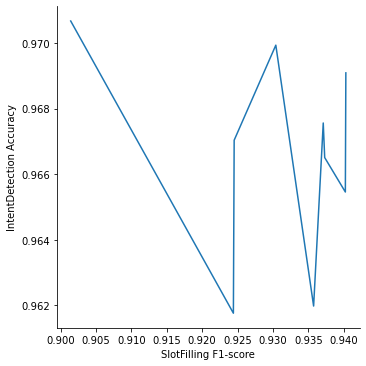

In [62]:
sns.relplot(data=tmp, x=('test_f1', 'slot'), y=('test_acc', 'intent'), kind='line')
plt.xlabel('SlotFilling F1-score')
plt.ylabel('IntentDetection Accuracy')
plt.savefig('plots/new_model_snips.pdf', bbox_inches='tight')